<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">

<h1><font size=4>Trabajo Fin de Master (TFM)</font></h1>
<br>
<h2><font size=6>WiDS Datathon 2024 - Challenge 2</font></h2>
<h3><font size=5>Modelos de regresión para estimación del periodo de diagnóstico metastático</font></h3>
<h3><font size=5>Parte 2 - Modelos de Regresión</font></h3>
<br>
<h1><font size=4>Alumna: Luna Jiménez Fernández</font></h1>
<br>



<div align="right">
<font size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font size=3>Universidad de Castilla-La Mancha</font>
</div>

<br>

---

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Python imports
from time import time
import itertools
from multiprocessing import cpu_count
from collections import OrderedDict

# Array manipulation libraries
import numpy as np
import pandas as pd

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Simple regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, SVR

# Bagging ensemble models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Boosting ensemble models
from sklearn.ensemble import AdaBoostRegressor, HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost.utils import get_gpu_device_count
from xgboost import XGBRegressor

# Experimentation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform
from skopt.space import Real, Integer
from sklearn.metrics import root_mean_squared_error

# Model saving and loading
import pickle
import json
import os
from pathlib import Path

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Filter warnings - as some models have convergence problems
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# Seed for random experiments - 7 is the number
RANDOM_SEED = 777

# Check if a GPU is available for training
GPU_AVAILABLE = bool(get_gpu_device_count())
# Number of cores to use for training
CPU_COUNT = cpu_count() // 2

En la primera libreta se realizó un **análisis exploratorio de datos** exhaustivo para entender en profundidad el comportamiento del conjunto de datos de interés - el **segundo desafío** del **Women in Data Science (*WiDS*) Datathon** del año 2024, disponible en el [siguiente enlace](https://www.kaggle.com/competitions/widsdatathon2024-challenge2/overview).

Tras este estudio, el objetivo de la siguiente libreta es tanto la **construcción de modelos de regresión** capaces de predecir el **tiempo de diagnóstico de la metástasis** a partir de los atributos seleccionados, como la **evaluación** de estos con el fin de estudiar si resultan de utilidad y si - como se planteó - los **atributos geográficos, socioeconómicos y climáticos** juegan algún papel relevante en la estimación de los valores.

---

# Índice

* [3. Selección de atributos y pre-procesamiento](#section3)
    * [3.1. Carga y particionamiento del conjunto de datos](#section3-1)
    * [3.2. Selección de atributos](#section3-2)
    * [3.3. Pre-procesamiento de los datos](#section3-3)
* [4. Selección de modelos de regresión e hiperparámetros](#section4)
    * [4.1. Baselines - estimadores lineales, árboles y SVMs](#section4-1)
    * [4.2. Ensembles - estimadores basados en agrupaciones de estimadores simples](#section4-2)
* [5. Experimentación](#section5)
    * [5.1. Ajuste de hiperparámetros](#section5-1)
    * [5.2. Validación de los modelos ajustados](#section5-2)
    * [5.3. Evaluación del modelo final sobre el conjunto de test](#section5-3)
* [6. Análisis de resultados](#section6)
    * [6.1. Estadísticas de los subconjuntos de atributos](#section6-1)
    * [6.2. Estadísticas de los modelos seleccionados](#section6-2)
    * [6.3. Estadísticas del modelo final](#section6-3)
* [7. Conclusiones](#section7)
* [8. *Streamlit* - Aplicación web](#section8)
---

<a id="section3"></a>

# 3. Selección de atributos y pre-procesamiento

Tras finalizar el **análisis exploratorio de datos** en la libreta anterior, el siguiente paso en el proceso de ciencia de datos es el **preprocesamiento de la información** - para ser utilizada posteriormente por modelos de regresión, con el fin de predecir el tiempo de diagnóstico de la metástasis.

Concretamente, en este apartado se realizan las siguientes preparaciones:
- **Cargar y particionar** los conjuntos de datos en **entrenamiento**, **validación** y **test**.
- **Seleccionar el subconjunto de atributos** que van a ser utilizados durante la experimentación.
- **Preparar las *pipelines*** encargadas de transformar los datos crudos en datos listos para ser utilizados por los modelos posteriores.

---

<a id="section3-1"></a>

## 3.1. Carga y particionamiento del conjunto de datos

Durante el análisis exploratorio de datos se trabajó únicamente sobre el **conjunto de entrenamiento** - con el fin de evitar cualquier posible fuga de datos al estudiar el conjunto de test. Ahora bien, el desafio en Kaggle ofrece **dos conjuntos de datos**:
- `train.csv`: El **conjunto de entrenamiento**, con **150 atributos** y los valores de la **variable objetivo** (el tiempo de diagnóstico) asociados a cada instancia.
- `test.csv`: El **conjunto de test**, conteniendo únicamente los **150 atributos** sin los valores de la variable objetivo.

El primer paso, por tanto, consiste en **cargar ambos conjuntos de datos** como *DataFrames*. Además, se realiza una **transformación** de los atributos categóricos - almacenandolos con el formato específico de *Pandas*, `category` -, de cara a los modelos futuros que se van a utilizar:

In [4]:
# Loading the CSV files - force zip3 to be read as a string
df_train = pd.read_csv("data/train.csv", index_col="patient_id", dtype={"patient_zip3": object})
df_test = pd.read_csv("data/test.csv", index_col="patient_id", dtype={"patient_zip3": object})

# Transform the string dtypes into categorical dtypes
df_train[df_train.select_dtypes(exclude="number").columns.to_list()] = df_train[df_train.select_dtypes(exclude="number").columns.to_list()].astype("category")
df_test[df_test.select_dtypes(exclude="number").columns.to_list()] = df_test[df_test.select_dtypes(exclude="number").columns.to_list()].astype("category")

# Display a small sample of both datasets to show that they have been properly loaded
print(f"Training size: {df_train.shape}")
display(df_train.sample(5))
display(df_train.dtypes)
print(f"Test size: {df_test.shape}")
display(df_test.sample(5))
display(df_test.dtypes)

Training size: (13173, 151)


,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
patient_id,,,,,,,,,,,,,,,,,,,,,
334482,NaN,COMMERCIAL,NM,875,West,Mountain,73,F,NaN,C50811,...,48.86,58.76,68.05,69.05,66.48,61.19,48.09,34.59,28.59,40
302119,White,COMMERCIAL,NM,880,West,Mountain,54,F,NaN,1749,...,62.78,69.52,78.80,79.49,78.06,72.50,59.90,47.16,42.21,328
960151,NaN,MEDICARE ADVANTAGE,NY,117,Northeast,Middle Atlantic,83,F,NaN,C50819,...,45.35,61.65,67.32,76.93,76.20,68.16,55.51,42.06,36.45,15
403743,NaN,COMMERCIAL,OH,440,Midwest,East North Central,65,F,NaN,C50111,...,40.53,63.94,68.29,71.97,72.24,67.13,52.23,35.63,33.37,0
736943,NaN,COMMERCIAL,FL,334,South,South Atlantic,64,F,NaN,1748,...,74.18,76.53,81.23,82.35,81.81,82.26,79.40,74.36,69.03,266


patient_race                   category
payer_type                     category
patient_state                  category
patient_zip3                   category
Region                         category
                                 ...   
Average of Sep-18               float64
Average of Oct-18               float64
Average of Nov-18               float64
Average of Dec-18               float64
metastatic_diagnosis_period       int64
Length: 151, dtype: object

Test size: (5646, 150)


,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
patient_id,,,,,,,,,,,,,,,,,,,,,
470586,NaN,COMMERCIAL,AR,727,South,West South Central,43,F,NaN,C50919,...,49.47,49.86,71.73,77.09,79.06,75.82,71.58,59.84,41.76,40.15
202200,NaN,COMMERCIAL,LA,705,South,West South Central,59,F,NaN,C50411,...,63.74,63.69,77.61,81.54,82.75,81.84,80.15,72.49,56.28,55.06
176095,White,NaN,IL,622,Midwest,East North Central,54,F,NaN,1749,...,42.62,48.57,72.25,76.84,77.13,75.73,73.07,57.40,42.41,38.46
130238,White,NaN,CO,805,West,Mountain,59,F,NaN,C50911,...,40.49,45.79,57.81,68.13,70.75,68.28,64.02,49.37,35.65,29.80
886558,NaN,COMMERCIAL,CA,933,West,Pacific,65,F,27.0,C50912,...,53.85,61.56,67.13,74.27,83.47,78.83,73.57,64.39,54.68,47.87


patient_race         category
payer_type           category
patient_state        category
patient_zip3         category
Region               category
                       ...   
Average of Aug-18     float64
Average of Sep-18     float64
Average of Oct-18     float64
Average of Nov-18     float64
Average of Dec-18     float64
Length: 150, dtype: object

Ahora bien, debido al proceso que se va a seguir durante el entrenamiento de los modelos (**selección de hiperparámetros**, **selección de modelos** y **evaluación**), utilizar directamente los conjuntos de datos descritos podría llevar a un problema de **fuga de datos** - al usar el mismo conjunto de datos para entrenar los modelos y evaluar sus hiperparámetros.

Para evitar esto, se va a dividir el conjunto de entrenamiento en dos - un conjunto de **entrenamiento** y uno de **validación**  -, siendo la distribución final la siguiente:
- **Entrenamiento**: El conjunto de entrenamiento cumple dos tareas - tanto el **entrenamiento de los modelos de regresión** propuestos como el **ajuste de hiperparámetros de los mismos** a través de una validación cruzada.
- **Validación**: Una vez se tienen los modelos entrenados, el conjunto de validación será utilizado para **seleccionar el mejor modelo de forma honesta** - utilizando un conjunto de datos que no han utilizado durante el entrenamiento para evitar sesgos o fugas de datos.
- **Test**: Finalmente, se utilizará el conjunto de test para **evaluar el rendimiento real** del modelo seleccionado a través de la validación - utilizando una plataforma externa (***Kaggle***) para medir este rendimiento. 

Además, todos estos conjuntos de datos se van a fraccionar en **atributos** (`X`) y **variable objetivo** (`y`) para seguir el estándar de `scikit-learn`.

In [5]:
# Split the datasets into training, validation and test
# Train / Val
X, y = df_train.drop(columns="metastatic_diagnosis_period"), df_train["metastatic_diagnosis_period"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# Test
X_test = df_test

# Display the information about each dataset - to ensure that it has been loaded and partitioned correctly
print("ENTRENAMIENTO:")
print(f"\t-Atributos: {X_train.shape}")
print(f"\t-Variable objetivo: {y_train.shape}")
print("VALIDACIÓN:")
print(f"\t-Atributos: {X_val.shape}")
print(f"\t-Variable objetivo: {y_val.shape}")
print("TEST:")
print(f"\t-Atributos: {X_test.shape}")

ENTRENAMIENTO:
	-Atributos: (9879, 150)
	-Variable objetivo: (9879,)
VALIDACIÓN:
	-Atributos: (3294, 150)
	-Variable objetivo: (3294,)
TEST:
	-Atributos: (5646, 150)


---

<a id="section3-2"></a>

## 3.2. Selección de atributos

Como se observó durante el análisis exploratorio, no tendría sentido utilizar directamente el **conjunto de datos completos** para el entrenamiento de modelos:
- La **dimensionalidad del conjunto de datos** - con 150 atributos en total - es excesiva para la cantidad de datos disponible, lo que podría llevar a sobreajustes.
- Algunos atributos tienen **una cantidad excesiva de posibles valores** - que se puede traducir, de nuevo, en sobreajustes del modelo al no tener suficientes datos para aprender adecuadamente las relaciones.
- La **amplia mayoría de atributos son irrelevantes** para la variable objetivo - ya sea por su baja calidad o por la poca correlación que tienen con la variable objetivo.

Por tanto, es necesario **seleccionar un subconjunto de atributos**, con el fin reducir la dimensionalidad y cribar los atributos que no sean relevantes para la predicción. Para buscar este subconjunto, se proponen varias posibilidades - almacenadas en el diccionario `attribute_selection`:

In [6]:
attribute_selection = {}

### 3.2.1. Selección por análisis exploratorio

Durante el análisis exploratorio de datos se ha realizado un análisis exhaustivo de los datos - tanto su **comportamiento** como su **relevancia** y las **transformaciones** que serían necesarias para utilizarse.

A partir de las conclusiones extraidas, se ha obtenido el siguiente **conjunto de atributos** - representando los atributos más relevantes estudiados dentro del conjunto de datos, junto a las **transformaciones a aplicar** sobre éstos:
- **Código de diagnóstico del cancer de mama (`breast_cancer_diagnosis_code`):** Variable categórica.
    - Debido al gran número de posibles valores, es necesario **agrupar los valores menos frecuentes**.
- **Código de diagnóstico del cancer metastático (`metastatic_cancer_diagnosis_code`):** Variable categórica.
    - Debido al gran número de posibles valores, es necesario **agrupar los valores menos frecuentes**.
- **Estado de residencia del paciente (`patient_state`):** Variable categórica.
    - Debido al gran número de posibles valores, es necesario **agrupar los valores menos frecuentes**.
- **Raza del paciente (`patient_race`):** Variable categórica.
    - Se **agrupan los valores perdidos** bajo un único valor.
- **Tipo de seguro médico del paciente (`payer_type`):** Variable categórica.
    - Se **agrupan los valores perdidos** bajo un único valor.

Como se puede observar, **todos los atributos seleccionados son categóricos**.

In [7]:
attribute_selection["manual"] = {
    "categorical": ["breast_cancer_diagnosis_code", "metastatic_cancer_diagnosis_code", "patient_state", "patient_race", "payer_type"]
}

Estas transformaciones se han elegido en base a los **test estadísticos** que se realizaron durante el análisis exploratorio:
- La **agrupación de los valores** en las variables de alta dimensionalidad aumenta la significación estadística, al reducirse el número de valores con un número demasiado bajo de instancias.
- La **sustitución de valores perdidos** mejora el rendimiento en los atributos donde el número de valores perdidos es excesivo.

A su vez, se ha optado por descartar los siguientes atributos:
- **Edad (`patient_age`) y IMC (`bmi`) del paciente**: Variables numéricas sin correlación con la variable objetivo.
- **Región (`Region`) y división (`Division`) del paciente**: Variables categóricas con poca relevancia, y ya representadas por otra variable más significativa (`patient_state`).
- **Código zip del paciente (`patient_zip3`)**: Variable categórica ya representada por otra variable (`patient_state`) con dimensionalidad excesiva.
- **Todas las variables geográficas, socioeconómicas y climáticas**: 136 atributos numéricos sin correlación con la variable objetivo.

### 3.2.2. Selección automática

En el apartado anterior se ha obtenido un subconjunto de atributos en base al estudio que se realizó en la libreta anterior. Ahora bien, aunque el estudio estuviese apoyado en **gráficas y tests estadísticos**, sigue existiendo la posibilidad de que **el analista haya introducido sesgos propios**.

Otra posibilidad es utilizar **algoritmos de aprendizaje automático** para realizar el proceso de selección de atributos - ya sea basandose en **tests estadísticos** o en el **comportamiento de modelos reales entrenados sobre los datos**.

Ahora bien, la mayoría de métodos necesitan un **preprocesamiento previo**, para imputar valores perdidos y unificar el comportamiento de atributos categóricos y numéricos. Concretamente, en este caso:
- **Atributos categóricos**: Se imputan los valores perdidos como un valor constante (`UNKNOWN`) y se **codifican los posibles valores del atributo** utilizando `One-Hot Encoding` - donde cada valor de cada variable categórica se **representa como un atributo separado**, que puede ser `True` (si el valor de la variable se corresponde) o `False` en cualquier otro caso.
    - Debido a la gran complejidad de algunos atributos, se opta por **agrupar todos los valores con menos de 100 instancias**. Este valor se ha elegido de forma arbitraria para la selección de variables, y tendrá que ser ajustado posteriormente durante el ajuste de hiperparámetros.
    - La codificación va a causar que **aumente el número de atributos respecto al conjunto de entrenamiento original** - lo que significa que **será necesario re-agrupar los valores de las variables mediante estadísticos** para realizar la selección.
- **Atributos numéricos**: Se imputan los valores perdidos utilizando la **mediana** (debido al gran número de valores extremos) y se **escalan los valores** utilizando la mediana y la desviación estándar.

Se define un `Pipeline` para realizar automáticamente el preprocesamiento descrito - aplicandose sobre los datos del **conjunto de entrenamiento** para evitar fugas de datos:

In [8]:
# Extract all attributes of each type
categorical_variables = X_train.select_dtypes(exclude=np.number).columns.to_list()
numerical_variables = X_train.select_dtypes(include=np.number).columns.to_list()

# Feature Selection pipeline - Transforms the dataset to allow for feature selection
fs_preprocessing = ColumnTransformer([
    # Categorical attributes - imputting with a constant value and encoding (one-hot)
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
        ("oh", OneHotEncoder(min_frequency=100))
    ]), categorical_variables),
    # Numerical attributes - imputting with median values and scaling
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler())
    ]), numerical_variables)
])

# Display the pre-processing pipeline
display(fs_preprocessing)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('oh',
                                                  OneHotEncoder(min_frequency=100))]),
                                 ['patient_race', 'payer_type', 'patient_state',
                                  'patient_zip3', 'Region', 'Division',
                                  'patient_gender',
                                  'breast_cancer_diagnosis_code',
                                  'breast_cancer_diagnosis_desc',
                                  'metastatic_cancer_diagnos...
                                  'age_60s', 'age_70s', 'age_over_80', 'male',
                                  'female', 'married', 'divorced',
                                  'never_married', 'widowed', 'family_size',
                                  'family_dual_income',
                                  'income_household_median',
                                  'income_household_under_5',
                                  'income_household_5_to_10',
                                  'income_household_10_to_15',
                                  'income_household_15_to_20',
                                  'income_household_20_to_25',
                                  'income_household_25_to_35',
                                  'income_household_35_to_50', ...])])

Existen dos estrategias para realizar una selección automática de atributos:

#### - Métodos *filter*

Los **métodos de filtrado (*filter*)** utilizan **test estadísticos** para evaluar de forma automática la relevancia de cada variable, sin la necesidad de entrenar modelos- haciendolos **más agiles**, aunque menos capaces de identificar las correlaciones entre grupos de atributos.

Para este caso se utilizan **tests F** - tests de **varianza**, para identificar las **diez variables** más relevantes del conjunto de datos 

In [9]:
# FEATURE RANKING - Using F-Regression
# Create the pipeline
fs_kbest = Pipeline([
    ("preprocessing", fs_preprocessing),
    ("kbest", SelectKBest(f_regression, k="all"))
])
fs_kbest.fit(X_train, y_train)

# Join the variable names and values
df_kbest = pd.DataFrame({
    "variable": fs_kbest.get_feature_names_out(),
    "score": fs_kbest["kbest"].scores_
})

# Process the dataframe, step by step
df_kbest_ordered = (
    df_kbest.assign(variable=(
        df_kbest["variable"].str.extract(r"cat__(?P<cat>[0-9A-Za-z_\- ]+)_(?:[0-9A-Za-z\- ]+|infrequent)|num__(?P<num>[0-9A-Za-z_\- ]+)")   # 1 - Extract the proper variable name
        .apply(lambda s: s["cat"] if not pd.isna(s["cat"]) else s["num"], axis=1)                                                           #     (joining into a single column)
    ))
    .groupby("variable").agg(max_score=("score", "max"), avg_score=("score", "mean"))                                                       # 2 - Obtain the maximum and avg score of each variable
    .sort_values(by="max_score", ascending=False)                                                                                           # 3 - Sort by MAXIMUM score
    
)

# Display the 15 best attributes
display(df_kbest_ordered.head(15))

,max_score,avg_score
variable,,
breast_cancer_diagnosis_desc,3163.104702,293.539683
breast_cancer_diagnosis_code,3163.104702,293.539683
metastatic_cancer_diagnosis_code,58.998175,12.662202
payer_type,56.152011,21.747065
patient_age,32.205066,32.205066
breast_cancer_diagnosis_desc_infrequent,30.799057,30.799057
breast_cancer_diagnosis_code_infrequent,30.799057,30.799057
patient_state,28.378242,3.208365
labor_force_participation,15.166246,15.166246


A partir de estos atributos obtenidos, se observa que:
- Los **atributos más importantes** son consistentes con los observados durante el estudio: **el código de diagnóstico de cancer** - tanto original como metástasis - y el **tipo de seguro médico**.
- El algoritmo da **mayor importancia** a algunos atributos numéricos - principalmente:
    - **Edad del paciente** (`patient_age`)
    - **Porcentaje de residentes empleados** (`labor_force_participation`)
    - **Porcentaje de residentes con estudios universitarios** (`education_bachelors` y `education_college_or_above`)
    - **Porcentaje de hogares con dos o más ingresos** (`family_dual_income`)
- Algunos atributos categóricos estudiados **tienen menor importancia de la esperada**:
    - **Estado de residencia del paciente** (`patient_state`)
    - **Raza del paciente** (`patient_race`)

Es de interés destacar que **existe una diferencia muy considerable en la importancia de los atributos** - donde el **tipo de cancer de mama original** es varios ordenes de magnitud más relevante que el resto de variable.

El **subconjunto de variables** obtenido por el proceso es el siguiente:

In [10]:
attribute_selection["filter"] = {
    "categorical": ["breast_cancer_diagnosis_code", "metastatic_cancer_diagnosis_code", "payer_type", "patient_state", "patient_race"],
    "numerical": ["patient_age", "labor_force_participation", "education_bachelors", "family_dual_income", "education_college_or_above"]
}

#### - Métodos *wrapper*

Los **métodos de envoltura *wrapper*** utilizan **modelos de aprendizaje automáticos** entrenados sobre los datos para elegir las variables más relevantes. Pese a ser más lentos, sus resultados son **más fiables** - al estar estudiando el comportamiento real de un modelo.

Para este caso se entrenará un modelo de **Random Forest**, utilizando el **conjunto de entrenamiento** para evitar fugas - buscando encontrar los **diez atributos más relevantes**:

In [11]:
# FEATURE RANKING - Using Random Forest as a wrapper

# Training time is short, but a model is still kept for consistency
# If the model already exists:
if os.path.exists(r"./models/feature_selection/model.pkl"):
    # Load the trained pipeline instead
    with open(r"./models/feature_selection/model.pkl", "rb") as model_file:
        fs_rf = pickle.load(model_file)
        print("- Feature subset model loaded from disc")

else:
    # Create and train the pipeline
    fs_rf = Pipeline([
        ("preprocessing", fs_preprocessing),
        ("wrapper", RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED))
    ])
    fs_rf.fit(X_train, y_train)

    # Store the model in disc
    Path(r"./models/feature_selection/").mkdir(parents=True, exist_ok=True)
    with open(r"./models/feature_selection/model.pkl", "wb") as model_file:
        pickle.dump(fs_rf, model_file)
    print("- Feature subset model trained")

# Join the variable names and values
df_rf = pd.DataFrame({
    "variable": fs_rf["preprocessing"].get_feature_names_out(),
    "score": fs_rf["wrapper"].feature_importances_
})

# Process the dataframe, step by step
df_rf_ordered = (
    df_rf.assign(variable=(
        df_rf["variable"].str.extract(r"cat__(?P<cat>[0-9A-Za-z_\- ]+)_(?:[0-9A-Za-z\- ]+|infrequent)|num__(?P<num>[0-9A-Za-z_\- ]+)")      # 1 - Extract the proper variable name
        .apply(lambda s: s["cat"] if not pd.isna(s["cat"]) else s["num"], axis=1)                                                           #     (joining into a single column)
    ))
    .groupby("variable").agg(max_score=("score", "max"), avg_score=("score", "mean"))                                                       # 2 - Obtain the maximum and avg score of each variable
    .sort_values(by="max_score", ascending=False)                                                                                           # 3 - Sort by MAXIMUM score
    
)

# Display the 15 best attributes
display(df_rf_ordered.head(15))

- Feature subset model loaded from disc


,max_score,avg_score
variable,,
breast_cancer_diagnosis_code,0.123410,0.012368
breast_cancer_diagnosis_desc,0.119221,0.012102
patient_age,0.079427,0.079427
bmi,0.037954,0.037954
metastatic_cancer_diagnosis_code,0.012096,0.004549
breast_cancer_diagnosis_desc_infrequent,0.010563,0.010563
breast_cancer_diagnosis_code_infrequent,0.009509,0.009509
payer_type,0.007699,0.006449
patient_race,0.007403,0.005098


*(NOTA: `RandomForest` tiene un componente aleatorio. Se ha utilizado una semilla, pero sigue existiendo la posibilidad de que cambien los valores en ejecuciones posteriores)*

A partir de estos atributos, se observa que:

- En este caso, el atributo más importante es **únicamente el código de diagnóstico del cancer de mama** - el diagnóstico de metástasis **pierde peso**.
- Tienen un mayor peso los **atributos numéricos**:
    - **Edad** (`patient_age`) y **IMC** (`bmi`) del paciente.
    - **Mediana del tiempo de transporte de los residentes al trabajo** (`commute_time`).
    - **Porcentaje de la población con edad superior a 40 años** (`age_40s`).
    - **Porcentaje de la población con estudios en STEM** (`education_stem_degree`).
    - **Porcentaje de la población identificada con razas nativas** (`race_native`).
- Los **atributos categóricos identificados** - **raza del paciente** (`patient_race`) y **tipo de seguro médico** (`payer_type`) pierden importancia.
- **El estado de residencia del paciente** (`patient_state`) deja de estar entre los **diez atributos más relevantes**.

El subconjunto de atributos obtenidos por este proceso es el siguiente:

In [12]:
attribute_selection["wrapper"] = {
    "categorical": ["breast_cancer_diagnosis_code", "metastatic_cancer_diagnosis_code", "patient_race", "payer_type"],
    "numerical": ["patient_age", "bmi", "commute_time", "race_native", "education_stem_degree", "age_40s"]
}

### 3.2.3. Conjunto de datos completo

Finalmente, otra opción posible es **utilizar todos los atributos del conjunto de datos** sin ningún tipo de criba o pre-selección. Esta opción tiene ciertas **ventajas** y **desventajas**:
- Por un lado, **algunos modelos funcionan mejor sin selección de variables** - especialmente aquellos que realizan una selección interna (como la **regresión lineal de tipo Lasso** o los **ensembles tipo Random Forest**).
- Por otro lado, **la complejidad excesiva del conjunto de datos** puede afectar al entrenamiento - provocando sobreajustes por la falta de instancias en el conjunto de datos, y perjudicando al rendimiento de los modelos sin selección de atributos interna. Además, **el tiempo de entrenamiento aumenta considerablemente** debido a la mayor complejidad de los modelos entrenados.

En este caso, se incluye principalmente como ***baseline*** para el resto de opciones - pudiendo de esta forma estudiar si **la selección de variables ha mejorado el rendimiento de los modelos**.

*(**NOTA**: Debido al funcionamiento de los modelos, es necesario eliminar el atributo `patient_zip3` por la cardinalidad excesiva)*

In [13]:
attribute_selection["no_selection"] = {
    "categorical": X_train.select_dtypes(exclude=np.number).drop("patient_zip3", axis=1).columns.to_list(),
    "numerical": X_train.select_dtypes(include=np.number).columns.to_list()
}

---

<a id="section3-3"></a>

## 3.3. Pre-procesamiento de los datos

El último paso antes del entrenamiento de los modelos es el **preprocesamiento del conjunto de datos** - realizar las transformaciones adecuadas sobre el conjunto de datos para **optimizarlo** de cara al entrenamiento y evaluación de los modelos, con el fin de mejorar su rendimiento.

Los pasos que se van a seguir para pre-procesar los datos - dependiendo del **tipo de datos** - son los siguientes:
- **Atributos categóricos**:
    1. **Imputación**: Se reemplazan todos los valores perdidos por un **valor constante** - `UNKNOWN`.
        - Como se estudió durante el análisis exploratorio, en la mayoría de variables categóricas **tiene sentido tratar los valores perdidos como un valor distinto** - al poder representar valores que no se han podido adquirir o que no se han querido compartir.
    2. **Codificación**: Se transforma la representación de la variable utilizando **`One-Hot Encoding`** - el atributo se divide en **tantos atributos como valores tiene la variable**, donde cada uno de estos nuevos atributos representa si la instancia contiene el valor representado (`1`) o no (`0`).
        - Debido a la gran complejidad de los atributos categóricos (teniendo, en general, **40 o más posibles valores**) y a que **los atributos no son exhaustivos** y pueden haber valores no vistos antes en el conjunto de datos, es necesario **agrupar los valores menos frecuentes** para reducir la dimensionalidad. El **umbral de agrupamiento** será uno de los hiperparámetros a ajustar posteriormente.
        - Es importante destacar que **los métodos de *Gradient Boosting* no necesitan codificación de las variables categóricas** - por lo que este paso es opcional en dichos casos.
- **Atributos numéricos**:
    1. **Imputación**: Se reemplazan todos los valores perdidos por **la mediana del atributo**.
        - En general, el conjunto de datos tiene un gran número de **valores extremos y sesgos**. Utilizar la mediana frente a la media ayuda a crear valores más robustos.
    2. **Escalado**: Se *centran* los valores de los atributos alrededor de la **mediana** y la **desviación estándar**.
        - Normalmente se escala utilizando el **valor promedio**. Ahora bien, para tener un escalado más robusto se utiliza el **rango intercuartil** para el escalado a través de la clase `RobustScaler`.

El problema ahora es que los pasos de preprocesamiento deben ser **idénticos y replicables** en todos los aspectos - tanto entre los experimentos con **distintos modelos y subconjuntos de atributos**, como entre **el entrenamiento y la evaluación** con distintos conjuntos de datos.

Para automatizar este proceso, se definen **`Pipelines`** - cadenas de transformaciones que se aplican **automáticamente** antes de usar los modelos de aprendizaje automático, tanto para **entrenarlos** como para **predecir la variable objetivo para un conjunto de datos**. 

Debido al funcionamiento de `scikit-learn`, es necesario definir `Pipelines` para cada uno de los subconjuntos de atributos que se van a utilizar. Estos pasos de preprocesamiento se almacenan en el diccionario `preprocessing_pipelines` para su posterior automarización, con la siguiente estructura:

```
preprocessing_pipelines{
    "one-hot": {
        <nombre de subconjunto de atributos>: Pipeline
        ...
    },
    "unmodified": {
        <nombre de subconjunto de atributos>: Pipeline
        ...
    }
}
```

Debido a la diferencia en el funcionamiento de los modelos a utilizar durante la experimentación - concretamente, al **tratamiento de los atributos categóricos** -, se pueden distinguir dos familias de *Pipelines*:
- `one-hot`: *Pipelines* que aplican un **proceso de codificación *one-hot*** sobre los atributos categóricos - la mayoría de modelos.
- `unmodified`: *Pipelines* que no realizan ningun proceso de codificación. Esto es utilizado principalmente por los modelos que manejan atributos categóricos de forma nativa, como los modelos de *Gradient Boosting*.
    - Internamente, se añade un paso de **re-categorización** de los atributos - al perderse los tipos de datos durante las transformaciones.

In [14]:
# Prepare the dictionary 
preprocessing_pipelines = {
    "one-hot": {},
    "unmodified": {}
}

Internamente, el funcionamiento de los *Pipelines* provoca que se pierdan los tipos de datos de los *DataFrames* - algo necesario para el funcionamiento de algunos modelos. Por tanto, el método `to_categorical()` se utiliza como transformador para **devolver el tipo de datos `Categorical` a los atributos necesarios.

In [15]:
def to_categorical(dataframe):
    """
    Transforms all the elements in a DataFrame into Categorical dTypes.
    
    Used instead of a lambda function for pickling purposes
    """

    return dataframe.astype("category")

---

#### - Subconjunto manual (sin variables numéricas)

La selección manual de atributos solo ha incluido atributos categóricos. Por tanto, sus `Pipelines` correspondientes **no necesitan incorporar transformaciones relativas a atributos numéricos**.

Ahora bien, para facilitar la automatización posterior de los experimentos, se **utilizan `ColumnTransformer`** pese a no haber separación por tipos de datos - al seguir la misma estructura que el resto de *Pipelines*, no es necesario tratarlo de forma distinta.

In [16]:
# MANUAL PIPELINE - Categorical values
# Reuses the ColumnTransformer structure to automatize accessing the OneHotEncoder hyperparameters - as min_frequency will be adjusted
# Otherwise, the code would have to take into account the subset of attributes being used to know the inner pipeline structure

# With one-hot encoding
preprocessing_pipelines["one-hot"]["manual"] = ColumnTransformer([
    # Imput and encode categorical attributes
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
        ("oh", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=100))
    ]), attribute_selection["manual"]["categorical"])
])

# Without encoding
preprocessing_pipelines["unmodified"]["manual"] = ColumnTransformer([
    # Imput categorical attributes
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN").set_output(transform="pandas")),
        ("categorizer", FunctionTransformer(to_categorical).set_output(transform="pandas"))
    ]), attribute_selection["manual"]["categorical"])
]).set_output(transform="pandas")

### - Subconjuntos automáticos (*filter* y *wrapper*) y conjunto de datos completo

En todos estos casos, la selección de atributos ha incluido atributos **categóricos y numéricos**. Por tanto, el *Pipeline* debe ser capaz de procesar ambos tipos de atributos por separado - para lo que se utiliza `ColumnTransformer`:

In [17]:
# CATEGORICAL AND NUMERICAL PIPELINES
# Feature selection subsets to consider
fs_list = ["filter", "wrapper", "no_selection"]

for feature_subset in fs_list:

    # Preprocessing with one-hot categorical attribute encoding
    preprocessing_pipelines["one-hot"][feature_subset] = ColumnTransformer([
        # Imput and encode categorical attributes
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
            ("oh", OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=100))
        ]), attribute_selection[feature_subset]["categorical"]),
        # Imput and scale numerical attributes
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())
        ]), attribute_selection[feature_subset]["numerical"])
    ])

    # Preprocessing without categorical attribute encoding
    preprocessing_pipelines["unmodified"][feature_subset] = ColumnTransformer([
        # Imput categorical attributes
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN").set_output(transform="pandas")),
            ("categorizer", FunctionTransformer(to_categorical).set_output(transform="pandas"))
        ]), attribute_selection[feature_subset]["categorical"]),
        # Imput and scale numerical attributes
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())
        ]), attribute_selection[feature_subset]["numerical"])
    ]).set_output(transform="pandas")

Para comprobar que se ha realizado la construcción de *Pipelines* de forma adecuada, se muestran **los pipelines resultantes**:

In [18]:
# Display every preprocessing pipeline
for encoding_type, encoding_dict in preprocessing_pipelines.items():
    for feature_subset, pipeline in encoding_dict.items():
        print(f"{encoding_type} - {feature_subset}")
        display(pipeline)

one-hot - manual


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('oh',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=100))]),
                                 ['breast_cancer_diagnosis_code',
                                  'metastatic_cancer_diagnosis_code',
                                  'patient_state', 'patient_race',
                                  'payer_type'])])

one-hot - filter


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('oh',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=100))]),
                                 ['breast_cancer_diagnosis_code',
                                  'metastatic_cancer_diagnosis_code',
                                  'payer_type', 'patient_state',
                                  'patient_race']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['patient_age', 'labor_force_participation',
                                  'education_bachelors', 'family_dual_income',
                                  'education_college_or_above'])])

one-hot - wrapper


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('oh',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=100))]),
                                 ['breast_cancer_diagnosis_code',
                                  'metastatic_cancer_diagnosis_code',
                                  'patient_race', 'payer_type']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['patient_age', 'bmi', 'commute_time',
                                  'race_native', 'education_stem_degree',
                                  'age_40s'])])

one-hot - no_selection


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('oh',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=100))]),
                                 ['patient_race', 'payer_type', 'patient_state',
                                  'Region', 'Division', 'patient_gender',
                                  'breast_cancer_diagnosis_code',
                                  'breast_cancer_diagnosis_desc',
                                  'met...
                                  'age_60s', 'age_70s', 'age_over_80', 'male',
                                  'female', 'married', 'divorced',
                                  'never_married', 'widowed', 'family_size',
                                  'family_dual_income',
                                  'income_household_median',
                                  'income_household_under_5',
                                  'income_household_5_to_10',
                                  'income_household_10_to_15',
                                  'income_household_15_to_20',
                                  'income_household_20_to_25',
                                  'income_household_25_to_35',
                                  'income_household_35_to_50', ...])])

unmodified - manual


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('categorizer',
                                                  FunctionTransformer(func=<function to_categorical at 0x000002C32C2414E0>))]),
                                 ['breast_cancer_diagnosis_code',
                                  'metastatic_cancer_diagnosis_code',
                                  'patient_state', 'patient_race',
                                  'payer_type'])])

unmodified - filter


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('categorizer',
                                                  FunctionTransformer(func=<function to_categorical at 0x000002C32C2414E0>))]),
                                 ['breast_cancer_diagnosis_code',
                                  'metastatic_cancer_diagnosis_code',
                                  'payer_type', 'patient_state',
                                  'patient_race']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['patient_age', 'labor_force_participation',
                                  'education_bachelors', 'family_dual_income',
                                  'education_college_or_above'])])

unmodified - wrapper


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('categorizer',
                                                  FunctionTransformer(func=<function to_categorical at 0x000002C32C2414E0>))]),
                                 ['breast_cancer_diagnosis_code',
                                  'metastatic_cancer_diagnosis_code',
                                  'patient_race', 'payer_type']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['patient_age', 'bmi', 'commute_time',
                                  'race_native', 'education_stem_degree',
                                  'age_40s'])])

unmodified - no_selection


ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='UNKNOWN',
                                                                strategy='constant')),
                                                 ('categorizer',
                                                  FunctionTransformer(func=<function to_categorical at 0x000002C32C2414E0>))]),
                                 ['patient_race', 'payer_type', 'patient_state',
                                  'Region', 'Division', 'patient_gender',
                                  'breast_cancer_diagnosis_code',
                                  'breast_cancer_diagnosis_...
                                  'age_60s', 'age_70s', 'age_over_80', 'male',
                                  'female', 'married', 'divorced',
                                  'never_married', 'widowed', 'family_size',
                                  'family_dual_income',
                                  'income_household_median',
                                  'income_household_under_5',
                                  'income_household_5_to_10',
                                  'income_household_10_to_15',
                                  'income_household_15_to_20',
                                  'income_household_20_to_25',
                                  'income_household_25_to_35',
                                  'income_household_35_to_50', ...])])

---

<a id="section4"></a>

# 4. Selección de modelos de regresión e hiperparámetros

En el apartado anterior se realizó la **selección de atributos** - proponiendo varios posibles subconjuntos de atributos para estudiar durante la experimentación - y se definió el **preprocesamiento** a realizar sobre estos atributos, de cara a prepararlos para el estudio.

El siguiente paso en el proceso de ciencia de datos, por tanto, sería el **entrenamiento y evaluación de modelos** a partir de los datos procesados y seleccionados. Ahora bien, antes de comenzar con el entrenamiento de los modelos, es necesario realizar una **selección de los modelos** que van a ser estudiados - junto a una **selección de hiperparámetros** a ser estudiado para cada modelo.

Por tanto, el objetivo de esta sección es:
1. Definir y estudiar los **estimadores** que se entrenaran y evaluarán durante el proceso de ciencia de datos.
    - Se propondrá una serie de modelos que servirán como *baseline* - el rendimiento base al que todos los modelos deberían aspirar a cumplir.
        - Sobre esto, se propondrán diversos modelos de regresión de familias típicas para los problemas de regresión - modelos **lineales** y **basados en árboles**.
    - Finalmente, se utilizarán ***ensembles*** - modelos estado del arte basados en agrupaciones de modelos más sencillos.
2. Seleccionar los **hiperparámetros** a estudiar para cada modelo.
    - Para ajustar el rendimiento de cada modelo al problema concreto, durante la experimentación se entrenará cada modelo varias veces - realizando una **validación cruzada** - probando distintos **conjuntos de hiperparámetros**.
    - Dependiendo de la complejidad en los hiperparámetros de cada modelo, la **exploración de los posibles hiperparámetros** se realizará de forma distinta:
        - `GridSearchCV`: Para modelos más simples, se realiza una **búsqueda exhaustiva** de todas las posibles combinaciones de hiperparámetros.
        - `BayesSearchCV`: Para modelos más complejos y lentos - donde el estudio exhaustivo no es factible - se realizará una **búsqueda probabilística** guiada.

En la siguiente sección de la libreta se realizará la **experimentación** sobre los modelos e hiperparámetros seleccionados. Para simplificar la **automatización** de estos experimentos, se almacena toda la información en un diccionario - `model_pipelines` -, utilizando la siguiente estructura:

```
model_pipelines{
    <nombre del modelo>: {
        "hyperparameter_search": "grid" | "random" | "bayes",
        "hyperparameter_grid: <hiperparámetros del modelo> | None,
        "models": {
            <subconjunto de datos>: <Pipeline>
        }
    }
    ...
}
```

Como se puede observar, para cada **modelo** se registra la siguiente información:
- `hyperparameter_search`: Tipo de busqueda de hiperparámetros que se realiza:
    - `"grid"`: Búsqueda exhaustiva de hiperparámetros - para modelos rápidos con pocos hiperparámetros.
    - `"random"`: Búsqueda completamente aleatoria - para modelos *simples* pero con **gran cantidad de hiperparámetros**.
    - `"bayes"`: Búsqueda aleatoria guiada con un modelo probabilístico subyacente - por el sobrecoste incluido, util principalmente para modelos **costosos** con **gran cantidad de hiperparámetros**.
- `hyperparameter_grid`: Diccionario incluyendo los hiperparámetros a buscar durante la experimentación.
- `models`: Para cada **posible subconjunto de atributos**, el *Pipeline* completo incluyendo preprocesamiento y modelo.

In [19]:
model_pipelines = {}


---

<a id="section4-1"></a>

## 4.1. *Baselines* - estimadores lineales, árboles y SVMs

En esta sección se definen los estimadores **simples** a utilizar durante la experimentación. Es importante distinguir que entendemos como **estimador simple / base** a cualquier estimador que **funciona de forma independiente** - frente a los *ensembles*, que funcionan como agrupaciones de estimadores simples. 

*(NOTA: Si bien la mayoría de modelos son a su vez sencillos a nivel de coste computacional, hay algunos (como las máquinas de vectores de soporte) que pueden tener costes elevados durante el entrenamiento. El abanico de posibles es más amplio del propuesto - se ha realizado una selección teniendo en cuenta el **tamaño del conjunto de datos** y la **alta dimensionalidad de este**.)*

En concreto, se van a estudiar algoritmos de las siguientes familias de modelos:
- **Lineales** - regresión lineal y algoritmos basados en ésta.
- **Arboles de decisión**.
- **Máquinas de vectores de soporte**.

El objetivo de los modelos propuestos en esta sección es servir como un *baseline* - una **puntuación base** que debería ser superada por el resto de modelos complejos, pero que sirve como un punto de referencia del **error promedio esperable si se entrenase el modelo más simple posible**.

---

### 4.1.1. Regresión lineal y variantes

Los modelos de **regresión lineal** buscan representar la dependencia entre un **atributo** y la **variable objetivo** a través de una **linea recta**, elegida con el fin de minimizar la distancia entre esta y todas las instancias del conjunto de datos - **reducir el error** ajustando los parámetros de la recta, buscando minimizar la **suma residual de errores cuadrados** en un proceso de optimización conocido como **mínimos cuadrados**.

Si bien el algoritmo inicial está propuesto para un único atributo, es posible **generalizarlo a múltiples atributos** - transformando la linea en un hiperplano, pero manteniendo el resto del proceso de optimización.

Estos modelos son **simples y muy eficientes** a la hora de ser entrenados y utilizados durante la inferencia. Ahora bien, también presentan el problema de que esta simpleza puede causar una **falta de capacidad computacional** a la hora de aprender relaciones más complejas entre datos, y **peor rendimiento cuando no existe independencia entre los atributos** - aunque existen diversas propuestas para solventar estos problemas.

En general - debido a la simplicidad de los modelos - se podrá realizar una **búsqueda exhaustiva de hiperparámetros** en un tiempo razonable.

#### - Regresión lineal

El modelo más simple de regresión lineal es el descrito previamente, implementado en `scikit-learn` en la clase `LinearRegression`. 

Debido a la simplicidad de este modelo, **no contiene ningún hiperparámetro a ajustar**. Ahora bien, durante el entrenamiento se realizará un ajuste sobre la **agrupación de los valores de las variables categóricas** - por lo que se seguirá utilizando una *validación cruzada de rejilla*.

In [20]:
# LINEAR REGRESSION
MODEL_NAME = "linear_regression"
# Base linear regression has no hyperparameters to adjust
HYPERPARAMETER_SEARCH = "grid"
# Linear regression is not able to handle categorical attributes - so they must be codified as numerical attributes
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"


# No hyperparameters
model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": {},
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", LinearRegression())
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

#### - Ridge (L2)

**Ridge**, también conocido como **regresión lineal L2**, es una variante del modelo original de regresión lineal que añade un **factor de penalización $\lambda$** al error a optimizar, con el fin de **reducir la complejidad final del modelo** - entendiendo la complejidad como **la media del valor cuadrado de los coeficientes** - penalizando los atributos con parámetros excesivamente altos.

De esta forma, se obtienen modelos con **coeficientes más pequeños** a mayores valores de $\alpha$ - llevando a un modelo **más robusto ante variables correlacionadas** y **más resistente al sobreajuste**. Ahora bien, el modelo en general **no reduce el número de atributos utilizados**.

El modelo (`Ridge` en `scikit-learn`) tiene los siguientes **hiperparámetros** a ajustar:
- **Alfa ($\alpha$)**: Constante que regula el **factor de penalización** a los parámetros. Valores más altos indican **penalizaciones más altas**.

In [21]:
# LINEAR REGRESSION - L2
MODEL_NAME = "ridge_l2"
# Due to the simplicity, an exhaustive parameter search will finish in a reasonable time
HYPERPARAMETER_SEARCH = "grid"
# Linear regression is not able to handle categorical attributes - so they must be codified as numerical attributes
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__alpha": [1*10**num for num in range(-6, 7)]
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", Ridge(random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

#### - Lasso (L1)

***Lasso (Least Absolute Shrunkage and Selection Operator)***, también conocido como **regresión lineal L1**, es una variante del modelo original de regresión lineal que añade un **factor de penalización $\lambda$** al error a optimizar, buscando reducir la **complejidad del modelo** - de forma muy similar a *Ridge*.

La diferencia principal entre **Ridge** y **Lasso** reside en como se calcula esta complejidad - pasando en este caso a medirla como la **media del valor absoluto de los coeficientes** frente al valor cuadrado. Esto se traduce en un modelo que **filtra los atributos menos relevantes** reduciendo sus coeficientes a 0 - pero más sensible a las **variables correlacionadas**.

El modelo (`Lasso` en `scikit-learn`) tiene los siguientes **hiperparámetros** a ajustar:
- **Alfa ($\alpha$)**: Constante que regula el **factor de penalización** a los parámetros. Valores más altos indican **penalizaciones más altas**.

In [22]:
# LINEAR REGRESSION - L1
MODEL_NAME = "lasso_l1"
# Due to the simplicity, an exhaustive parameter search will finish in a reasonable time
HYPERPARAMETER_SEARCH = "grid"
# Linear regression is not able to handle categorical attributes - so they must be codified as numerical attributes
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__alpha": [1*10**num for num in range(-6, 7)]
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", Lasso(random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

#### - *Elastic-Net* (L1 y L2)

**Elastic-Net** es una combinación de los dos modelos de regresión lineal descritos previamente - **Ridge** (L1) y **Lasso** (L2) - donde se aplican a la vez ambas penalizaciones a la complejidad del modelo de forma **proporcional a un ratio `r`** determinado como hiperparámetro.

De esta forma, el modelo es capaz de aprovechar el comportamiento de ambas aproximaciones - modelos **más resistentes al sobreajuste y a las variables correlacionadas** (Lasso) pero capaces de **filtrar variables irrelevantes** (Ridge).

El modelo (`ElasticNet` en `scikit-learn`) tiene los siguientes **hiperparámetros** a ajustar:
- **Alfa ($\alpha$)**: Constante que regula el **factor de penalización** a los parámetros. Valores más altos indican **penalizaciones más altas**.
- **Ratio (`l1_ratio`)**: Valor en el rango $[0, 1]$ que determina **el ratio en el que se aplica la penalización de Ridge**. Concretamente:
    - `0` significa un modelo **Lasso (L2)**.
    - `1` significa un modelo **Ridge (L1)**.
    - Cualquier otro número significa una combinación, donde **números mayores** indican mayor influencia de Ridge, y **números menores** indican mayor influencia de Lasso.

In [23]:
# ELASTIC-NET
MODEL_NAME = "elastic_net"
# Due to the simplicity, an exhaustive parameter search will finish in a reasonable time
HYPERPARAMETER_SEARCH = "grid"
# Linear regression is not able to handle categorical attributes - so they must be codified as numerical attributes
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__alpha": [1*10**num for num in range(-6, 7)],
    "regression__l1_ratio": [0.25, 0.5, 0.75]
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", ElasticNet(random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

---

### 4.1.2. Árboles de decisión

Los modelos de **árboles de decisiones** buscan representar el conocimiento aprendido por el modelo a través de una **estructura de reglas jerárquica en forma de arbol** dividida en **nodos**, **ramas** y **hojas**; donde:
- **Nodo**: Un nodo interno del arbol - no final - donde se **comprueba el valor de un atributo**. El nodo se **ramifica** en tantas ramas como posibles resultados tenga la comprobación.
- **Rama**: Tras la comprobación, cada **rama** representa un posible resultado de la comprobación, generalmente un **posible valor del atributo** - para atributos categóricos - o **si el atributo es mayor o menos a un umbral** - para atributos numéricos. Esta rama puede llevar a otro nodo, donde se repetiría el proceso, o a una **hoja**.
- **Hoja**: Un **valor final predicho** para la variable objetivo - el valor estimado para una combinación de **atributos y sus valores**, representados por los nodos y ramas tomados para llegar hasta la hoja.

Por tanto, el objetivo de un algoritmo de aprendizaje de árboles de decisión es aprender el **conjunto de reglas** - concretamente, los **nodos**, **ramificaciones** y **hojas** que contiene el arbol - para representar de la forma más precisa posible el conjunto de datos.

En general, los árboles de decisión son modelos muy utilizadospor su **simpleza a la hora de interpretarlos** y a su **facilidad** para ser aplicados a diversos problemas. Ahora bien, **pueden conducir al sobreajuste** si no se eligen con cuidado los hiperparámetros y son **inestables** ante variaciones pequeñas en el conjunto de datos. 

Por esto, generalmente suelen ser utilizados como modelos más sencillos dentro de **ensembles** - como se verá en el siguiente apartado.

---

La implementación de los árboles de decisión para regresión en `scikit-learn` se encuentra en la clase `DecisionTreeRegressor`. Esta clase toma los siguientes **hiperparámetros**:
- **Profundidad máxima (`max_depth`)**: Profundidad máxima del arbol. A mayor profundidad, más complejas pueden ser las divisiones aprendidas - pero más propenso es a sobreajustar el modelo.
- **Número mínimo de instancias para particionar un nodo (`min_samples_split`)**: Para poder particionar un nodo - y que no sea una hoja -, este nodo debe tener al menos el número de instancias indicado.
- **Número mínimo de instancias por hoja (`min_samples_leaf`)**: Un nodo nunca se particiona si las hojas resultantes tienen menos instancias de las especificadas.
- **Criterio de particionamiento (`criterion`)**: Las particiones de los nodos se seleccionan buscando la **partición que minimiza el error resultante**. Las opciones a considerar son:
    - `squared_error`: Error cuadrático medio.
    - `friedman_mse`: Error absoluto medio utilizando una **corrección de Friedman** para considerar además las **probabilidades** de las particiones resultantes.
    - `absolute_error`: Error absoluto medio.

Debido al número elevado de hiperparámetros de hiperparámetros por estimar, una **búsqueda exhaustiva** de todas las posibles combinaciones no resulta exhaustiva. Por esto, se optará por explorar los hiperparámetros de forma **aleatoria**.

In [24]:
# DECISION TREE
MODEL_NAME = "decision_tree"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "random"
# Decision trees do not handle categorical attributes natively - so encoding is necessary
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

# Randomized search uses lists and scipy distributions
HYPERPARAMETER_GRID = {
    "regression__max_depth": list(range(1, 11)) + [None],
    "regression__min_samples_split": list(range(2, 51)),
    "regression__min_samples_leaf": list(range(1, 51)),
    "regression__criterion": ["squared_error", "friedman_mse", "absolute_error"]
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", DecisionTreeRegressor(random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

---

### 4.1.3. Máquinas de vectores de soporte

Los modelos de **máquina de vector de soporte**, de forma similar a los modelos de regresión lineal, buscan encontrar un **hiperplano** que sea capaz de dividir el conjunto de datos de forma óptima. Ahora bien, en este caso se busca que el hiperplano tenga un **márgen respecto a los vectores de soporte** - las instancias más cercanas al hiperplano - cuya funcionalidad depende del tipo de problema a resolver:
- **Clasificación**: El caso más típico, se busca un **márgen máximo** para distinguir las clases del conjunto de datos - se busca el hiperplano **más genérico** capaz de distinguir las instancias del conjunto de datos.
- **Regresión**: En este caso, el margen cumple la idea contraria - las instancias **dentro del margen** no son relevantes para el modelo, al considerarse que son suficientemente cercanas a la predicción del modelo. En este caso, se busca encontrar el hiperplano que **minimice la distancia de todas las instancias a su margen** - estableciendo este margen en base a un **error mínimo $\epsilon$**.

La otra gran particularidad de estos modelos son los **métodos kernel**. En ocasiones, no es posible encontrar un hiperplano que sea capaz de cumplir las restricciones impuestas - o dividir de forma limpia el conjunto de datos o minimizar la distancia a las instancias. En estos casos, las máquinas de vector soporte son capaces de **proyectar las instancias del conjunto de datos en dimensionalidades más altas** a traves de lo que se conocen como **funciones Kernel** - buscando, de esta forma, un hiperplano de mayor dimensionalidad capaz de cumplir las condiciones necesarias.

En general, las máquinas de vectores de soporte son modelos **efectivos en problemas de alta dimensionalidad** y **eficientes con los datos** - al centrarse principalmente en los vectores de soporte que definen los márgenes del hiperplano. Ahora bien, son modelos **lentos de entrenar debido a su complejidad** y **propensos al sobreajuste** si no se cuidan sus hiperparámetros.

---

Existen varias implementaciones de estos modelos en `scikit-learn`. En concreto, se van a considerar **dos**:

#### - `LinearSVR`

La clase `LinearSVR` implementa una máquina de vectores de soporte para regresión optimizada para utilizar una **función kernel lineal** - una implementación más rápida pero limitada únicamente a este tipo de Kernel.

Esta clase toma los siguientes hiperparámetros:
- **Epsilon (`epsilon`):** Margen de error del hiperplano. En general, las instancias que se encuentran a menos de $\epsilon$ del hiperplano **se ignoran a la hora de optimizar el error**.
- **Tolerancia (`tol`)**: Tolerancia durante el entrenamiento. Una vez el error sea menor a la tolerancia, el proceso de entrenamiento se detiene.
- **Parametro de regularización (`C`)**: La potencia de la regularización realizada por el modelo es **inversamente proporcional** al valor de `C`.

Las máquinas de vectores de soporte son algoritmos **lentos de entrenar**. Por tanto - junto al **número elevado de hiperparámetros** -, se opta por una **búsqueda aleatoria de hiperparámetros**.

In [25]:
# SUPPORT VECTOR MACHINE - LINEAR KERNEL
MODEL_NAME = "svm_linear"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "random"
# Support-vector machines do not handle categorical attributes natively - so encoding is necessary
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

# Randomized search uses lists and scipy distributions
HYPERPARAMETER_GRID = {
    "regression__epsilon": loguniform(1e-3, 1),
    "regression__tol": loguniform(1e-7, 1),
    "regression__C": loguniform(1e-2, 1e3)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", LinearSVR(random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

#### - `SVR`

La clase `SVR` implementa una máquina de vectores de soporte para regresión general - capaz de utilizar **diversas funciones kernel no lineares** a costa de un coste computacional más elevado.

Esta clase toma los siguientes hiperparámetros:
- **Función kernel (`kernel`):** Función kernel a utilizar por el algoritmo. En concreto, se van a considerar las siguientes:
    - `poly`: Función **polinómica**. Contiene un hiperparámetro adicional - `degree`, el **grado del polinomio**.
    - `rbf`: Función **gaussiana**.
    - `sigmoid`: Función **sigmoide**.
- **Epsilon (`epsilon`):** Margen de error del hiperplano. En general, las instancias que se encuentran a menos de $\epsilon$ del hiperplano **se ignoran a la hora de optimizar el error**.
- **Tolerancia (`tol`)**: Tolerancia durante el entrenamiento. Una vez el error sea menor a la tolerancia, el proceso de entrenamiento se detiene.
- **Parametro de regularización (`C`)**: La potencia de la regularización realizada por el modelo es **inversamente proporcional** al valor de `C`.

Empiricamente, se ha observado que **las máquinas de vectores de soporte tienen problemas de convergencia** durante el entrenamiento para algunos subconjuntos de atributos. Por tanto, para evitar posibles tiempos de entrenamiento excesivos, se añade un **límite de iteraciones** al proceso de entrenamiento:

In [26]:
# Most models train in 15k iterations or less, but some feature subsets could take upwards of 5 million iterations
# A lower limit will trade some time during training for better results
SVM_MAX_ITERS = 30000

Debido a los hiperparámetros distintos utilizados por cada función kernel, se proponen **tres modelos separados** - uno para cada función. Todos ellos se ajustan a través de **búsquedas aleatorias de hiperparámetros**.

##### - *SVR polinómica*

In [27]:
# SUPPORT VECTOR MACHINE - POLYNOMIC KERNEL
MODEL_NAME = "svm_poly"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "random"
# Support-vector machines do not handle categorical attributes natively - so encoding is necessary
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__degree": list(range(2, 6)),
    "regression__epsilon": loguniform(1e-3, 1),
    "regression__tol": loguniform(1e-7, 1),
    "regression__C": loguniform(1e-2, 1e3)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", SVR(kernel="poly", max_iter=SVM_MAX_ITERS))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

##### - *SVR gaussiana*

In [28]:
# SUPPORT VECTOR MACHINE - GAUSSIAN KERNEL
MODEL_NAME = "svm_rbf"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "random"
# Support-vector machines do not handle categorical attributes natively - so encoding is necessary
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__epsilon": loguniform(1e-3, 1),
    "regression__tol": loguniform(1e-7, 1),
    "regression__C": loguniform(1e-2, 1e3)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", SVR(kernel="rbf", max_iter=SVM_MAX_ITERS))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

##### - *SVR sigmoide*

In [29]:
# SUPPORT VECTOR MACHINE - SIGMOID KERNEL
MODEL_NAME = "svm_sigmoid"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "random"
# Support-vector machines do not handle categorical attributes natively - so encoding is necessary
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__epsilon": loguniform(1e-3, 1),
    "regression__tol": loguniform(1e-7, 1),
    "regression__C": loguniform(1e-2, 1e3)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", SVR(kernel="sigmoid", max_iter=SVM_MAX_ITERS))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

---

<a id="section4-2"></a>

## 4.2. *Ensembles* - Estimadores basados en agrupaciones de estimadores simples

En esta sección se definen los *ensembles* a utilizar durante la experimentación. 

Un ***ensemble*** es un algoritmo de aprendizaje automático que utiliza una **agrupación de modelos sencillos** - generalmente **con menor complejidad** que si se utilizasen de forma independiente - para su funcionamiento. Estos modelos son entrenados sobre el conjunto de datos - frecuentemente sobre **subconjuntos aleatorios de instancias y atributos** -, y el resultado del *ensemble* se obtiene como una **agrupación** de los resultados de todos los modelos - generalmente mediante algún tipo de **ponderación**.

Dependiendo de cómo se utilizan los modelos simples, se pueden identificar dos grandes familias de *ensembles*:
- **Bagging (Boostrap Aggregating)**: Cada modelo se entrena de forma **independiente** al resto.
- **Boosting**: Los modelos se entrenan de forma **secuencial** - donde el error de un modelo afecta a cómo se entrena el siguiente modelo.

Ahora bien, los modelos de *ensembles* tienen algunos detrimentos compartidos por todas las familias:
- El **coste computacional** del entrenamiento es considerablemente superior al de los modelos simples - al ser, esencialmente, **entrenamientos repetidos de grandes cantidades de modelos simples**.
- Para maximizar el rendimiento del *ensemble*, es necesario realizar un **ajuste de un gran número de hiperparámetros** - haciendo las **búsquedas exhaustivas** imposibles, y teniendo que recurrir a búsquedas aleatorias para tiempos razonables de entrenamiento.

Los modelos de *ensemble*, junto a modelos de **aprendizaje profundo** - como las **redes neuronales** - son considerados el **estado del arte** del aprendizaje supervisado actualmente. Es de esperar que sus resultados superen al resultado de los modelos de *baseline*.

---

### 4.2.1. *Bagging (Boostrap Aggregating)*

Los modelos de **bagging (bootstrap aggregating)** son agrupaciones de modelos de aprendizaje automático simples, donde cada modelo se entrena sobre **un subconjunto aleatorio de instancias del conjunto de datos** mediante un proceso conocido como **bootstrapping** (un muestreo aleatorio uniforme con reemplazo). El resultado final del *ensemble* consiste en la **unión** de los resultados de cada uno de los modelos subyacentes - ya sea por **votación**, eligiendo el resultado mayoritario, o por **promedio** de los resultados.

La principal meta de esta técnica es **reducir la varianza y el sobreajuste** de los modelos simples subyacentes - al estar cada modelo expuesto a un subconjunto aleatorio de datos con posibles duplicados, el conjunto de los modelos entrenados va a tener una mayor **diversidad**, permitiendo al *ensemble* ser capaz de **generalizar** de forma más robusta.

En general, las técnicas de *bagging* obtienen modelos más **robustos** debido a su resistencia al sobreajuste. Además, son facilmente **paralelizables** - al entrenarse de forma independiente cada modelo - y **compatibles con cualquier modelo subyacente**, aunque funcionan mejor al utilizarse con modelos propensos a sobreajustar como los **árboles de decisión**.

Se van a probar concretamente **dos** modelos de *bagging* usados con frecuencia en la actualidad - si bien sería posible crear un *ensemble* con cualquier modelo.

#### - *Random Forests*

***Random Forest*** es un modelo de aprendizaje automático basado en *ensembles* de **bagging**, consistente en un conjunto de **arboles de decisión profundos** donde cada arbol se entrena a la vez sobre un **subconjunto aleatorio de datos** y un **subconjunto aleatorio de los atributos** - siendo los atributos aleatorios la principal diferencia con el resto de modelos de *bagging*.

Al introducir estas dos fuentes de aleatoriedad, cada arbol **sobreajusta** a una parte distinta del conjunto de datos - teniendo, en conjunto, un grupo de **arboles de decisión profundos especializados** capaces de obtener un resultado **más generalizado** a través de un promedio de todas las salidas.

---

El modelo está implementado en `scikit-learn` a través de la clase `RandomForestRegressor`. Si bien se pueden ajustar los hiperparámetros de igual manera que con los arboles de decisiones individualmente, se van a considerar los **siguientes hiperparámetros**:
- **Número de estimadores (`n_estimators`):** Número de árboles a considerar en el modelo.
- **Número de atributos considerados por arbol (`max_features`):** Dependiendo del valor, se considera el siguiente número de atributos por arbol:
    - `None`: Cada arbol tiene acceso a **todos los atributos**.
    - `sqrt`: Cada arbol tiene acceso a un subconjunto de tamaño equivalente a **la raiz cuadrada del número de atributos**.
    - **Valor numérico**: Cada arbol tiene acceso al **porcentaje indicado del número de atributos**. En general, **0.3** es un valor utilizado con frecuencia en la literatura.
- **Profundidad máxima (`max_depth`):** Profundidad máxima de cada arbol entrenado.
- **Número mínimo de instancias para particionar un nodo (`min_samples_split`)**: Para poder particionar un nodo - y que no sea una hoja -, este nodo debe tener al menos el número de instancias indicado.

In [30]:
# RANDOM FOREST
MODEL_NAME = "random_forest"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "bayes"
# Random forests do not handle categorical attributes natively - so encoding is necessary
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__n_estimators": Integer(50, 200),
    "regression__max_features": Real(0.3, 1),
    "regression__max_depth": Integer(1, 50),
    "regression__min_samples_split": Integer(2, 50)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", RandomForestRegressor(random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

#### - *Extremely Randomized Trees (Extra Trees)*

***Extremely Randomized Trees*** (también conocido como ***Extra Trees***) es una variación del modelo de *Random Forest* que añade un tercer factor de aleatoriedad a la forma en la que se construyen los árboles.

Durante el proceso de construcción del arbol, en cada nodo se elige el atributo que **más reduce el error a la hora de particionar el conjunto de datos** - comprobando, para cada posible atributo, el **umbral de partición** que más reduce el error. En el caso de ***Extra Trees***, en vez de elegir el mejor umbral se elige **un umbral aleatorio para cada atributo** - eligiendo, después, el **atributo con umbral aleatorio** que más reduce el error.

De esta manera se **reduce más la varianza del modelo final** al tener árboles más aleatorios - a riesgo de **aumentar el sesgo final**.

---

El modelo está implementado en `scikit-learn` a través de la clase `ExtraTreesRegressor`. Los hiperparámetros a ajustar son, esencialmente, los mismos que se han ajustado en *Random Forest*:
- **Número de estimadores (`n_estimators`):** Número de árboles a considerar en el modelo.
- **Número de atributos considerados por arbol (`max_features`):** Dependiendo del valor, se considera el siguiente número de atributos por arbol:
    - `None`: Cada arbol tiene acceso a **todos los atributos**.
    - `sqrt`: Cada arbol tiene acceso a un subconjunto de tamaño equivalente a **la raiz cuadrada del número de atributos**.
    - **Valor numérico**: Cada arbol tiene acceso al **porcentaje indicado del número de atributos**. En general, **0.3** es un valor utilizado con frecuencia en la literatura.
- **Profundidad máxima (`max_depth`):** Profundidad máxima de cada arbol entrenado.
- **Número mínimo de instancias para particionar un nodo (`min_samples_split`)**: Para poder particionar un nodo - y que no sea una hoja -, este nodo debe tener al menos el número de instancias indicado.

In [31]:
# EXTREMELY RANDOM TREES (EXTRA TREES)
MODEL_NAME = "extra_trees"
# Due to the high training time, a randomized guided search is necessary
HYPERPARAMETER_SEARCH = "bayes"
# Extra trees do not handle categorical attributes natively - so encoding is necessary
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__n_estimators": Integer(50, 200),
    "regression__max_features": Real(0.3, 1),
    "regression__max_depth": Integer(1, 50),
    "regression__min_samples_split": Integer(2, 50)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", ExtraTreesRegressor(random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

---

### 4.2.2. *Boosting*

Los modelos de ***Boosting*** son agrupaciones de modelos de aprendizaje automático **debiles** (entendiendose como *debil* a un modelo con poca capacidad computacional), donde los modelos se entrenan de forma **secuencial** - de forma que los errores de un modelo son considerados en el siguiente modelo mediante **importancias asignadas a cada instancia del conjunto de datos**, teniendo las instancias con mayor error un mayor peso a la hora de entrenar los modelos. El resultado final del *ensemble* consiste en una **ponderación** de los resultados de todos los modelos - donde los modelos con menor error tienen más peso en la votación final.

A diferencia de **bagging** - donde cada modelo se entrena en paralelo sobre un subconjunto aleatorio de atributos -, **boosting** entrena los modelos sobre el conjunto de datos completo ponderado.

La principal meta de esta técnica es **crear un conjunto de datos capaz de identificar relaciones complejas en el conjunto de datos** - al entrenar cada modelo teniendo en cuenta los errores producidos por el modelo anterior, se acaban produciendo modelos **muy especializados** para errores específicos. Además, la **agrupación ponderada** de los resultados permite al *ensemble* obtener resultados **sustancialmente mejores** a los de los modelos individuales.

Las técnicas de **boosting** tienden a obtener **mejores resultados** tanto en varianza como en sesgo - aunque suelen ser modelos **más caros y lentos de entrenar** (al entrenarse de forma secuencial) y **más susceptibles a ruido y valores extremos** en el conjunto de datos.


---

Se considera **un modelo clásico de boosting** - actualmente en desuso a favor de otras técnicas que se verán posteriormente:

#### - *Adaptive Boosting (AdaBoost)*

***Adaptive Boosting*** (también conocido como ***AdaBoost***) es el modelo que introdujo el concepto de *boosting* y ha sido, durante muchos años, uno de los principales *ensembles* utilizados en el proceso de ciencia de datos.

*AdaBoost* entrena de forma secuencial **modelos débiles** - concretamente **tocones**, arboles de decisión de baja profundidad - sobre el **conjunto de datos completo**. Ahora bien, cada instancia del conjunto de datos tiene una **importancia** ponderada por su peso, de forma que:
- Tras cada iteración, el peso de las instancias se ajusta -  las **instancias predecidas con mayor error aumentan su importancia**, por lo que **las instancias más dificiles de predecir** tienen los pesos más elevados.
- Cuando se entrena un modelo, la importancia de cada instancia se pondera por su peso - por lo que **los modelos se sesgan hacia las instancias más dificiles de clasificar**.

Además, **cada modelo tiene un peso asociado** en base a su error total. El resultado final del modelo es una **agregación ponderada** de todos los resultados - donde los modelos con menor error tienen una mayor importancia en la ponderación final.

---

El modelo está implementado en `scikit-learn` en la clase `AdaBoostRegressor`. Si bien nos deja elegir cualquier modelo como estimador base, se utilizará el modelo por defecto (un **arbol de decisión de profundidad 3**). Se consideran los siguientes hiperparámetros:
- **Número de estimadores (`n_estimators`):** Número de árboles a considerar en el modelo.
- **Ratio de aprendizaje (`learning_rate`):** Ponderación aplicada a cada modelo nuevo - en general, representa la **velocidad** a la que el modelo puede aprender, donde **valores más altos** se traducen en cambios más rápidos y **valores más bajos** se traducen en cambios más lentos.

In [32]:
# ADAPTIVE BOOSTING (ADABOOST)
MODEL_NAME = "adaboost"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "bayes"
# Adaboost does not handle categorical attributes natively - so encoding is necessary
CATEGORICAL_ENCODING = "one-hot"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__n_estimators": Integer(50, 200),
    "regression__learning_rate": Real(1e-4, 10)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        ("regression", AdaBoostRegressor(random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

---

### 4.2.3. *Gradient Boosting*

Los modelos de ***Gradient Boosting*** son variaciones de los modelos de **boosting** en los que:
- Se utiliza **gradiente descendiente** a la hora de calcular la importancia de las instancias del conjunto de datos - en vez de actualizar directamente los pesos en base a las **residuales**, se calcula el **gradiente** que maximiza la reducción de una **función de error genérica** para cada instancia - ponderando el entrenamiento del modelo nuevo utilizando este gradiente.
- Si bien se siguen usando modelos débiles, **se tiende a usar modelos más complejos que en las técnicas tradicionales**.
- Por lo general, las **implementaciones** de los modelos de *Gradient Boosting* ofrecen **soporte nativo a atributos categóricos** - sin que sea necesario codificar los atributos a través de *One-Hot Encoding*. 

Realmente, los modelos de *Gradient Boosting* son **generalizaciones** de los modelos originales de *boosting* (principalmente ***AdaBoost***) para poder utilizar **cualquier función de error genérica** - con la única restricción de necesitar una función **derivable** para poder usarse durante gradiente descendiente.

Por lo general, los modelos de *gradient boosting* ofrecen mejores resultados que las técnicas tradicionales de *boosting* - a cambio de un mayor coste computacional para su entrenamiento.

---

Se van a considerar **cuatro** modelos de *Gradient Boosting* - actualmente **estado del arte** para los problemas de aprendizaje automático sobre datos tabulares estructurados. En general, las diferencias entre estos modelos están más centradas en la **implementación técnica de los modelos** - aunque también existen algunas diferencias a la hora de definir los algoritmos:

#### - *Extreme Gradient Boosting (XGBoost)*

***eXtreme Gradient Boosting*** (también conocido como ***XGBoost***) es un modelo y una librería de código abierto creada con el objetivo de crear implementaciones **escalables, portables y capaces de ser distribuidas entre distintas máquinas**.

Concretamente, ***XGBoost*** es un algoritmo de *Gradient Boosting* que utiliza **árboles de decisión** como modelos base, con las siguientes características:
- En vez de utilizar **gradiente descendiente**, se utiliza el ***método de Newton-Raphson** para optimizar el error - utilizando **segundas derivadas** para calcular el gradiente que minimiza el error de los modelos.
- Los árboles se entrenan de forma **paralela** - pudiendo distribuir el entrenamiento entre varios computadores a la vez.

---

La implementación de ***XGBoost*** está disponible en la librería `xgboost` en la clase `XGBRegressor`, aunque es totalmente compatible con `scikit-learn` para preprocesamiento y experimentación. , según la [guía de la librería](https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html#notes-on-parameter-tuning):
- **Número de estimadores (`n_estimators`):** Número de árboles / iteraciones a entrenar.
- **Profundidad máxima (`max_depth`):** Profundidad máxima de los árboles entrenados.
- **Ratio de aprendizaje (`learning_rate`):** Factor por el que se **multiplican las actualizaciones de pesos** para ralentizar el aprendizaje.
- **Umbral de mejora para partición (`gamma`)**: Es necesario que se reduzca el error al menos `gamma` para que se considere una partición.
- **Ratio de muestreo del conjunto de datos (`subsample`):** Porcentaje del conjunto de entrenamiento que se muestrea para entrenar cada arbol.
- **Ratio de muestreo de los atributos (`colsample_bytree`):** Porcentaje del conjunto de atributos que se muestrea para entrenar cada arbol.

En caso de estar disponible, el modelo utilizará además **una GPU** para agilizar el entrenamiento.

*(**NOTA**: Debido a cambios en la API de `scikit-learn`, a fecha actual - `27/03/2025` - la implementación de ***XGBoost** no es compatible con versiones de `scikit-learn>1.6`. En este caso, se utiliza la versión `1.5.2`)*

In [33]:
# EXTREME GRADIENT BOOST (XGBOOST)
MODEL_NAME = "xgboost"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "bayes"
# XGBoost handles categorical values automatically - so no encoding is required
CATEGORICAL_ENCODING = "unmodified"
# XGBoost is implemented with GPU parallelization support
DEVICE = "cuda" if GPU_AVAILABLE else "cpu"

HYPERPARAMETER_GRID = {
    "regression__n_estimators": Integer(50, 200),
    "regression__learning_rate": Real(0.01, 1),
    "regression__max_depth": Integer(4, 10),
    "regression__gamma": Real(0, 1e4),
    "regression__subsample": Real(0.3, 1),
    "regression__colsample_bytree": Real(0.3, 1)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        # XGBoost will attempt to use GPU if able to
        ("regression", XGBRegressor(random_state=RANDOM_SEED, device=DEVICE, enable_categorical=True))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

#### - *Categorical Boosting (CatBoost)*

***Categorical Boosting*** (también conocido como ***CatBoost***) es un modelo y una librería de código abierto creada por *Yandex* con el objetivo de ofrecer un modelo capaz de **trabajar directamente con atributos categóricos** sin necesidad de un preprocesamiento previo.

Concretamente, ***CatBoost*** es un algoritmo de *Gradient Boosting* que utiliza **árboles de decisión** como modelos base, con las siguientes características:
- ***Ordered Boosting***: Utilizar el mismo conjunto de datos para entrenar los árboles y calcular las residuales puede producir **sesgos** durante el entrenamiento. El algoritmo implementa un procedimiento de *boosting* ordenado - utilizando en cada iteración de *boosting* una **permutación aleatoria del conjunto de datos**, y considerando únicamente las **instancias ya vistas** a la hora de elegir los valores de la hoja - con el fin de paliar este problema.
- El algoritmo usa **árboles de decisiones *oblivious*** - árboles de decisión en los que, en cada profundidad **se usa el mismo umbral para todos los nodos**.
- El algoritmo es capaz de **trabajar directamente con atributos categóricos** - sin necesidad de pre-procesarlos previamente para transformarlos en atributos numéricos.

---

La implementación de ***CatBoost*** está disponible en la librería `catboost` en la clase `CatBoostRegressor`, aunque es totalmente compatible con `scikit-learn` para preprocesamiento y experimentación. Se consideran los siguientes parámetros, según la [guía de la librería](https://catboost.ai/docs/en/concepts/parameter-tuning):
- **Número de estimadores (`iterations`):** Número de árboles / iteraciones a entrenar.
- **Tasa de aprendizaje (`learning_rate`):** Factor por el que se **multiplican las actualizaciones de pesos** para ralentizar el aprendizaje.
- **Profundidad máxima (`max_depth`):** Profundidad máxima de los árboles entrenados.
- **Regularización del error (`l2_leaf_reg`):** Coeficiente utilizado para la regularización de tipo **Ridge** utilizada a la hora de calcular los errores.
- **Intensidad de la aleatoriedad (`random_strength`):** Multiplicador que se aplica a la **varianza** de cada posible partición, para introducir aleatoriedad durante el entrenamiento.

Existe una gran cantidad de posibles hiperparámetros a ajustar, por lo que se ha optado por utilizar un **subconjunto reducido** de estos.

En caso de estar disponible, se utiliza además una **GPU** durante el entrenamiento para acelerar el proceso.

In [34]:
# CATEGORICAL BOOSTING - CATBOOST
MODEL_NAME = "catboost"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "bayes"
# CatBoost handles categorical values automatically - so no encoding is required
CATEGORICAL_ENCODING = "unmodified"
# CatBoost is implemented with GPU parallelization support
DEVICE = "gpu" if GPU_AVAILABLE else "cpu"

HYPERPARAMETER_GRID = {
    "regression__iterations": Integer(50, 200),
    "regression__learning_rate": Real(0.001, 1),
    "regression__max_depth": Integer(6, 10),
    "regression__l2_leaf_reg": Real(0.001, 10),
    "regression__random_strength": Real(1, 2)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    # Compute the categorical attributes
    # (NOTE - They have "cat__" before their names)
    categorical_attributes = ["cat__" + attribute for attribute in attribute_selection[subset]["categorical"]]

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        # CatBoost will attempt to use GPU if able to
        # Categorical attribute names must be specified beforehand
        ("regression", CatBoostRegressor(random_state=RANDOM_SEED, task_type=DEVICE.upper(), cat_features=categorical_attributes, silent=True))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

#### - *Light Gradient Boosting Machine (LGBM)*

***Light Gradient Boosting Machine*** (también conocido como ***LGBM***) es un modelo y una librería de código abierto creada por *Microsoft* con el objetivo de ofrecer *ensembles* **escalables y eficientes**.

Concretamente, ***LGBM*** es un algoritmo de *Gradient Boosting* que utiliza **árboles de decisión** como modelos base, con las siguientes características:
- **Crecimiento del arbol por hojas (Best-First)**: En vez de aumentar el tamaño de los árboles nivel a nivel - como la mayoría de algoritmos -, los árboles crecen **hoja a hoja** - se elige **expandir la hoja** que maximiza el gradiente que reduce el error.
- **Selección de umbrales basada en histogramas**: En vez de ordenar las instancias para buscar los umbrales de corte óptimos para cada atributo, *LGBM* en su lugar **discretiza los posibles umbrales de corte** - reduciendo de esta forma el posible número de umbrales a considerar.
- El algoritmo **trata de forma automática las variables categóricas** - transformándolas en un número reducido de variables numéricas.

---

La implementación de ***LGBM*** está disponible en la librería `lightgbm` en la clase `LGBMRegressor`, aunque es totalmente compatible con `scikit-learn` para preprocesamiento y experimentación. Se consideran los siguientes parámetros, según la [guía de la librería](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html):
- **Número de estimadores (`num_iterations`):** Número de árboles / iteraciones a realizar.
- **Tasa de aprendizaje (`learning_rate`):** Factor por el que se **multiplican las actualizaciones de pesos** para ralentizar su entrenamiento.
- **Profundidad máxima (`max_depth`):** Profundidad máxima a la que puede crecer cada arbol. Debido a cómo crecen los árboles, **un arbol que ha alcanzado su profundidad máxima puede seguir creciendo** mientras pueda seguir dividiendo hojas hasta la profundidad máxima.
- **Número máximo de hojas (`num_leaves`):** Número máximo de hojas que se pueden tener - independientemente de la profundidad.
- **Número mínimo de instancias por hoja (`min_data_in_leaf`):** Un nodo no se puede particionar si resulta en una hoja con un número de instancias asociadas menor a este valor.

***LGBM*** es compatible con el uso de **GPUs** para agilizar el entrenamiento. Ahora bien, un error en la implementación con la discretización de los atributos categóricos a fecha actual - `27/03/2025` - hace que **sea necesario ejecutar este modelo únicamente en la CPU**.

In [35]:
# LIGHT GRADIENT BOOSTING MACHINE (LGBM)
MODEL_NAME = "lgbm"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "bayes"
# LGBM handles categorical values automatically - so no encoding is required
CATEGORICAL_ENCODING = "unmodified"
# LGBM has bugs with its GPU implementation currently
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__num_iterations": Integer(50, 200),
    "regression__learning_rate": Real(0.01, 1),
    "regression__max_depth": Integer(1, 10),
    "regression__num_leaves": Integer(10, 100),
    "regression__min_data_in_leaf": Integer(20, 200)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    # Compute the categorical attributes
    # (NOTE - They have "cat__" before their names)
    categorical_attributes = ["cat__" + attribute for attribute in attribute_selection[subset]["categorical"]]

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        # LGBM will attempt to use GPU if able to
        ("regression", LGBMRegressor(random_state=RANDOM_SEED, device=DEVICE, max_bin=255, cat_features=categorical_attributes, verbose=-1))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

#### - *Gradient Boosting* basado en histogramas (*HistGradientBoost*)

***Histogram Gradient Boosting*** (también conocido como ***HistGradientBoost***) es un modelo de *Gradient Boosting* ofrecido por `scikit-learn`, basado en el funcionamiento de *LightGBM* - y, específicamente, en el uso de **histogramas** para la elección de umbrales.

Concretamente, ***HistGradientBoost*** es un algoritmo de *Gradient Boosting* que utiliza **árboles de decisión** como modelos base, con las siguientes características:
- Los atributos numéricos son **discretizados en histogramas representados a través de números enteros** - permitiendo el uso de estructuras de datos basadas en valores enteros para agilizar la construcción de los árboles.
- Igual que el resto de algoritmos de *Gradient Boosting*, **los atributos categóricos se consideran directamente** - sin necesidad de realizar ningún tipo de codificación previo.

---

La implementación de ***HistGradientBoost*** está disponible directamente en la librería `scikit-learn` en la clase `HistGradientBoostingRegressor`. Se consideran los siguientes parámetros - esencialmente, **los mismos hiperparámetros que LightGBM**:
- **Número de estimadores (`mas_iter`):** Número de árboles / iteraciones a realizar.
- **Profundidad máxima (`max_depth`):** Profundidad máxima a la que puede crecer cada arbol. Debido a cómo crecen los árboles, **un arbol que ha alcanzado su profundidad máxima puede seguir creciendo** mientras pueda seguir dividiendo hojas hasta la profundidad máxima.
- **Tasa de aprendizaje (`learning_rate`):** Factor por el que se **multiplican las actualizaciones de pesos** para ralentizar el aprendizaje.
- **Número máximo de hojas (`max_leaf_nodes`):** Número máximo de hojas que se pueden tener - independientemente de la profundidad.
- **Número mínimo de instancias por hoja (`min_samples_leaf`):** Un nodo no se puede particionar si resulta en una hoja con un número de instancias asociadas menor a este valor.
- **Porcentaje de atributos a considerar (`max_features`):** Utilizar un subconjunto reducido de atributos puede conducir a modelos con mayor capacidad de generalización.

In [36]:
# HISTOGRAM GRADIENT BOOSTING (HISTGRADIENTBOOST)
MODEL_NAME = "histgradientboost"
# Due to the high number of parameters, a randomized search is necessary
HYPERPARAMETER_SEARCH = "bayes"
# LGBM handles categorical values automatically - so no encoding is required
CATEGORICAL_ENCODING = "unmodified"
# Scikit-Learn models are not compatible with GPU training
DEVICE = "cpu"

HYPERPARAMETER_GRID = {
    "regression__max_iter": Integer(50, 200),
    "regression__max_depth": Integer(1, 10),
    "regression__learning_rate": Real(0.01, 1),
    "regression__max_leaf_nodes": Integer(2, 60),
    "regression__min_samples_leaf": Integer(20, 200),
    "regression__max_features": Real(0.3, 1)
}

model_pipelines[MODEL_NAME] = {
    "hyperparameter_search": HYPERPARAMETER_SEARCH,
    "hyperparameter_grid": HYPERPARAMETER_GRID,
    "categorical_encoding": CATEGORICAL_ENCODING,
    "device": DEVICE,
    "models": {}
}

# For each subset of features to test, create a pipeline
for subset, preprocessing in preprocessing_pipelines[CATEGORICAL_ENCODING].items():

    pipeline = Pipeline([
        ("preprocessing", preprocessing),
        # HistGradientBoost is not compatible with GPU usage
        ("regression", HistGradientBoostingRegressor(categorical_features="from_dtype", random_state=RANDOM_SEED))
    ])

    # Store the pipeline in the appropriate position
    model_pipelines[MODEL_NAME]["models"][subset] = pipeline

---

Tras la declaración de **todos los modelos a utilizar durante la experimentación**, se muestran los contenidos de `model_pipelines`:

In [37]:
for model_name in model_pipelines:
    print(f"Model: {model_name}")
    print(f"\tHyperparameter search type: {model_pipelines[model_name]['hyperparameter_search']}")
    print(f"\tCategorical encoding: {model_pipelines[model_name]['categorical_encoding']}")
    print(f"\tDevice: {model_pipelines[model_name]['device']}")

Model: linear_regression
	Hyperparameter search type: grid
	Categorical encoding: one-hot
	Device: cpu
Model: ridge_l2
	Hyperparameter search type: grid
	Categorical encoding: one-hot
	Device: cpu
Model: lasso_l1
	Hyperparameter search type: grid
	Categorical encoding: one-hot
	Device: cpu
Model: elastic_net
	Hyperparameter search type: grid
	Categorical encoding: one-hot
	Device: cpu
Model: decision_tree
	Hyperparameter search type: random
	Categorical encoding: one-hot
	Device: cpu
Model: svm_linear
	Hyperparameter search type: random
	Categorical encoding: one-hot
	Device: cpu
Model: svm_poly
	Hyperparameter search type: random
	Categorical encoding: one-hot
	Device: cpu
Model: svm_rbf
	Hyperparameter search type: random
	Categorical encoding: one-hot
	Device: cpu
Model: svm_sigmoid
	Hyperparameter search type: random
	Categorical encoding: one-hot
	Device: cpu
Model: random_forest
	Hyperparameter search type: bayes
	Categorical encoding: one-hot
	Device: cpu
Model: extra_trees
	Hyp

---

<a id="section5"></a>

# 5. Experimentación

En los apartados anteriores de la libreta se ha realizado tanto el **preprocesamiento del conjunto de datos** - realizando una **selección de atributos** y declarando las **transformaciones** necesarias - como la **selección de modelos** - eligiendo los **modelos** a evaluar y el **conjunto de hiperparámetros** a probar para cada uno de ellos.

El siguiente paso a realizar en el proceso de la ciencia de datos es la **experimentación** - el **entrenamiento y evaluación** de los modelos seleccionados con el fin de elegir el **modelo final** a utilizar para realizar predicciones a partir de instancias nuevas de datos.

El objetivo de nuestro problema de **regresión** es encontrar el modelo que minimice la **raiz del error cuadrático medio (*Root Mean Squared Error* o *RMSE*)** - es decir, el modelo que **mejor ajusta las predicciones del tiempo de diagnóstico** a los atributos médicos de cada paciente, penalizando especialmente a los *outliers*:

$$\text{RMSE} = \sqrt{\frac{1}{N} \sum_{n=1}^{N}\left( y^{(n)} - \hat{y}^{(n)}\right)^2}$$

Donde:
- $y^{(n)}$ representa el **valor esperado** para una instancia.
- $\hat{y}^{(n)}$ representa el **valor predecido** para una instancia.

Esta sección se divide en los siguientes tres apartados seguidos para encontrar el modelo:
1. **Entrenamiento y ajuste de hiperparámetros**: Mediante un proceso de **validación cruzada** sobre el **conjunto de entrenamiento**, se entrenan todos los modelos con **sus posibles conjuntos de hiperparámetros** - seleccionando, para cada modelo, el **conjunto de hiperparámetros que minimiza el error de ajuste**.
2. **Selección del mejor modelo ajustado**: A partir de los modelos ya entrenados y ajustados, se **evalua la calidad de los modelos** sobre el **conjunto de validación** - con el fin de obtener, de forma honesta y sin fugas de datos, el **modelo generalizado con mejor resultados**.
3. **Evaluación final del mejor modelo**: Tras seleccionar el modelo definitivo, se **calcula su rendimiento real** a partir de un **conjunto de test** no estudiado previamente - evaluando su error a partir de una **plataforma externa** (`Kaggle`)

---

Esta sección de la libreta y del proceso de ciencia de datos es la más **costosa** - tanto en **tiempo** como en **recursos computacionales**. Por lo tanto, para evitar ejecuciones innecesarias o duplicadas, lo normal es **almacenar los resultados** - tanto los **modelos** como los **estadísticos** - en disco, para cargarlos posteriormente.

Aun así, la siguiente variable - `FORCE_MODEL_TRAINING` - obliga a la libreta a **realizar el entrenamiento de nuevo**, ignorando los contenidos en disco. Por defecto, su valor es `False`, pero se puede cambiar a `True` para depuración:

In [38]:
# If True, ignores already trained models on disk and runs everything
# KEEP TO FALSE UNLESS DEBUGGING OR FORCING A FRESH RUN
FORCE_MODEL_TRAINING = False

---

<a id="section5-1"></a>

## 5.1. Ajuste de hiperparámetros

El primer paso de la experimentación consiste en el **ajuste de hiperparámetros** - encontrar, para cada modelo, el **conjunto de hiperparámetros** entre todos los posibles que **maximiza el rentimiento del modelo entrenado**. En este caso - un problema de regresión -, se busca el **conjunto de hiperparámetros que minimiza el error** (es decir, **la diferencia entre el valor obtenido y el valor esperado**) a la hora de predecir un tiempo de diagnóstico para cada paciente en base a sus atributos.

Para realizar esta búsqueda, se utilizan técnicas de **validación cruzada** donde se evalua el rendimiento del modelo para **distintos conjuntos de hiperparámetros** subdividiendo el conjunto de entrenamiento en **particiones de igual tamaño** y comprobando su rendimiento para cada combinación de particiones, con el fin de **evaluar de forma honesta** el rendimiento de los hiperparámetros buscando evitar el sobreajuste - 

Concretamente, el algoritmo funciona de la siguiente manera:
1. Se divide el conjunto de datos en `n` particiones de igual tamaño - en este caso, **cinco particiones**.
2. Para cada **posible conjunto de hiperparámetros**:
    1. Para cada **partición del conjunto de datos**:
        1. Se toma la partición elegida como **conjunto de validación**, y el resto de particiones (en conjunto) como **conjunto de entrenamiento**.
        2. Se **entrena el modelo sobre el conjunto de entrenamiento**.
        3. Se **evalua el error del modelo sobre el conjunto de validación**, obteniendo una **puntuación**.
    2. Tras obtener una puntuación para cada posible combinación de conjuntos de entrenamiento y validación, se obtiene una **puntuación final para el conjunto de hiperparámetros** calculando el promedio de las puntuaciones.
3. Tras evaluar todos los posibles conjuntos de hiperparámetros, se **elige el mejor conjunto de hiperparámetros** - es decir, aquel conjunto que **ha obtenido la mejor puntuación**.

Uno de los puntos claves a resolver es la **selección de conjuntos de hiperparámetros**. Para modelos simples con pocos hiperparámetros y tiempos de entrenamiento rápidos, realizar una *búsqueda exhaustiva* de todos los posibles hiperparámetros resulta factible. Ahora bien, conforme aumenta la complejidad de los modelos - y, consecuentemente, aumenta el número de hiperparámetros y el tiempo de entrenamiento -, una búsqueda exhaustiva resulta imposible, siendo necesario algún tipo de **búsqueda aleatoria** para probar *suficientes* conjuntos de hiperparámetros.

Concretamente, se plantean las siguientes **tres opciones** para realizar la búsqueda de hiperparámetros:
- **Búsqueda exhaustiva (`GridSearch`)**: Se prueban todas las posibles combinaciones de hiperparámetros definidos.
    - Se garantiza que se encontrará la **solución óptima**. Ahora bien, el número de combinaciones a probar **crece exponencialmente** con el número de hiperparámetros, por lo que su coste se vuelve excesivo rápidamente.
- **Búsqueda aleatoria (`RandomizedSearch`)**: Se prueba **un número constante** de todas las posibles combinaciones de hiperparámetros definidos.
    - Se pueden definir **distribuciones aleatorias** para los hiperparámetros - de las que se muestrean valores - frente a la necesidad de definir valores específicos.
    - La aleatoriedad **impide garantizar una solución óptima**. En cambio, el número **constante** de subconjuntos a probar hace que **no crezca el coste de la búsqueda** con el número de hiperparámetros - creciendo únicamente si se aumenta el número de subconjuntos a probar.
    - Dado un **número suficientemente grande de subconjuntos probados**, el algoritmo encuentra con alta probabilidad una solución suficientemente buena.
- **Búsqueda aleatoria guiada (`BayesSearch`)**: Una evolución del paradigma anterior en la que se sigue probando **un número constante** de todas las posibles combinaciones de hiperparámetros definidos. Ahora bien, se utiliza un algoritmo de **optimización bayesiana** subyacente para guiar la búsqueda aleatoria de forma probabilística.
    - El modelo de optimización **añade un sobrecoste a la búsqueda** - al entrenarse un segundo modelo, se añade un coste adicional de tiempo y recursos.
    - El algoritmo cuenta con los mismos problemas y ventajas que la búsqueda aleatoria. La principal diferencia radica en que **es necesario un número menor de búsquedas para encontrar un conjunto de hiperparámetros suficientemente bueno** - siendo la principal ventaja de este método, por tanto, el entrenamiento de **modelos muy complejos con tiempos de entrenamiento largos**, donde reducir el número de entrenamientos es el objetivo principal.

---

### 5.1.1. Preparación para el ajuste

El proceso de experimentación es complejo - con un gran número de **modelos**, **hiperparámetros** y **subconjuntos de atributos** a probar.

Con el fin de **automatizar** este proceso al máximo - y, de esta manera, reducir los posibles **puntos de fallo** reutilizando la mayor cantidad de código posible -, se opta por definir previamente una serie de **elementos** antes de iniciar la búsqueda:

#### **Estructuras de datos**

Para almacenar todos los artefactos generados durante el ajuste de hiperparámetros - **modelos entrenados** y **estadísticos resultantes del entrenamiento** -, se crean o cargan varias estructuras de datos para almacenarlos:

##### - `dict_training_results`: 

Un diccionario que almacena, para cada **modelo** y **subconjunto de atributos**, los resultados principales del proceso de **ajuste de hiperparámetros**. Este diccionario sigue la siguiente estructura:

```
dict_training_results: {
    <NOMBRE DEL MODELO>: {
        <SUBCONJUNTO DE ATRIBUTOS UTILIZADO>: {
            "hyperparameters" -> {DICCIONARIO DE HIPERPARÁMETROS},
            "hyperparameter_search_type" -> "grid" | "randomized" | "bayes",
            "cv_total_time" -> <TIEMPO DE ENTRENAMIENTO TOTAL(segs)>,
            "cv_iters" -> <NÚMERO DE ITERACIONES DE VALIDACION CRUZADA>,
            "cv_time_per_iter" -> <TIEMPO APROXIMADO POR ITERACION>,
            "training_time" -> <TIEMPO DE ENTRENAMIENTO FINAL(segs)>
            "avg_training_score" -> <RMSE DEL MODELO ELEGIDO>
        },
        ...
    },
    ...
}
```

Donde:
- `hyperparameters`: Un diccionario con los **mejores hiperparámetros** para el modelo y el subconjunto de atributos - es decir, los **parámetros que minimizan el error**.
- `hyperparameter_search_type`: El tipo de búsqueda de hiperparámetros que se ha realizado - exhaustiva, aleatoria o guiada.
- `cv_total_time`: El **tiempo de entrenamiento total**, en segundos. Este tiempo de entrenamiento incluye:
    - El entrenamiento de **cinco modelos** - uno para cada partición.
    - El entrenamiento del **modelo final** sobre el conjunto de datos completos.
    - En caso de que fuese necesario, el **sobrecoste** de la búsqueda de hiperparámetros.
- `cv_iters`: El **número de iteraciones** de validación cruzada realizadas.
- `cv_time_per_iter`: El **tiempo de entrenamiento por iteración**, aproximado.
- `training_time`: El **tiempo de entrenamiento del modelo final**, en segundos.
- `avg_training_score`: La **puntuación** del modelo con los mejores hiperparámetros - en este caso, el ***RMSE*** del modelo.
    - Esta puntuación no está calculada sobre el conjunto de validación separado - sino como **un promedio de la puntuación de los cinco modelos entrenados durante la validación cruzada**.

El objetivo de este diccionario es únicamente **almacenar la información estadística del entrenamiento** - para poder estudiar posteriormente el comportamiento de los modelos durante el ajuste. Para esto, se transformará posteriormente el diccionario en un *DataFrame* - `df_training_results` -, con el fin de facilitar dicho estudio.

Esta información se almacenará además en disco, en el fichero `results/training_results.csv`.


In [39]:
dict_training_results = {}
df_training_results = None

##### - `trained_models`: 

Un diccionario almacenando, para cada posible algoritmo, el **mejor modelo obtenido del proceso de validación cruzada** - tras ajustar sus **hiperparámetros** y **elegir un subconjunto de atributos** - y su información. El diccionario tiene la siguiente estructura:

```
trained_models: {
    <NOMBRE DEL MODELO>: {
        "model": <MODELO ENTRENADO>,
        "information": {
            "feature_subset": <SUBCONJUNTO DE ATRIBUTOS>,
            "hyperparameters" -> {DICCIONARIO DE HIPERPARÁMETROS},
            "cv_total_time" -> <TIEMPO DE ENTRENAMIENTO TOTAL(segs)>,
            "training_time" -> <TIEMPO DE ENTRENAMIENTO FINAL(segs)>
            "avg_training_score" -> <RMSE DEL MODELO ELEGIDO>
        }
    },
    ...
}
```

Donde:
- `feature_subset`: El **subconjunto de atributos** elegido para el modelo tras el ajuste de hiperparámetros.
- `hyperparameters`: Un diccionario con los **mejores hiperparámetros** para el modelo y el subconjunto de atributos - es decir, los **parámetros que minimizan el error**.
- `cv_total_time`: El **tiempo de entrenamiento total**, en segundos. Este tiempo de entrenamiento incluye:
    - El entrenamiento de **cinco modelos** - uno para cada partición.
    - El entrenamiento del **modelo final** sobre el conjunto de datos completos.
    - En caso de que fuese necesario, el **sobrecoste** de la búsqueda de hiperparámetros.
- `training_time`: El **tiempo de entrenamiento del modelo final**, en segundos.
- `avg_training_score`: La **puntuación** del modelo con los mejores hiperparámetros - en este caso, el ***RMSE*** del modelo.
    - Esta puntuación no está calculada sobre el conjunto de validación separado - sino como **un promedio de la puntuación de los cinco modelos entrenados durante la validación cruzada**.

La estructura del diccionario es similar a la de `dict_training_results` - la principal diferencia se encuentra en que **se almacenan los modelos** y la **información específica para el modelo elegido** - a utilizar durante los pasos posteriores de **validación**.

Esta información es almacenada en disco por partida doble:
- Los modelos entrenados son almacenados en ficheros con la estructura `models/<model_name>/model.pkl`. 
- La información del entrenamiento se almacena en un fichero *JSON* con la estructura `models/<model_name>/info.json`.


Si los modelos ya han sido entrenados previamente (se encuentran **almacenados en memoria**), los modelos **se cargan de disco** en vez de ser entrenados durante el proceso de ajuste de hiperparámetros.

In [40]:
trained_models = {}

#### **Constantes**

##### - Agrupamiento de atributos categóricos

Como se describió durante el preprocesamiento, la mayoría de los modelos a entrenar necesitan **codificar sus atributos categóricos** utilizando *One-Hot Encoding*. Ahora bien, los atributos categóricos del conjunto de datos presentan una **alta complejidad** - con una gran cantidad de posibles valores y con presencias desequilibradas en el conjunto de datos.

Para tratar esta complejidad, es necesario realizar un **agrupamiento de los valores** - juntar los **valores menos frecuentes** bajo un único valor comun (`Infrecuente`). Ahora bien, **el umbral** en el que se considera que un valor es infrecuente es también **un posible hiperparámetro del modelo a ajustar** - y, por tanto, necesita ser parte del **proceso de búsqueda**.

En vez de añadir directamente los valores en cada uno de los diccionarios declarados en la sección anterior, se opta por **crear una única lista de posibles valores** - para facilitar la experimentación y la modificación de los valores. Esta lista se añade directamente antes de realizar la experimentación al conjunto de hiperparámetros:

In [41]:
# Possible hyperparameters for the umbral at which values of categorical variables are GROUPED
# (if a value has less than the specified percentage of instances, it is grouped as a generic Other category instead)
HYPERPARAMETERS_ONEHOT_GRID = [None, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
HYPERPARAMETERS_ONEHOT_RANDOMIZED = uniform(0, 0.3)

# Real may sample values from the extremes - avoid sampling a straight 0
HYPERPARAMETERS_ONEHOT_BAYES = Real(0.0001, 0.3)

#### **Métodos**

En general, el proceso de búsqueda de hiperparámetros es muy parecido entre todos los tipos de búsqueda a realizar - **exhaustiva**, **aleatoria** y **guiada**. Ahora bien, hay algunas diferencias clave en las **clases e implementaciones** a utilizar para cada búsqueda que es necesario considerar.

Para poder reutilizar el código entre todas las búsquedas y facilitar su mantenimiento, se ha creado:
- Un **método principal** encargado de realizar el ajuste de hiperparámetros y la escritura de los datos en las estructuras de datos adecuadas.
- **Métodos auxiliares** encargados de realizar las tareas anciliares - carga y guardado de modelos en disco, selección de hiperparámetros...

##### - Métodos auxiliares

Los siguientes tres métodos se encargan de realizar tareas auxiliares a la búsqueda principal de hiperparámetros:
- `get_best_feature_subset()`: Dado un diccionario con los resultados para cada subconjunto de atributos, **devuelve el mejor subconjunto**.
- `load_model()` y `save_model()`: Lee y almacena, respectivamente, el **modelo** y sus **hiperparámetros / estadísticas** en disco.

In [42]:
def get_best_feature_subset(feature_subset_statistics):
    """Given all the statistics for each feature subset, extract the subset with the best score (lowest error)"""

    # Extract, for each feature subset, its associated score
    scores = {fs: feature_subset_statistics[fs]["avg_training_score"] for fs in feature_subset_statistics}
    
    # Return the feature subset with the lowest error
    return min(scores, key=scores.get)

In [43]:
def load_model(model_name):
    """
    Given a model, load the model file (pickle) and model information (json) from disc.

    Training information is not loaded in this model
    """
    

    # Load the model
    with open(rf"./models/{model_name}/model.pkl", "rb") as model_file:
        model = pickle.load(model_file)
    # Load the statistics
    with open(rf"./models/{model_name}/info.json", "r") as json_file:
        info = json.load(json_file)    

    return model, info

In [44]:
def save_model(model_name, model, training_info, model_info):
    """
    Given a trained model and its relevant information (training information and parameters of the trained model),
    stores the information in the appropriate folders

    Parameters
    ----------
    model_name: str
        Name of the model being stored
    
    model: Pipeline
        Trained model to store as a pickle file

    training_info: dict
        Training information - scores, training times... for each model and feature subset
    
    model_info: dict
        Information about the chosen model - hyperparameters, scores...
    """
    
    # Create the folders to store the models and the results
    Path(rf"./models/{model_name}/").mkdir(parents=True, exist_ok=True)
    Path(rf"./results/training/").mkdir(parents=True, exist_ok=True)

    # STEP 1 - Store the model and the information
    # Model - pickle file
    with open(rf"./models/{model_name}/model.pkl", "wb") as model_file:
        pickle.dump(
            obj=model,
            file=model_file,
            protocol=5
        )
    # Statistics - json file
    with open(rf"./models/{model_name}/info.json", "w") as json_file:
        json.dump(
            obj=model_info,
            fp=json_file
        )

    # STEP 2 - Store the training results for each pair of model - feature subset
    # 2.1 - Transform the appropriate information into a DataFrame
    dict_model_info = {(model_name, feature_subset): data for feature_subset, data in training_info.items()}
    df_model_info = pd.DataFrame.from_dict(dict_model_info, orient="index").rename_axis(["model", "feature_subset"])

    # 2.2. - Store the DataFrame as a CSV file
    df_model_info.to_csv(rf"./results/training/{model_name}_training.csv", index_label=["model", "feature_subset"])

##### - `hyperparameter_search`

`hyperparameter_search` es el **método principal de ajuste de hiperparámetros**, con las siguientes características:
- **Entrada**:
    - `model_list`: Una lista con los **modelos a considerar** - extraidos de `model_pipelines`.
    - `model_pipelines`: Un **diccionario** conteniendo, para cada **modelo** y **subconjunto de datos**, el *Pipeline* preparado con preprocesamiento y modelo.
        - Esta estructura se generó durante la sección anterior.
    - `search_type`: El **tipo de búsqueda** que se va a realizar:
        - `"grid"`: Búsqueda exhaustiva.
        - `"randomized"`: Búsqueda aleatoria.
        - `"bayes"`: Búsqueda aleatoria guiada.
    - `n_iters`: Para las búsquedas aleatorias, **número total de conjuntos de hiperparámetros a comprobar**. Ignorado por las búsquedas exhaustivas.
    - `trained_models`: Un **diccionario** conteniendo, para cada **modelo**, el **mejor modelo entrenado** junto a sus hiperparámetros y estadísticos.
        - Esta estructura se ha generado en esta sección, y será completada durante el método.
    - `dict_training_results`: Un **diccionario** conteniendo, para cada **modelo** y **subconjunto de atributos** los **hiperparámetros** que mejor resultado han tenido y estadísticos del entrenamiento.
        - Esta estructura se ha generado en esta sección, y será completada durante el método.
- **Salida**:
    - `trained_models`, actualizado con los modelos seleccionados y entrenados.
    - `dict_training_results`, actualizado con los modelos seleccionados y entrenados.

Este método se encarga de, para cada **modelo**, buscar tanto el **conjunto de hiperparámetros** como el **subconjunto de atributos** que maximiza el rendimiento - es decir, que **minimiza el error** entre la predicción y el valor esperado.

In [45]:
def hyperparameter_search(model_list, model_pipelines, search_type, n_iters, trained_models, dict_training_results):
    """
    Performs a hyperparameter search of the specified type, with the specified number of iterations

    Parameters
    ---------
    model_list: list[str]
        List containing the name of the models to evaluate
    model_pipelines: dict
        Dictionary containing the UNTRAINED pipelines for each model and feature subset
    search_type: "grid" | "randomized" | "bayes"
        Type of hyperparameter search to perform
    n_iters: int
        Number of iterations to perform. Only applicable to randomized and bayes searches
    trained_models: dict
        Dictionary containing the selected, TRAINED model and its hyperparameters / statistics
    dict_training_results: dict
        Dictionary containing the hyperparameters / statistics for every model and feature subset
    
    Returns
    -------
    (dict, dict)
        Trained models and dict_training_results, updated
    """
    
    # Ensure that a search type is properly specified
    if search_type not in ["grid", "randomized", "bayes"]:
        raise Exception("Unknown search type")

    # Time keeping - for printing
    current_time = time()

    # Perform a search for each specified model
    for model_name in model_list:

        print(f"== MODEL {model_name} ({(time() - current_time):.2f}s)")
        
        # If the model already exists, and if appropriate - load it instead of training it
        if os.path.exists(rf"./models/{model_name}/model.pkl") and os.path.exists(rf"./models/{model_name}/info.json") and not FORCE_MODEL_TRAINING:
            print(f"- Loading model {model_name} from disk ({(time() - current_time):.2f}s)")

            model, info = load_model(model_name)
            trained_models[model_name] = {
                "model": model,
                "information": info
            }

            print(f"- Loaded model {model_name} from disk ({(time() - current_time):.2f}s)")
            continue

        else:
            # Extract the hyperparameter list and, if the categorical variables use one-hot encoding,
            # add the appropriate hyperparameters
            hyperparameters = model_pipelines[model_name]["hyperparameter_grid"]
            if model_pipelines[model_name]["categorical_encoding"] == "one-hot":
                if search_type == "grid":
                    hyperparameters["preprocessing__cat__oh__min_frequency"] = HYPERPARAMETERS_ONEHOT_GRID
                elif search_type == "randomized":
                    hyperparameters["preprocessing__cat__oh__min_frequency"] = HYPERPARAMETERS_ONEHOT_RANDOMIZED
                elif search_type == "bayes":
                    hyperparameters["preprocessing__cat__oh__min_frequency"] = HYPERPARAMETERS_ONEHOT_BAYES

            # Prepare the results dictionary to contain the results for each subset of features
            dict_training_results[model_name] = {}

            # Create a dictionary to temporarily store the trained models - before selection
            models = {}

            # Each subset of features has to be compared separately
            for feature_subset, pipeline in model_pipelines[model_name]["models"].items():

                # Time keeping
                training_time = time()
                print(f"-Training model {model_name} on feature subset {feature_subset} ({(time() - current_time):.2f}s)")

                # Create the cross-validation model using RMSE
                # Since Scikit maximizes by default, the score is negated

                # The chosen cross-validation model depends on the specified search type
                if search_type == "grid":
                    cv = GridSearchCV(
                        estimator=pipeline,
                        param_grid=hyperparameters,
                        scoring="neg_root_mean_squared_error",
                        n_jobs=CPU_COUNT if model_pipelines[model_name]["device"] == "cpu" else 1,
                    )
                elif search_type == "randomized":
                    cv = RandomizedSearchCV(
                        estimator=pipeline,
                        param_distributions=hyperparameters,
                        n_iter=n_iters,
                        scoring="neg_root_mean_squared_error",
                        random_state=RANDOM_SEED,
                        n_jobs=CPU_COUNT if model_pipelines[model_name]["device"] == "cpu" else 1,
                        pre_dispatch="2*n_jobs"
                    )
                elif search_type == "bayes":
                    # NOTE - scikit-optimize is deprecated and not compatible with more current versions of numpy
                    # A workaround is required to avoid the deprecation of numpy.int types
                    np.int = int
                    
                    # Use all CPUs for CPU bound models, and a single core for GPU bound models to avoid parallelization problems
                    cv = BayesSearchCV(
                        estimator=pipeline,
                        search_spaces=hyperparameters,
                        n_iter=n_iters,
                        scoring="neg_root_mean_squared_error",
                        random_state=RANDOM_SEED,
                        n_jobs=CPU_COUNT if model_pipelines[model_name]["device"] == "cpu" else 1,
                        pre_dispatch="2*n_jobs"
                    )

                # Fit the model on the training dataset
                cv.fit(X_train, y_train)
                # Update the training time
                training_time = time() - training_time
                print(f"-Trained model {model_name} on feature subset {feature_subset} ({(time() - current_time):.2f}s)")
                
                # Compute additional statistics
                final_n_iters = len(list(itertools.product(*hyperparameters.values()))) if search_type == "grid" else n_iters

                # Store the information into the dictionary and store the model temporarily
                # NOTE - The score is given as a negative number, and must be turned into a positive one
                dict_training_results[model_name][feature_subset] = {
                    "hyperparameters": cv.best_params_,
                    "hyperparameter_search_type": search_type,
                    "cv_total_time": training_time,
                    "cv_iters": final_n_iters,
                    "cv_time_per_iter": training_time / final_n_iters,
                    "training_time": cv.refit_time_,
                    "avg_training_score": abs(cv.best_score_)
                }
                models[feature_subset] = cv.best_estimator_
            
            # After training the model on all feature subsets, select the one with the best (lowest) error
            selected_fs = get_best_feature_subset(dict_training_results[model_name])

            # Extract the details about the selected feature subset model
            results_dict = {
                "feature_subset": selected_fs,
                "hyperparameters": dict_training_results[model_name][selected_fs]["hyperparameters"],
                "training_time": dict_training_results[model_name][selected_fs]["training_time"],
                "avg_training_score": dict_training_results[model_name][selected_fs]["avg_training_score"],
            }

            # Store the trained model and information into the dictionary, for the next step of data science
            trained_models[model_name] = {
                "model": models[selected_fs],
                "information": results_dict
            }

            # Store the model and information into disk
            save_model(
                model_name=model_name, 
                model=models[selected_fs], 
                model_info=results_dict,
                training_info=dict_training_results[model_name]
            )

            print(f"-Stored model {model_name} based on feature subset {selected_fs} ({(time() - current_time):.2f}s)")
    
    return trained_models, dict_training_results

---

### 5.1.2. Búsqueda de hiperparámetros exhaustiva - `GridSearchCV`

Uno de los métodos más simples de búsqueda de hiperparámetros es realizar una **búsqueda exhaustiva** - conociendo todos los posibles valores de interés para cada hiperparámetro del modelo, se **estudia el rendimiento del modelo** para todas las posibles combinaciones de hiperparámetros.

Para el caso actual, se define la siguiente información para la búsqueda:
- **Hiperparámetros**: Cada hiperparámetro se define como una **lista exhaustiva** de los valores a estudiar de dicho hiperparámetro.
- **Particiones**: El conjunto de datos se divide en `5` particiones.
- **Paralelización (`n_jobs`)**: El entrenamiento se distribuye entre **la mitad de los nucleos disponibles** en la CPU.

Con este estudio exhaustivo se tiene la garantía de **encontrar la combinación óptima de hiperparámetros** entre todas las opciones propuestas. Ahora bien, hay una serie de desventajas significativas a esta metodología:
- **Crecimiento exponencial del coste**: El número de combinaciones a estudiar crece de forma **exponencial** cuando se aumenta el número de hiperparámetros a estudiar - penalizando a los modelos complejos.
- **Exhaustividad**: El algoritmo prueba **exclusivamente** los valores propuestos para cada hiperparámetro - no se pueden indicar rangos de valores.

Por esto, el modelo suele estar relegado al estudio de **modelos sencillos**, con **pocos hiperparámetros** y **tiempos de entrenamiento cortos**.

In [46]:
# Extract the models using grid search
grid_cv_models = [model_name for model_name in model_pipelines if model_pipelines[model_name]["hyperparameter_search"]=="grid"]
print(f"Models with Grid CV: {grid_cv_models}\n")

# Perform hyperparameter search of these models
trained_models, dict_training_results = hyperparameter_search(
    model_list=grid_cv_models,
    model_pipelines=model_pipelines,
    n_iters=None,
    search_type="grid",
    trained_models=trained_models,
    dict_training_results=dict_training_results
)

Models with Grid CV: ['linear_regression', 'ridge_l2', 'lasso_l1', 'elastic_net']

== MODEL linear_regression (0.00s)
- Loading model linear_regression from disk (0.00s)
- Loaded model linear_regression from disk (0.04s)
== MODEL ridge_l2 (0.04s)
- Loading model ridge_l2 from disk (0.04s)
- Loaded model ridge_l2 from disk (0.06s)
== MODEL lasso_l1 (0.06s)
- Loading model lasso_l1 from disk (0.06s)
- Loaded model lasso_l1 from disk (0.08s)
== MODEL elastic_net (0.08s)
- Loading model elastic_net from disk (0.08s)
- Loaded model elastic_net from disk (0.10s)


---

### 5.1.3. Búsqueda de hiperparámetros aleatoria - `RandomizedSearchCV`

Una propuesta para solucionar los problemas de coste de las búsquedas exhaustivas es optar por realizar **búsquedas aleatorias** - de todas las posibles combinaciones de hiperparámetros, se estudia únicamente **un número determinado de ellas**.

Para el caso actual, se realiza la búsqueda aleatoria de la siguiente manera:
- **Hiperparámetros**: Cada hiperparámetro se define como **una lista exhaustiva de valores** - donde se elige un valor al azar de la lista - o una **distribución aleatoria** - donde se muestrea un valor al azar.
- **Número de iteraciones**: De todas las posibles combinaciones de hiperparámetros, se muestrean `100` aleatoriamente.
- **Particiones**: El conjunto de datos se divide en `5` particiones.
- **Semilla**: Para garantizar la reproducibilidad, se utiliza una semilla aleatoria constante.
- **Paralelización (`n_jobs`)**: El entrenamiento se distribuye entre **la mitad de los nucleos disponibles** en la CPU.

La principal ventaja de esta metodología es el **tiempo de entrenamiento** - al haber un número predeterminado de iteraciones, el coste de entrenamiento depende únicamente del coste de entrenamiento del modelo, y **no influye el número de hiperparámetros**. Ahora bien:
- **Búsqueda desinformada**: Al realizar una búsqueda completamente aleatoria, **no hay ninguna garantía de alcanzar una buena solución** - más allá de **realizar suficientes iteraciones**.
- **Número de iteraciones alto**: Para alcanzar soluciones adecuadas, es necesario realizar un número de búsquedas elevado - lo cual puede ser complicado cuando **el modelo entrenado necesita un tiempo de entrenamiento largo**.

Por tanto, esta metodología funciona bien para **modelos más complejos** - con costes de entrenamiento más altos y mayor número de hiperparámetros -, aunque puede tener complicaciones al trabajar con modelos muy complejos como *ensembles*.

In [47]:
# Extract the models per type of required training
randomized_cv_models = [model_name for model_name in model_pipelines if model_pipelines[model_name]["hyperparameter_search"]=="random"]
print(f"Models with Random CV: {randomized_cv_models}")

# Perform hyperparameter search of these methods
trained_models, dict_training_results = hyperparameter_search(
    model_list=randomized_cv_models,
    model_pipelines=model_pipelines,
    n_iters=100,
    search_type="randomized",
    trained_models=trained_models,
    dict_training_results=dict_training_results
)

Models with Random CV: ['decision_tree', 'svm_linear', 'svm_poly', 'svm_rbf', 'svm_sigmoid']
== MODEL decision_tree (0.00s)
- Loading model decision_tree from disk (0.00s)
- Loaded model decision_tree from disk (0.03s)
== MODEL svm_linear (0.03s)
- Loading model svm_linear from disk (0.03s)
- Loaded model svm_linear from disk (0.06s)
== MODEL svm_poly (0.06s)
- Loading model svm_poly from disk (0.06s)
- Loaded model svm_poly from disk (0.08s)
== MODEL svm_rbf (0.08s)
- Loading model svm_rbf from disk (0.08s)
- Loaded model svm_rbf from disk (0.12s)
== MODEL svm_sigmoid (0.12s)
- Loading model svm_sigmoid from disk (0.12s)
- Loaded model svm_sigmoid from disk (0.15s)


---

### 5.1.4. Búsqueda de hiperparámetros aleatoria guiada - `BayesSearchCV`

Si bien la búsqueda aleatoria se sigue utilizando en la actualidad para el ajuste de hiperparámetros, puede tener problemas a la hora de trabajar con **modelos muy complejos** - donde el coste computacional por iteración es muy elevado, y tener que realizar un gran número de búsquedas puede ser imposible.

Una posible solución para este problema es **guiar las búsquedas aleatorias con un modelo probabilístico** - probar un **número determinado de combinaciones de hiperparámetros**, pero en vez de usar una distribución de probabilidades uniformes se utiliza un **modelo de optimización bayesiano** subyacente. De esta forma, se puede **guiar la búsqueda** - siendo las combinaciones de hiperparámetros con mejores resultados **más probables** a la hora de ser muestreadas.

Para el caso actual, se realiza la búsqueda aleatoria guiada de la siguiente manera:
- **Hiperparámetros**: Cada hiperparámetro se define como **un espacio de búsqueda** - ya sea una distribución de valores numéricos o categóricos.
- **Número de iteraciones**: De todas las posibles combinaciones de hiperparámetros, se muestrean `50` aleatoriamente.
- **Particiones**: El conjunto de datos se divide en `5` particiones.
- **Semilla**: Para garantizar la reproducibilidad, se utiliza una semilla aleatoria constante.
- **Paralelización (`n_jobs`)**: El entrenamiento se distribuye de forma distinta dependiendo de si el modelo **utiliza GPU o CPU**:
    - **Modelos en CPU**:  El proceso de búsqueda utiliza **la mitad** de los nucleos disponibles.
    - **Modelos en GPU**: El proceso utiliza **un único nucleo** junto a la GPU - para evitar posibles problemas de paralelismo.

La ventaja de esta metodología respecto a la búsqueda plenamente aleatoria es el **número de iteraciones** - al haber una búsqueda informada, es posible **encontrar soluciones suficientemente buenas** en un número menor de iteraciones. Ahora bien:
- **Sobrecoste**: Junto al modelo entrenado, es necesario **entrenar el modelo de optimización bayesiano** tras cada iteración - lo que añade un **sobrecoste** al entrenamiento del modelo.
- **Aleatoriedad**: Incluso con la búsqueda informada, **se sigue realizando una búsqueda aleatoria** - no hay una garantía de encontrar la combinación óptima de hiperparámetros.

Esta metodología destaca para la búsqueda de hiperparámetros en **modelos muy complejos** - donde cada iteración tiene un coste elevado, y **reducir el número de iteraciones** supone una ventaja sustancial de coste computacional.

In [48]:
# Extract the models per type of required training
bayes_cv_models = [model_name for model_name in model_pipelines if model_pipelines[model_name]["hyperparameter_search"]=="bayes"]
print(f"Models with Bayes CV: {bayes_cv_models}")

# Perform hyperparameter search of these methods
trained_models, dict_training_results = hyperparameter_search(
    model_list=bayes_cv_models,
    model_pipelines=model_pipelines,
    n_iters=50,
    search_type="bayes",
    trained_models=trained_models,
    dict_training_results=dict_training_results
)

Models with Bayes CV: ['random_forest', 'extra_trees', 'adaboost', 'xgboost', 'catboost', 'lgbm', 'histgradientboost']
== MODEL random_forest (0.00s)
- Loading model random_forest from disk (0.00s)
- Loaded model random_forest from disk (0.06s)
== MODEL extra_trees (0.06s)
- Loading model extra_trees from disk (0.06s)
- Loaded model extra_trees from disk (0.11s)
== MODEL adaboost (0.11s)
- Loading model adaboost from disk (0.11s)
- Loaded model adaboost from disk (0.14s)
== MODEL xgboost (0.14s)
- Loading model xgboost from disk (0.14s)
- Loaded model xgboost from disk (0.18s)
== MODEL catboost (0.18s)
- Loading model catboost from disk (0.18s)
- Loaded model catboost from disk (0.27s)
== MODEL lgbm (0.27s)
- Loading model lgbm from disk (0.27s)
- Loaded model lgbm from disk (0.31s)
== MODEL histgradientboost (0.31s)
- Loading model histgradientboost from disk (0.31s)
- Loaded model histgradientboost from disk (0.34s)


---

### 5.1.5. Almacenamiento de los resultados

Durante la búsqueda de hiperparámetros en los apartados anteriores, se han almacenado todos los resultados del entrenamiento en un diccionario - `dict_training_results` - como se describió a la hora de declarar las estructuras de datos.

Ahora bien, la lectura de la información en este formato puede ser complicada. Por tanto, se opta por **transformar el diccionario en una tabla de datos** - `df_training_results` - para facilitar su estudio durante el análisis final de los resultados. Esta tabla tiene la siguiente estructura:
- **Índice**: Cada instancia representa la información de la búsqueda de hiperparámetros de un **modelo (`"model"`) y subconjunto de atributos (`"feature_subset"`)**.
- **Columnas**:
    - `hyperparameters`: Hiperparámetros del **mejor modelo** seleccionado.
    - `hyperparameters_search_type`: Tipo de búsqueda de hiperparámetros realizada - **exhaustiva** (`"grid"`), **aleatoria** (`"randomized"`) o **guiada** (`bayes`).
    - `cv_total_time`: Tiempo **total** de búsqueda de hiperparámetros - incluyendo el entrenamiento para cada particion.
    - `cv_iters`: Número de iteraciones realizadas - cada iteración se entrena sobre **todas las particiones**.
    - `cv_time_per_iter`: Tiempo **aproximado** por iteración - equivalente a $cv\_total\_time / cv\_iters$.
    - `training_time`: Tiempo **de entrenamiento** - tiempo necesitado para **entrenar el modelo final** sobre el conjunto de entrenamiento completo.
    - `avg_training_score`: **RMSE** - error promedio del modelo sobre las cinco particiones.

Esta tabla se almacena en disco en formato de **CSV** - `results/training_results.csv` - para permitir su carga posterior. En caso de que ya exista el fichero, se **carga directamente** en vez de realizar la transformación.

In [49]:
df_training_results = None

# Attempt to load the CSV for each model
for model_name in trained_models:

    # Ensure that the CSV exists
    if os.path.exists(rf"./results/training/{model_name}_training.csv"):

        # STEP 1 - Load the model results CSV as a DataFrame
        df_loaded = pd.read_csv(rf"./results/training/{model_name}_training.csv", index_col=["model", "feature_subset"])

        # STEP 2 - Add the information to the existing dataframe
        # Concatenate if a DataFrame exists already
        if df_training_results is not None:
            df_training_results = pd.concat([df_training_results, df_loaded])
        else:
            df_training_results = df_loaded
        
        print(f"- Loaded training data for model {model_name}")

    else:
        print(f"- Model {model_name} has no training information")

# STEP 3 - If there is information available, store it
if df_training_results is not None:
    Path(r"./results").mkdir(parents=True, exist_ok=True)
    df_training_results.to_csv(r"./results/training_results.csv", index_label=("model", "feature_subset"))

    print("- Training information written to disk")

- Loaded training data for model linear_regression
- Loaded training data for model ridge_l2
- Loaded training data for model lasso_l1
- Loaded training data for model elastic_net
- Loaded training data for model decision_tree
- Loaded training data for model svm_linear
- Loaded training data for model svm_poly
- Loaded training data for model svm_rbf
- Loaded training data for model svm_sigmoid
- Loaded training data for model random_forest
- Loaded training data for model extra_trees
- Loaded training data for model adaboost
- Loaded training data for model xgboost
- Loaded training data for model catboost
- Loaded training data for model lgbm
- Loaded training data for model histgradientboost
- Training information written to disk


A continuación, se muestra un ejemplo de los datos experimentales obtenidos durante el entrenamiento:

In [50]:
# Display the training results to ensure proper format
with pd.option_context("display.max_rows", None):
    display(df_training_results)

hyperparameters  \
model             feature_subset                                                      
linear_regression manual            {'preprocessing__cat__oh__min_frequency': None}   
                  filter            {'preprocessing__cat__oh__min_frequency': None}   
                  wrapper           {'preprocessing__cat__oh__min_frequency': None}   
                  no_selection      {'preprocessing__cat__oh__min_frequency': 0.05}   
ridge_l2          manual          {'preprocessing__cat__oh__min_frequency': None...   
                  filter          {'preprocessing__cat__oh__min_frequency': None...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': None...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': None...   
lasso_l1          manual          {'preprocessing__cat__oh__min_frequency': None...   
                  filter          {'preprocessing__cat__oh__min_frequency': None...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': None...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': None...   
elastic_net       manual          {'preprocessing__cat__oh__min_frequency': None...   
                  filter          {'preprocessing__cat__oh__min_frequency': None...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': None...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': None...   
decision_tree     manual          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.00...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.00...   
svm_linear        manual          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.00...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.00...   
svm_poly          manual          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.11...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.11...   
svm_rbf           manual          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.00...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.00...   
svm_sigmoid       manual          {'preprocessing__cat__oh__min_frequency': 0.02...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.02...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.08...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.09...   
random_forest     manual          OrderedDict([('preprocessing__cat__oh__min_fre...   
                  filter          OrderedDict([('preprocessing__cat__oh__min_fre...   
                  wrapper         OrderedDict([('preprocessing__cat__oh__min_fre...   
                  no_selection    OrderedDict([('preprocessing__cat__oh__min_fre...   
extra_trees       manual          OrderedDict([('preprocessing__cat__oh__min_fre...   
                  filter          OrderedDict([('preprocessing__cat__oh__min_fre...   
                  wrapper         OrderedDict([('preprocessing__cat__oh__min_fre...   
                  no_selection    OrderedDict([('preprocessing__cat__oh__min_fre...   
adaboost          manual          OrderedDict([('preprocessing__ca

---

<a id="section5-2"></a>

## 5.2. Validación de los modelos ajustados 

Tras el entrenamiento y ajuste de hiperparámetros, se obtiene para cada algoritmo propuesto un **modelo final ajustado** - seleccionando, de entre todas las posibilidades estudiadas, el **conjunto de hiperparámetros** y **subconjunto de atributos** que minimizan el **error del modelo**. 

Estos modelos son entrenados sobre el **conjunto de datos de entrenamiento** completo, y para seleccionar el conjunto de hiperparámetros óptimo se ha calculado una puntuación - concretamente el **RMSE**, el error entre las predicciones del modelo y los valores reales esperados, pudiendo utilizarse esta puntuación como una **estimación del rendimiento del modelo**.

Ahora bien, **no se pueden utilizar directamente estas puntuaciones para elegir el mejor de los modelos entrenados** - o se podría caer en una **fuga de datos**:
- El objetivo del proceso de ciencia de datos es obtener un modelo **generalizado**, capaz de obtener predicciones **honestas** y adecuadas para instancias nuevas - pacientes nuevos **cuyos datos no se han estudiado de antemano**.
- Si se utiliza el mismo conjunto de datos para ajustar hiperparámetros y seleccionar el modelo final se utilizan predicciones **optimistas** - se **recompensaría** a los modelos sobreajustados sobre el conjunto de entrenamiento, a costa de su generalizabilidad a otras instancias.

Por esto, es necesario realizar un proceso de **validación** - en el que se calcula la **puntuación (error RMSE)** de cada modelo sobre **un conjunto de datos no observado previamente** - en este caso, `X_val`, una partición del conjunto de datos original - para estudiar el rendimiento **general** de cada modelo de forma honesta.

---

### 5.2.1. Estructuras de datos

Para almacenar los resultados del proceso de validación - de cara a su análisis y estudio posterior -, se utilizará un ***DataFrame*** `df_validation_results`, similar al utilizado durante el proceso de entrenamiento. Concretamente, almacena los siguientes valores para cada modelo:
- `subset`: **Subconjunto de atributos** seleccionado por el ajuste de hiperparámetros.
- `hyperparameters`: **Conjunto de hiperparámetros** seleccionado por el ajuste de hiperparámetros.
- `training_time`: Tiempo de entrenamiento del **modelo final** (en segundos).
    - No se incluye el **tiempo de entrenamiento total de validación cruzada**.
- `avg_training_score`: **Puntuación promedio** obtenida durante el proceso de ajuste de hiperparámetro - util para estudiar posibles sobreajustes.
- `validation_time`: Tiempo de **inferencia** del modelo sobre el conjunto de datos de validación (en segundos).
- `validation_score`: **Puntuación final** del modelo sobre el conjunto de datos de validación.

Este *DataFrame* se almacena además en disco, en el fichero `./results/validation_results.csv`. En caso de que el fichero estuviese disponible, se **carga en disco** para evitar inferencias duplicadas. En cualquier otro caso, se **obtiene la puntuación de todos los modelos seleccionados**.

In [51]:
# Keep track of the newly evaluated models
dict_validation_results = {}
df_validation_results = None
evaluated_models = set()

# Check if the validation results were already stored and if it is appropriate to load them
if os.path.exists(r"./results/validation_results.csv") and not FORCE_MODEL_TRAINING:

    # Results exist - load them directly into the DataFrame
    df_validation_results = pd.read_csv(r"./results/validation_results.csv", index_col="model")
    evaluated_models = set(df_validation_results.index.to_list())
    print("- Loaded training results from disk")

else:

    # Results do not exist - obtaining results from scratch
    print("- Obtaining validation results from scratch")

- Loaded training results from disk


Para almacenar los valores intermedios antes de transformar la información en un *DataFrame* se utiliza un diccionario - `dict_validation_results` -, con la misma estructura que el propio *DataFrame*.

---

### 5.2.2. Evaluación de los modelos entrenados

El proceso de evaluación de los modelos entrenados es simple:
1. Para cada **modelo entrenado**:
    1. Se **obtienen las predicciones** - para cada instancia del conjunto de datos de validación, se obtiene el **tiempo de diagnóstico estimado** por el mdoelo.
    2. Se **calcula el *RMSE* (raiz cuadrada del error cuadrático medio)** - la diferencia, para cada instancia, entre el **tiempo estimado** y el **tiempo real** del conjunto de datos.
    3. Se **almacena la información** en un diccionario - `dict_validation_results`.

De esta forma, se obtiene la evaluación de todos los modelos de forma automática.

In [52]:
# Evaluate all of the available trained models on the validation dataset
for model_name in trained_models:

    # Check whether it is appropriate to evaluate the model
    # (not repeated or training is forced)
    if model_name not in evaluated_models or FORCE_MODEL_TRAINING:

        # Time keeping
        current_time = time()

        # Extract the model and predict the outputs for the validation dataset
        model = trained_models[model_name]["model"]
        val_predict = model.predict(X_val)
        current_time = time() - current_time

        # Obtain the error (RMSE) for the prediction
        score = root_mean_squared_error(y_true=y_val, y_pred=val_predict)
        
        # Store the new information
        trained_models[model_name]["information"]["validation_time"] = current_time
        trained_models[model_name]["information"]["validation_score"] = score
        dict_validation_results[model_name] = trained_models[model_name]["information"]

        print(f"- Evaluated model {model_name}")

    else:

        # Model was evaluated previously - it can be skipped
        # Load the required information into trained_models
        trained_models[model_name]["information"]["validation_time"] = df_validation_results.loc[model_name]["validation_time"]
        trained_models[model_name]["information"]["validation_score"] = df_validation_results.loc[model_name]["validation_score"]
        print(f"- Model {model_name} previously evaluated")

- Model linear_regression previously evaluated
- Model ridge_l2 previously evaluated
- Model lasso_l1 previously evaluated
- Model elastic_net previously evaluated
- Model decision_tree previously evaluated
- Model svm_linear previously evaluated
- Model svm_poly previously evaluated
- Model svm_rbf previously evaluated
- Model svm_sigmoid previously evaluated
- Model random_forest previously evaluated
- Model extra_trees previously evaluated
- Model adaboost previously evaluated
- Model xgboost previously evaluated
- Model catboost previously evaluated
- Model lgbm previously evaluated
- Model histgradientboost previously evaluated


Tras la evaluación de los modelos, el último paso de la validación es **transformar los resultados al formato de tabla esperado** - descrito previamente como la estructura de `df_validation_results`:

In [53]:
# Check whether new models have been evaluated - and thus, need to be added to the DataFrame
if dict_validation_results:

    # New models are available - store them into the DataFrame

    # STEP 1 - Transform the dictionary into a DataFrame
    # NOTE: Keys of the dictionary are treated as the INDEX
    df_validation_results_temp = pd.DataFrame.from_dict(dict_validation_results, orient="index").rename_axis("model")

    # STEP 2 - Append the DataFrame or replace it (if no DataFrame existed previously)
    if df_validation_results is not None:
        df_validation_results = pd.concat([df_validation_results, df_validation_results_temp])
    else:
        df_validation_results = df_validation_results_temp
    
    # STEP 3 - Store the DataFrame as a CSV file
    Path(r"./results").mkdir(parents=True, exist_ok=True)
    df_validation_results.to_csv(r"./results/validation_results.csv", index_label="model")

    # STEP 5 - Empty dictionary and add evaluated model to avoid future duplication
    evaluated_models.update(set(dict_validation_results.keys()))
    dict_validation_results = {}
    

    print("- New validation information, writing into disk")

else:

    # No new models available
    print("- No new validation information available, no need to store information")

- No new validation information available, no need to store information


Como ejemplo, se muestran los resultados de validación de todos los modelos - ordenados de forma **ascendente** por su puntuación:

In [54]:
display(
    df_validation_results.sort_values(by="validation_score")
)

,feature_subset,hyperparameters,training_time,avg_training_score,validation_time,validation_score
model,,,,,,
catboost,filter,"{'regression__iterations': 200, 'regression__l...",3.180444,82.175824,0.023774,81.609031
lgbm,filter,{'regression__learning_rate': 0.19674635138648...,0.032481,82.752394,0.009755,81.778215
histgradientboost,filter,"OrderedDict([('regression__learning_rate', 0.1...",0.073236,82.603128,0.010628,81.945765
random_forest,filter,{'preprocessing__cat__oh__min_frequency': 0.00...,5.565766,82.640067,0.030972,81.996809
extra_trees,filter,{'preprocessing__cat__oh__min_frequency': 0.00...,1.366983,82.997330,0.026447,82.190387
lasso_l1,filter,{'preprocessing__cat__oh__min_frequency': None...,0.021472,83.306290,0.000000,82.407230
elastic_net,wrapper,{'preprocessing__cat__oh__min_frequency': None...,0.493028,83.316375,0.000000,82.439290
ridge_l2,wrapper,{'preprocessing__cat__oh__min_frequency': None...,0.028604,83.379609,0.012679,82.547238
linear_regression,wrapper,{'preprocessing__cat__oh__min_frequency': None},0.030788,83.577521,0.000000,82.649445


---

<a id="section5-3"></a>

## 5.3. Evaluación del modelo final sobre el conjunto de test

El resultado del proceso de validación de modelos realizado en el apartado anterior es la **selección del mejor modelo** de entre todos los modelos entrenados - con el fin de poder utilizar susodicho modelo en un hipotético entorno de **producción** para realizar **predicciones** a instancias nuevas no conocidas de antemano del conjunto de datos. 

El último paso del proceso, por tanto, es la **evaluación del modelo seleccionado** - para conocer su rendimiento en un conjunto de datos previamente desconocido, evaluando de esta manera su **capacidad de generalización** a datos no pertenecientes al conjunto de entrenamiento.

#### - 1: Selección del mejor modelo

El primer paso de la evaluación es **elegir el modelo** con la mejor puntuación de validación - en este caso, el **modelo con el menor error**. Para esto, basta con ordenar `df_validation_results` (los resultados de la validación) para extraer el primer modelo de la lista.

En caso de que el modelo ya se hubiera elegido previamente y se encontrase en disco - en el fichero `./models/chosen_model.pkl` -, se lee directamente del disco.

In [55]:
chosen_model = None
chosen_model_info = {}

# Whether the chosen model has already been trained
chosen_model_trained = False

# Obtain the best model - or, if available and appropriate, read if from memory
if os.path.exists(r"./models/chosen_model.pkl") and not FORCE_MODEL_TRAINING:

    # Model exists - read the information directly
    with open(r"./models/chosen_model.pkl", "rb") as model_file:
        chosen_model = pickle.load(model_file)
    with open(r"./models/chosen_model_info.json", "r") as json_file:
        chosen_model_info = json.load(json_file)
    
    chosen_model_trained = True
    print("- Chosen model loaded from file")

else:

    # Model does not exist - extract it from the previous DataFrame
    validation_best_model = df_validation_results.nsmallest(1, columns="validation_score").iloc[0].name

    # Extract the model information from the trained models dictionary
    chosen_model = trained_models[validation_best_model]["model"]
    chosen_model_info = trained_models[validation_best_model]["information"]
    chosen_model_info["model_name"] = validation_best_model

    print("- Chosen model selected from scratch")

- Chosen model loaded from file


Se muestra el modelo elegido - junto a su información relevante:

In [56]:
# Display the selected model
print(f"- Selected model: {chosen_model_info['model_name']}")
print(f"\t* Feature subset: {chosen_model_info['feature_subset']}")
print(f"\t* Validation score: {chosen_model_info['validation_score']}")

display(chosen_model)

print("- Hyperparameters:\n")
display(chosen_model_info["hyperparameters"])

- Selected model: catboost
	* Feature subset: filter
	* Validation score: 81.60903130606145


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='UNKNOWN',
                                                                                 strategy='constant')),
                                                                  ('categorizer',
                                                                   FunctionTransformer(func=<function to_categorical at 0x000002C32C2414E0>))]),
                                                  ['breast_cancer_diagnosis_code',
                                                   'metastatic_cancer_diagnosis_code',
                                                   'payer_type',
                                                   'patient_state',
                                                   'patient_race']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['patient_age',
                                                   'labor_force_participation',
                                                   'education_bachelors',
                                                   'family_dual_income',
                                                   'education_college_or_above'])])),
                ('regression',
                 <catboost.core.CatBoostRegressor object at 0x000002C340BE8AD0>)])

- Hyperparameters:



{'regression__iterations': 200,
 'regression__l2_leaf_reg': 5.637922884126309,
 'regression__learning_rate': 0.04893017698331533,
 'regression__max_depth': 8,
 'regression__random_strength': 2.0}

#### - 2: Reentrenamiento del modelo

Los modelos elegidos han sido entrenados únicamente sobre el conjunto de entrenamiento. Ahora bien, hay instancias - el **conjunto de validación** - que podrían ser utilizadas para aumentar la capacidad computacional del modelo.

El siguiente paso, por tanto, es **re-entrenar el modelo** sobre todos los conjuntos de datos utilizados hasta el momento:
- Conjunto de **entrenamiento**.
- Conjunto de **validación**.

El modelo final entrenado se almacena en el fichero `./models/chosen_model.pkl`, para poder ser utilizado en otros dispositivos. Además, se almacena información sobre el modelo en el fichero `./models/chosen_model_info.json`, un *JSON* almacenando:
- `model_name`: El **nombre del modelo** almacenado.
- `feature_subset`: El **subconjunto de atributos** sobre el que se ha almacenado el modelo.
- `hyperparameters`: El **conjunto de hiperparámetros** utilizado para entrenar el modelo.
- `train_time`: El **tiempo de entrenamiento** del modelo sobre el conjunto de entrenamiento.
- `avg_train_score`: La **puntuación (*RMSE*) promedio** del modelo sobre el conjunto de entrenamiento, para todas las particiones de validación cruzada.
- `validation_time`: El **tiempo de entrenamiento** del modelo sobre el conjunto de validación.
- `validation_score`: La **puntuación (*RMSE*)** del modelo sobre el conjunto de validación.
- `test_time`: El **tiempo de entrenamiento** del modelo sobre el conjunto de datos completo - entrenamiento y validación -, en segundos.

In [57]:
# Train and store the model into disc if required
if not chosen_model_trained:

    # Keep track of the final training time on a bigger dataset
    full_training_time = time()

    # STEP 1 - Fit the model on both the training AND validation datasets
    chosen_model.fit(X, y)
    full_training_time = time() - full_training_time

    # STEP 2 - Store the relevant information
    chosen_model_info["test_time"] = full_training_time

    # STEP 3- Store the chosen model and information
    Path(r"./models").mkdir(parents=True, exist_ok=True)

    with open(r"./models/chosen_model.pkl", "wb") as model_file:
        pickle.dump(chosen_model, model_file, protocol=5)
    with open(r"./models/chosen_model_info.json", "w") as json_file:
        json.dump(chosen_model_info, json_file)
    
    chosen_model_trained = True
    print("- Chosen model trained on full dataset (training and validation)")

else:
    
    print("- Chosen model already trained and stored in disc")


- Chosen model already trained and stored in disc


La información del modelo final elegido es la siguiente:

In [58]:
print(f"Modelo: {chosen_model_info['model_name']}")
print(f"\t- Subconjunto de atributos: {chosen_model_info['feature_subset']}")

print("\nHiperparámetros:")
for hyperparameter, value in chosen_model_info["hyperparameters"].items():
    print(f"\t{hyperparameter}: {value}")

print("\nPuntuaciones:")
print(f"\t- Puntuación en entrenamiento (promedio): {chosen_model_info['avg_training_score']}")
print(f"\t- Puntuación en validación: {chosen_model_info['validation_score']}")

print("\nTiempos:")
print(f"\t- Tiempo de entrenamiento (train): {chosen_model_info['training_time']} segs")
print(f"\t- Tiempo de validación: {chosen_model_info['validation_time']} segs")
print(f"\t- Tiempo de entrenamiento (train + val): {chosen_model_info['test_time']} segs")

Modelo: catboost
	- Subconjunto de atributos: filter

Hiperparámetros:
	regression__iterations: 200
	regression__l2_leaf_reg: 5.637922884126309
	regression__learning_rate: 0.04893017698331533
	regression__max_depth: 8
	regression__random_strength: 2.0

Puntuaciones:
	- Puntuación en entrenamiento (promedio): 82.17582430193673
	- Puntuación en validación: 81.60903130606145

Tiempos:
	- Tiempo de entrenamiento (train): 3.180443525314331 segs
	- Tiempo de validación: 0.023774147033691406 segs
	- Tiempo de entrenamiento (train + val): 7.462489128112793 segs


#### - 3: Predicción del conjunto de test

Tras el re-entrenamiento del modelo, el paso final es **realizar la predicción** para las instancias del conjunto de test.

En este caso, al ser una competición gestionada por *Kaggle*, es necesario **ajustar el formato de la predicción** al formato esperado por la plataforma:
- **Índice**: El **identificador** del paciente.
- **Valor**: El **tiempo de diagnóstico** pronosticado por el modelo - como **número entero**.

Esta predicción debe ser almacenada en formato **CSV** para subirse a la plataforma - donde se **calcula el *RMSE* del modelo** a partir de los resultados predichos. La predicción final se almacena en el fichero `./results/final_prediction.csv`.

In [59]:
# Obtain the prediction for the test dataframe
test_pred = chosen_model.predict(X_test)

# Test predictions are float, but they must be presented as
# a DataFrame with:
# - INDEX - patient_id
# - COLUMN - metastatic_diagnosis_period (int)
df_test_pred = (
    pd.DataFrame(                                       # Step 1 - Create the Dataframe
        data=test_pred,
        columns=["metastatic_diagnosis_period"],
        index=X_test.index
    ).round(0).astype(int)                              # Step 2 - Round to the nearest integer and convert into integer
)

# Store the final prediction
df_test_pred.to_csv(r"./results/final_prediction.csv")

Siendo una muestra de la predicción final:

In [60]:
display(df_test_pred.sample(5))

,metastatic_diagnosis_period
patient_id,
353648,51
983642,215
441255,35
796930,65
634594,71


Como se ha descrito previamente, la predicción final se evalúa a través de *Kaggle* - concretamente, del [portal de la competición](https://www.kaggle.com/competitions/widsdatathon2024-challenge2) -, donde se obtienen **dos puntuaciones**:
- **Puntuación pública:** El *RMSE* de *aproximadamente* la mitad de la predicción, **disponible durante todo el evento** - normalmente utilizada para tener una predicción inicial del rendimiento de los modelos.
- **Puntuación privada**: El *RMSE* de la predicción restante, **solo mostrada tras finalizar la competición** - siendo la **puntuación final a evaluar** para determinar al ganador de la competición.

En este caso, el trabajo se ha realizado después del final de la competición, por lo que solo resulta de interés la **puntuación privada** - que se estudiará en el apartado posterior. 

Las puntuaciones obtenidas son las siguientes:

<img src="images/final_score.jpg">

---

<a id="section6"></a>

# 6. Análisis de resultados

Durante las secciones anteriores de la libreta, se han seguido todos los pasos necesarios para - partiendo de un conjunto de datos desconocido - obtener un **modelo de regresión** capaz de predecir el **tiempo de diagnóstico** de un cancer metastático a partir de una serie de atributos del paciente, con el **menor error posible** de entre todas las opciones consideradas.

Ahora bien, el último paso del proceso de la **ciencia de datos** es el **análisis de los resultados** - es decir, **estudiar el rendimiento del modelo durante la experimentación** para obtener observaciones y conclusiones sobre su comportamiento.

Concretamente, esta sección se divide en los siguientes tres apartados a estudiar:
- **Resultados del entrenamiento**: Estudiar el error promedio de los modelos y sus tiempos de entrenamiento para cada subconjunto de atributos.
- **Resultados de la validación**: Estudiar los subconjuntos de atributos seleccionados, el rendimiento de los modelos - y el modelo final seleccionado.
- **Resultados del modelo final***: Estudiar el rendimiento real del modelo respecto al conjunto de test - de forma autónoma y comparado con los modelos ganadores de la competición.

---

Durante el análisis, será de interés conocer la **familia de modelos** a la que pertenece cada modelo entrenado. Para esto, se define:
- `model_families`: Un diccionario indicando **los modelos que pertenecen a cada familia**.
- `family_per_model`: Un diccionario inverso, indicando **la familia a la que pertenece cada modelo**.

In [61]:
# Group each model into families
model_families = {
    "linear_models": ["linear_regression", "ridge_l2", "lasso_l1", "elastic_net"],
    "decision_trees": ["decision_tree"],
    "svms": ["svm_linear", "svm_poly", "svm_rbf", "svm_sigmoid"],
    "bagging": ["random_forest", "extra_trees"],
    "boosting": ["adaboost"],
    "gradient_boosting": ["xgboost", "catboost", "lgbm", "histgradientboost"]
}

family_per_model = {out_key: out_value for list_dict in [{value: key for value in model_families[key]} for key in model_families] for out_key, out_value in list_dict.items()}

---

<a id="section6-1"></a>

## 6.1. Estadísticas de los subconjuntos de atributos

Durante la experimentación, el objetivo principal del **entrenamiento inicial** era la **selección de hiperparámetros** - para cada modelo, elegir tanto el **conjunto de hiperparámetros** como el **subconjunto de atributos** que minimizase la raiz del error cuadrático medio (*RMSE*) para cada modelo.

Para cada **par de modelo y subconjunto de atributos** se han almacenado los siguientes estadísticos durante el estudio:
- **Hiperparámetros**: Tanto el propio conjunto de hiperparámetros (`hyperparameters`) como el tipo de búsqueda realizada (`hyperparameter_search_type`) y el número de iteraciones de búsqueda (`cv_iters`).
- **Tiempo de entrenamiento**: Tanto total (`cv_total_time`) como por iteración (`cv_time_per_iter`) y de entrenamiento final (`training_time`).
- **Error**: El **error promedio** de las cinco validaciones (`avg_training_score`)

En total, se han obtenido estadísticos para **64 pares** de modelos y subconjuntos de atributos:

In [62]:
with pd.option_context("display.max_rows", None):
    display(df_training_results)

hyperparameters  \
model             feature_subset                                                      
linear_regression manual            {'preprocessing__cat__oh__min_frequency': None}   
                  filter            {'preprocessing__cat__oh__min_frequency': None}   
                  wrapper           {'preprocessing__cat__oh__min_frequency': None}   
                  no_selection      {'preprocessing__cat__oh__min_frequency': 0.05}   
ridge_l2          manual          {'preprocessing__cat__oh__min_frequency': None...   
                  filter          {'preprocessing__cat__oh__min_frequency': None...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': None...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': None...   
lasso_l1          manual          {'preprocessing__cat__oh__min_frequency': None...   
                  filter          {'preprocessing__cat__oh__min_frequency': None...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': None...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': None...   
elastic_net       manual          {'preprocessing__cat__oh__min_frequency': None...   
                  filter          {'preprocessing__cat__oh__min_frequency': None...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': None...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': None...   
decision_tree     manual          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.00...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.00...   
svm_linear        manual          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.00...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.00...   
svm_poly          manual          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.11...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.11...   
svm_rbf           manual          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.00...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.00...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.00...   
svm_sigmoid       manual          {'preprocessing__cat__oh__min_frequency': 0.02...   
                  filter          {'preprocessing__cat__oh__min_frequency': 0.02...   
                  wrapper         {'preprocessing__cat__oh__min_frequency': 0.08...   
                  no_selection    {'preprocessing__cat__oh__min_frequency': 0.09...   
random_forest     manual          OrderedDict([('preprocessing__cat__oh__min_fre...   
                  filter          OrderedDict([('preprocessing__cat__oh__min_fre...   
                  wrapper         OrderedDict([('preprocessing__cat__oh__min_fre...   
                  no_selection    OrderedDict([('preprocessing__cat__oh__min_fre...   
extra_trees       manual          OrderedDict([('preprocessing__cat__oh__min_fre...   
                  filter          OrderedDict([('preprocessing__cat__oh__min_fre...   
                  wrapper         OrderedDict([('preprocessing__cat__oh__min_fre...   
                  no_selection    OrderedDict([('preprocessing__cat__oh__min_fre...   
adaboost          manual          OrderedDict([('preprocessing__ca

Hacer un estudio exhaustivo de todos los parámetros sería excesivo - concretamente:
- El **tipo de búsqueda de hiperparámetros** y el **número de iteraciones en la búsqueda** son irrelevantes para el modelo final.
- Los **tiempos de entrenamiento** son proporcionales entre sí - por lo que es suficiente con estudiar uno de ellos.
- Estudiar los **conjuntos de hiperparámetros** para cada modelo y subconjunto de atributos es excesivo - es más util estudiar directamente el **conjunto final elegido**.

Por tanto, el estudio realizado en este apartado se va a enfocar en estudiar **la influencia del subconjunto de atributos en el rendimiento de los modelos**, centrándose el estudio principalmente en:
- Los **subconjuntos de atributos seleccionados** en los modelos finales.
- El **error promedio** de los modelos en base a los atributos seleccionados.
- El **tiempo final de entrenamiento** de cada modelo, en base al número y tipo de atributos seleccionados.

### 6.1.1. Subconjuntos de atributos seleccionados según familias de modelos

Antes de comenzar el estudio al respecto de los subconjuntos de atributos, resulta de interés recordar **los atributos que componen cada subconjunto**:

In [63]:
for subset in attribute_selection:
    # Print the title
    print(f"{subset}:")

    # If not the full attribute set, print the categorical and numerical attributes
    if subset != "no_selection":
        for data_type in attribute_selection[subset]:
            print(f"\t-{data_type}: {attribute_selection[subset][data_type]}")
    else:
        print("\t- All attributes")

manual:
	-categorical: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'patient_state', 'patient_race', 'payer_type']
filter:
	-categorical: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type', 'patient_state', 'patient_race']
	-numerical: ['patient_age', 'labor_force_participation', 'education_bachelors', 'family_dual_income', 'education_college_or_above']
wrapper:
	-categorical: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'patient_race', 'payer_type']
	-numerical: ['patient_age', 'bmi', 'commute_time', 'race_native', 'education_stem_degree', 'age_40s']
no_selection:
	- All attributes


Si bien los tres subconjuntos de selección de atributos son similares entre sí, hay algunas diferencias ligeras que pueden ser significativas posteriormente:
- **`Manual`** contiene únicamente los **cinco atributos categóricos más significativos** - cuatro atributos médicos y un atributo geográfico - de entre los **150** atributos totales.
- **`Filter`** contiene los mismos atributos que `manual` - añadiendo, además, **cinco atributos numéricos** relacionados principalmente con información socioeconómica.
- **`Wrapper`** contiene:
    - Los mismos atributos categóricos que `manual`, a excepción del **estado de residencia del paciente** - ignorando la información geográfica.
    - **Seis** atributos numéricos - conteniendo información médica y socioeconómica.

Por contraste, el cuarto subconjunto - **`no_selection`** incluye directamente los **150** atributos disponibles.

---

A la hora de estudiar la **distribución final de subconjuntos de atributos** elegidos por los modelos, nos interesa conocer:
- La **frecuencia absoluta** de cada subconjunto de atributos.
- Para cada modelo, el **subconjunto de atributos** elegido y su **familia de algoritmos**.

Para esto, se crean las siguientes estructuras de datos:
- `df_subset_family_per_model`: Un ***DataFrame*** que incluye, para cada modelo, su **familia** y **subconjunto final de atributos**.
- `fs_occurrences`: Un **diccionario** que incluye la **frecuencia absoluta** de cada subconjunto de atributos - incluyendo los **subconjuntos que no se han elegido finalmente**.

In [64]:
# For each model, join its family and feature subsets
df_subset_family_per_model = (
    df_validation_results.assign(
        family = df_validation_results.index.map(lambda x: family_per_model[x])
    )
    [["family", "feature_subset"]]
)

# Obtain the number of occurrences per feature subset - including non-appearing subsets
fs_occurrences = {subset: df_subset_family_per_model["feature_subset"].value_counts().get(subset, 0) for subset in ["manual", "filter", "wrapper", "no_selection"]}

print("Frecuencia absoluta:")
display(fs_occurrences)
print("Subconjunto por modelo:")
display(df_subset_family_per_model)

Frecuencia absoluta:


{'manual': 4, 'filter': 8, 'wrapper': 4, 'no_selection': 0}

Subconjunto por modelo:


,family,feature_subset
model,,
linear_regression,linear_models,wrapper
ridge_l2,linear_models,wrapper
lasso_l1,linear_models,filter
elastic_net,linear_models,wrapper
decision_tree,decision_trees,manual
svm_linear,svms,filter
svm_poly,svms,manual
svm_rbf,svms,filter
svm_sigmoid,svms,manual


Además, para ampliar el estudio se utiliza una representación gráfica de los datos, utilizando:
- Un **gráfico circular** representando la frecuencia absoluta.
- Un **gráfico de barras** representando, para cada familia de modelos, la **distribución de subconjuntos de atributos** - representados a través del color.

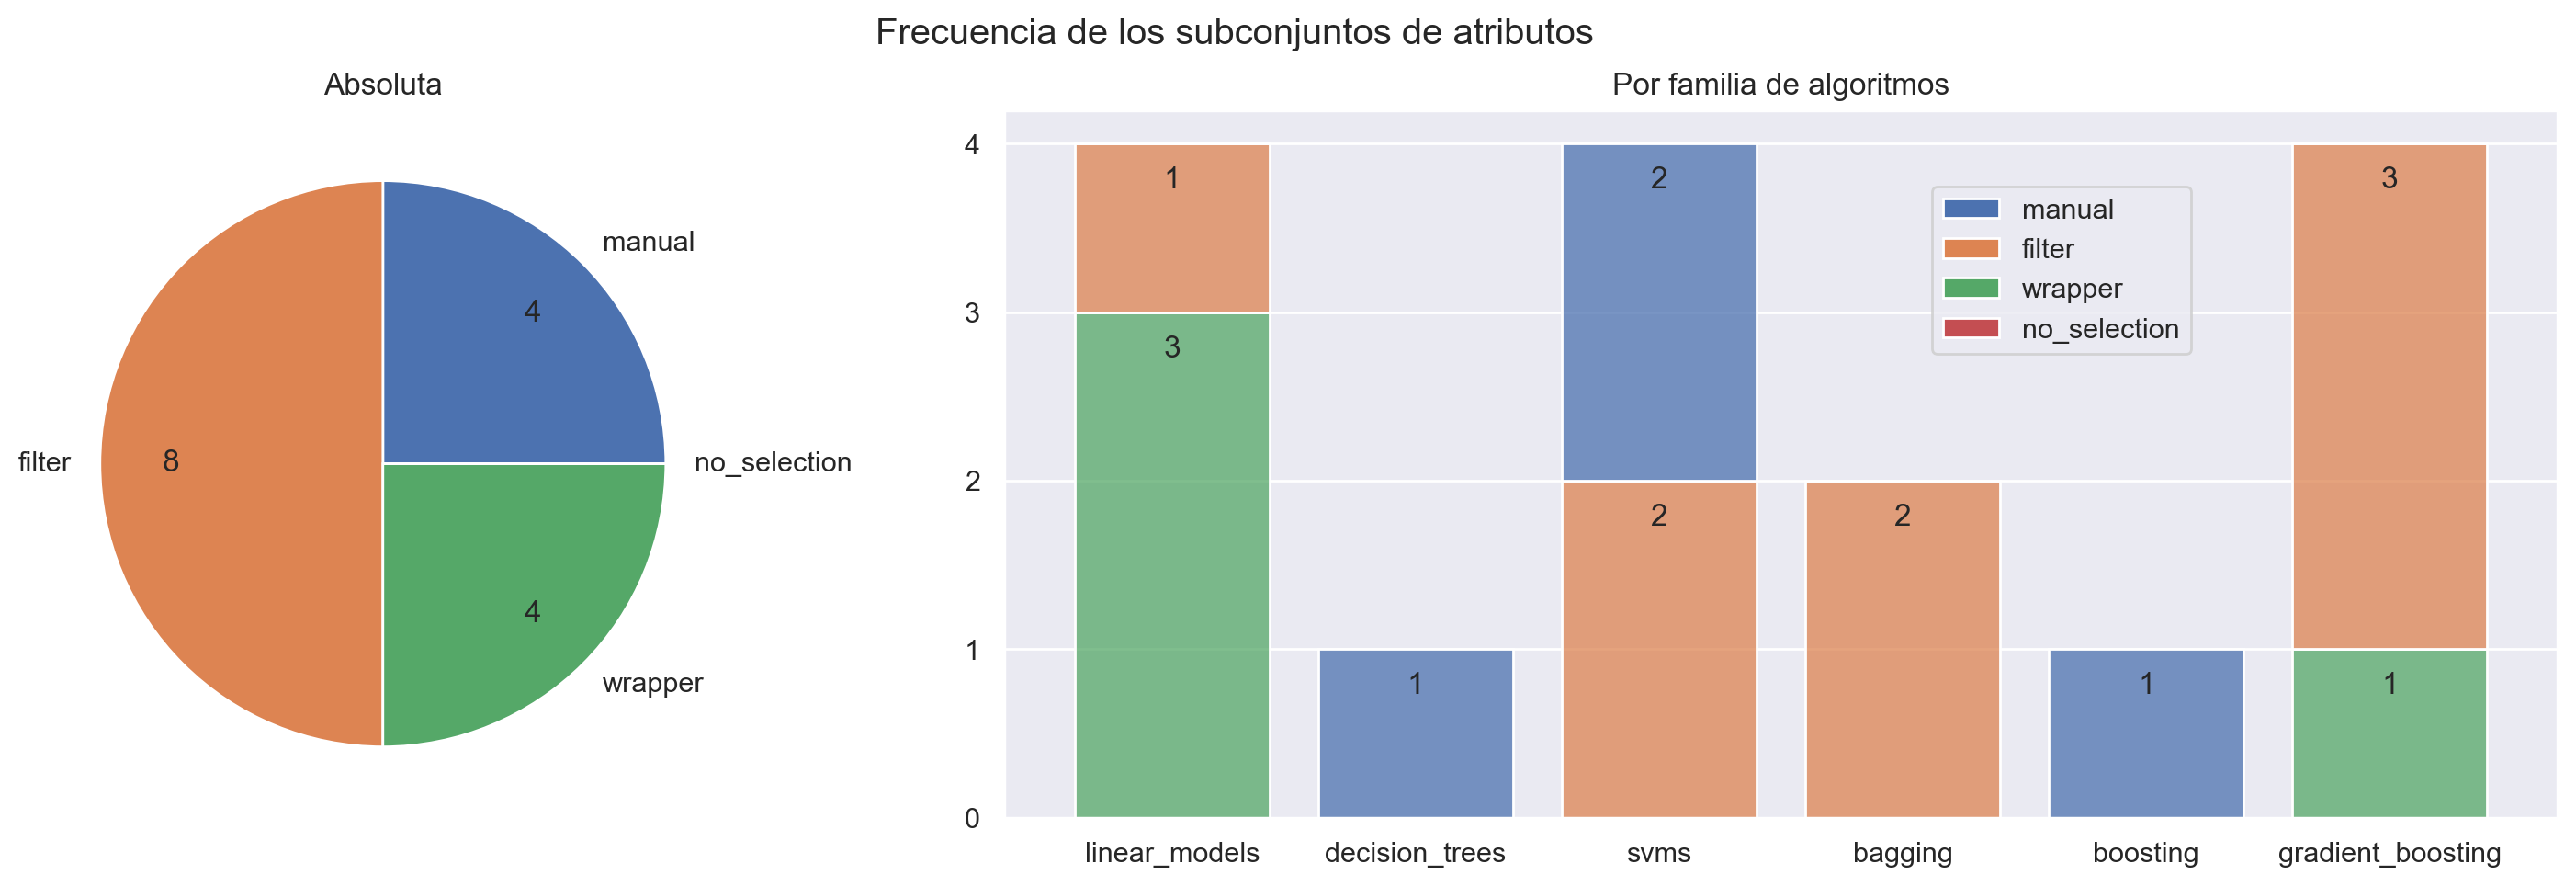

In [65]:
# Create the figures
fig, axs = plt.subplots(1, 2, figsize=(18, 5), width_ratios=[1, 2])

# FIGURE 1 - PIE PLOT ################################################################
axs[0].pie(
    x=list(fs_occurrences.values()),
    labels=fs_occurrences.keys(),
    autopct= lambda x: "{:.0f}".format((x / 100) * len(df_subset_family_per_model)) if x > 0 else "",
    pctdistance=0.75,
)

# FIGURE 2 - BAR PLOT #################################################################
# Ensure that the colors are consistent with the pie plot
sns.histplot(
    data=df_subset_family_per_model,
    x="family",
    hue="feature_subset",
    hue_order=["manual", "filter", "wrapper"],
    stat="count",
    discrete=True,
    shrink=0.8,
    multiple="stack",
    ax=axs[1]
)

# Prettify
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[1].grid(axis="x")

# Change labels and hide them
axs[1].set_yticks([0, 1, 2, 3, 4])

# Add values for each bar
# HARDCODED LABELS - FOR PRETTY-FYING
# Do not do this at home, kids!
hardcoded_labels = [
    ["3", "", "", "", "", "1"],     # 1 - WRAPPER
    ["1", "", "2", "2", "", "3"],   # 2 - FILTER
    ["", "1", "2", "", "1", ""]     # 3 - MANUAL
]

for i, family in enumerate(axs[1].containers):
    axs[1].bar_label(family, padding= -20, labels=hardcoded_labels[i])

#########################################################################################
# Add titles to the plot
fig.suptitle("Frecuencia de los subconjuntos de atributos");
axs[0].set_title("Absoluta");
axs[1].set_title("Por familia de algoritmos");

# Add a legend to the plot
fig.legend(loc=(0.75, 0.6))
axs[1].get_legend().remove();

plt.show();

Respecto a la **frecuencia absoluta**, se observa que:
- Ningún modelo ha elegido el **conjunto completo de atributos** (`no_selection`).
    - Para todos los modelos entrenados, **la selección de atributos** - eliminando información redundante y superflua - **ha mejorado el rendimiento**.
- En general, **la selección automática de atributos** (`filter` y `wrapper`) es de mayor interés que la **selección manual** (`manual`).
    - Concretamente, la selección automática se usa en **12** modelos - frente a los **4** modelos de la selección manual.
    - El uso de **atributos numéricos** - ausentes en `manual` - parece **mejorar el rendimiento** de la mayoría de modelos.
- El **subconjunto de atributos categóricos establecidos a través del EDA** (incluido en `manual` y `filter`) es el más frecuente - con **12** de los **16** modelos utilizándolo.
    - **4** de los modelos ignoran la información geográfica del paciente - `wrapper` no incluye atributos al respecto.

Respecto a la **frecuencia en base a la familia de algoritmos** - y teniendo en cuenta que **el error de las máquinas de vectores de soporte**, `adaboost` y `xgboost` son más elevados, como se verá en la siguiente sección:
- **Modelos lineales**: Todos los modelos han utilizado **subconjuntos con variables numéricas**.
    - Los modelos lineales, de forma nativa, no son capaces de trabajar con variables categóricas y **son susceptibles a números elevados de atributos** - como los obtenidos durante la discretización de variables categóricas. Por tanto, tiene sentido que los modelos **opten por el subconjunto con menor número de atributos categóricos**.
    - El único modelo en utilizar `filter` es `Lasso` - que tiende a **ignorar los atributos irrelevantes**, lo que lo hace más resistente a números excesivos de atributos.
- **Árboles de decisiones**: Se utiliza `manual` - el subconjunto de atributos **más pequeño**.
    - Al tener menos atributos, **se reduce el sobreajuste** - uno de los principales problemas de los árboles de decisión.
- **Máquinas de vectores de soporte**: La distribución está repartida: la mitad de modelos - `svm_poly` y `svm_sigmoid` - utilizan el **conjunto de atributos puramente categórico, `manual`**, mientras que la otra mitad - `svm_lineal` y `svm_rbf` - utilizan **`filter`, **añadiendo cinco atributos numéricos**.
    - Como se verá posteriormente, **el error de las máquinas de vectores de soporte es más elevado** en promedio - aunque los errores de `wrapper` y `no_selection` son en general notablemente más altos que el resto de subconjuntos.
- ***Bagging***: Tanto `Random Forest` como `Extra Trees` utilizan `filter` - una extensión de `manual` con **los atributos categóricos más relevantes** y **cinco atributos numéricos adicionales**.
    - Los modelos de *bagging* son **más resistentes al sobreajuste** y **capaces de reutilizar el mismo atributo varias veces durante la creación de los árboles** - por lo que aumentar el número de atributos no afecta de forma tan negativa como en los árboles sueltos.
- ***Boosting***: *AdaBoost* utiliza el conjunto de atributos `manual` - sin variables numéricas.
    - Al construirse **arboles de decisiones** simples, se puede entender esta selección. Ahora bien, es importante destacar que el rendimiento de *AdaBoost* es, en general, **peor al resto de modelos** - con un error muy similar para los cuatro subconjuntos de atributos.
- ***Gradient Boosting***: Excepto `xgboost` (que utiliza `wrapper`), **todos los modelos utilizan `filter`**.
    - Para modelos **complejos** con alta capacidad computacional, la combinación de **atributos categóricos relevantes** con **atributos numéricos** ofrece el mejor resultado.

### 6.1.2. Error según los subconjuntos de atributos

El objetivo de la búsqueda de hiperparámetros es encontrar el **conjunto de hiperparámetros y atributos** que minimiza el error para cada modelo. 

Concretamente, nos resulta de interés estudiar el comportamiento del **error en base al subconjunto de atributos seleccionado** - con el fin de estudiar si el proceso de selección de atributos realizado durante el preprocesamiento ha resultado util.

El primer paso es **estudiar la distribución de los errores** para cada posible subconjunto de atributos:

In [66]:
# Obtain some error statistics per feature subset
df_training_score_per_subset = (
    df_training_results.groupby("feature_subset")["avg_training_score"]
    .describe()
    .drop(columns="count")
    .sort_values(by="mean")
)
display(df_training_score_per_subset)

,mean,std,min,25%,50%,75%,max
feature_subset,,,,,,,
manual,86.024516,4.290751,82.719684,83.366707,83.666390,88.049036,98.528646
filter,86.158543,5.120575,82.175824,82.936096,83.605279,87.961441,101.561791
wrapper,88.016594,9.304056,82.480794,83.219730,83.478565,88.015498,116.624948
no_selection,88.731562,8.684918,82.795721,83.365377,84.297319,91.750766,114.560716


Haciendo caso a la media, se podría considerar que se pueden dividir los subconjuntos de atributos en **dos grupos claramente divididos**.  Ahora bien, la **desviación estándar** y la gran diferencia entre los valores máximos y mínimos indican que pueden haber **valores extremos** sesgando esta media - algo que apoyan los valores de la **mediana**, más cercanos entre sí.

Para estudiar esta disparidad de valores en más detalle, se representa en una gráfica:
- El **error promedio durante la validación cruzada** para cada par de modelo y subconjunto de atributos - a través de un **gráfico de barras invertido**.
- El **valor promedio del error para cada subconjunto de atributos** - a través de **lineas horizontales**.

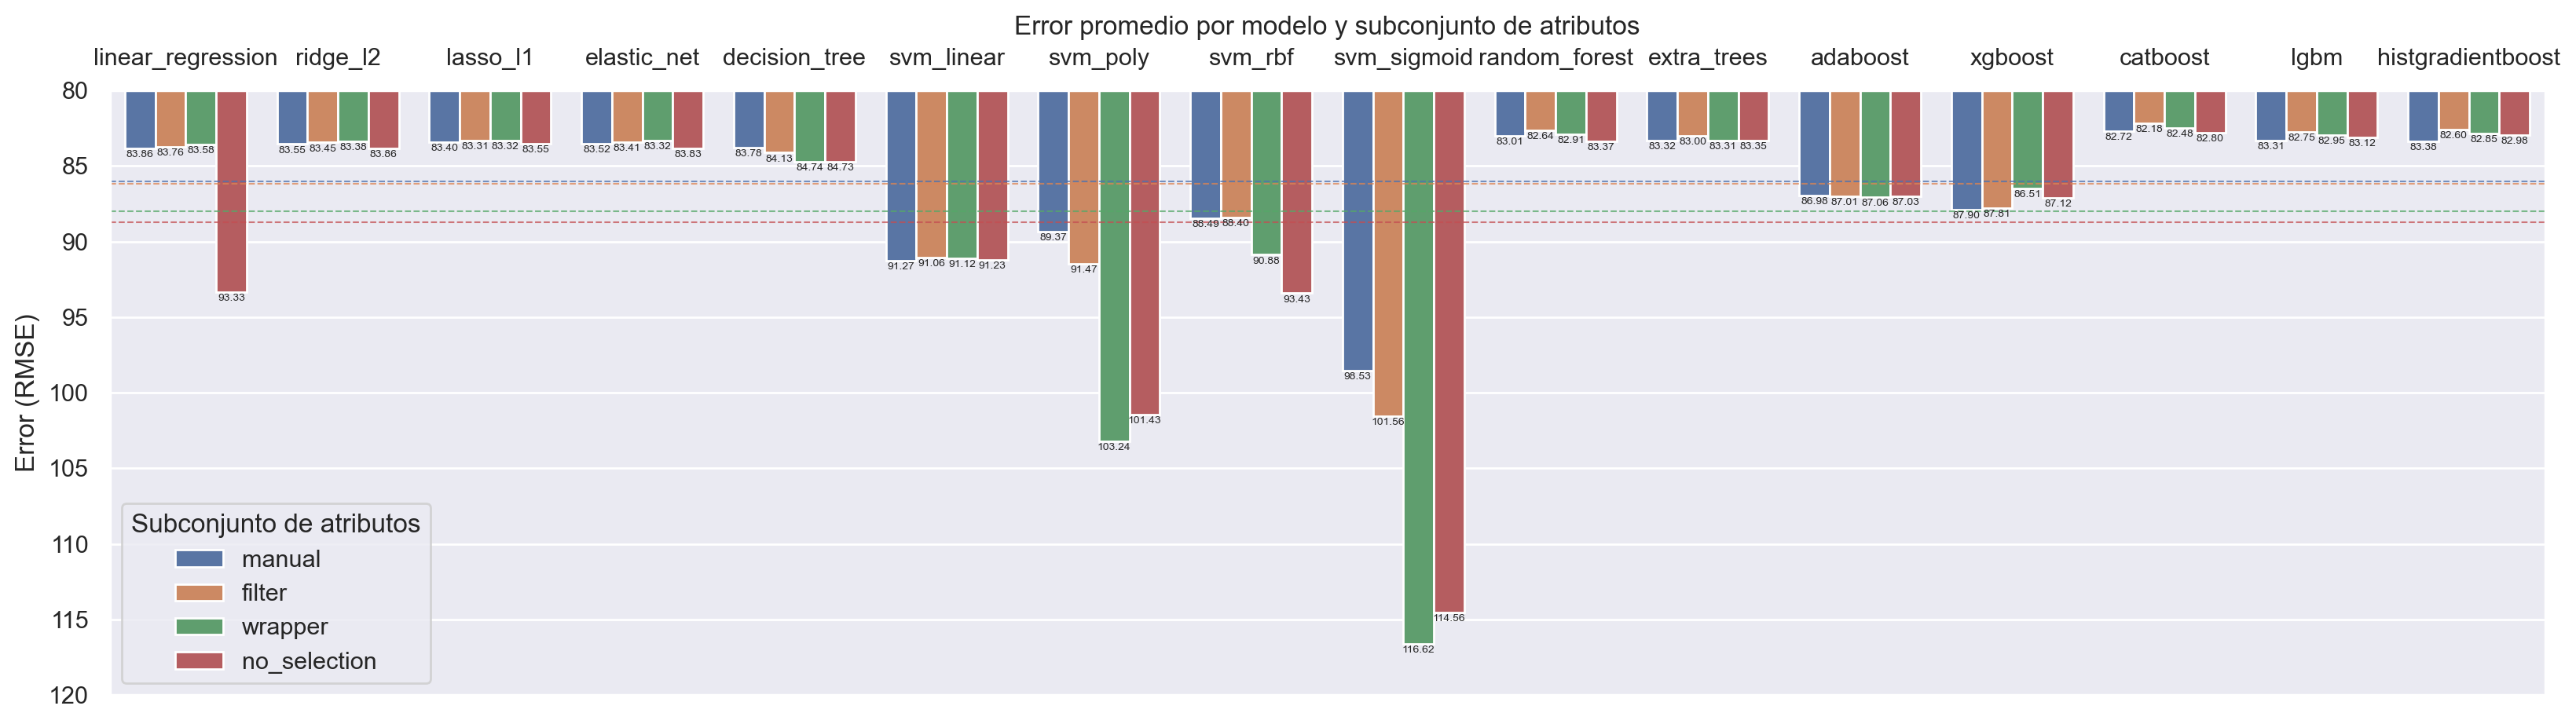

In [67]:
# AVERAGE TRAINING SCORE - BASED ON FEATURE SUBSET ####################################################

# PLOTTING
# Create the figure
fig = plt.figure(figsize=(20, 5));

# Get the four subsets and its colors
feature_subset_colors = list(sns.color_palette())[:4]

# Create a bar plot - using colors based on the feature subset
# NOTE: Since errors are being shown, negative values for the error will be used
ax = sns.barplot(
    data=df_training_results,
    x="model",
    y="avg_training_score",
    hue="feature_subset"
);

# Plot a bar with the average score for each subset of features
for value, color in zip(df_training_score_per_subset["mean"], feature_subset_colors):
    plt.axhline(
        y=value,
        c=color,
        ls="--",
        lw=0.75,
        alpha=0.75,
    );

#########################################################################################################
# LABELS AND LEGENDS

# Add a label to each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=5, padding=-5, fmt="%.2f");

plt.title("Error promedio por modelo y subconjunto de atributos")

# Since no average error is below 80, start the Y axis at 80
ax.set_ylim(120, 80)

# Set the labels and place the ticks on top of the figure
plt.xlabel("")
plt.ylabel("Error (RMSE)")
plt.tick_params(labeltop=True, labelbottom=False)

# Change the legend title
legend = ax.get_legend()
legend.set_title("Subconjunto de atributos")

#########################################################################################################

plt.show();

En la gráfica, se pueden observar **dos grupos de modelos** con valores fuera del promedio:
- Las **máquinas de vectores de soporte** - en sus cuatro versiones estudiadas - tienen **errores promedios mucho más elevados que el resto**, siendo especialmente pronunciados para los subconjuntos *wrapper* y *sin selección*.
- `adaboost`y `xgboost` - dos **ensembles de boosting** - tienen un error ligeramente más alto que el resto de modelos, en contra de lo que podría esperarse al ser modelos más complejos y utilizados.

Por lo demás, la mayoría de modelos parece tener comportamientos similares - aunque su estudio es complicado debido al sesgo introducido por los valores extremos. Para facilitar el estudio, se opta por repetirlo **excluyendo las máquinas de vectores de soporte**:

In [68]:
# Drop SVMs - as they bias the mean values
df_training_results_no_svm = (
    df_training_results[~df_training_results.index.get_level_values(0).str.contains("svm")]
)

df_training_score_per_subset_no_svm = (
    df_training_results_no_svm.groupby("feature_subset")["avg_training_score"]
    .describe()
    .drop(columns="count")
    .sort_values(by="mean")
)
display(df_training_score_per_subset_no_svm)

,mean,std,min,25%,50%,75%,max
feature_subset,,,,,,,
filter,83.837141,1.761979,82.175824,82.724312,83.359813,83.850504,87.813728
wrapper,83.866972,1.474340,82.480794,82.943116,83.316512,83.867871,87.060437
manual,84.061889,1.619701,82.719684,83.319628,83.459064,83.797767,87.903407
no_selection,84.921718,3.023560,82.795721,83.289559,83.691484,85.307134,93.326745


Tras eliminar los modelos con errores más extremos, los **rangos de valores** de los cuatro subconjuntos de valores están más estandarizados - con una **desviación estándar** menor.

Ahora bien, aunque pueda parecer que los valores promedios son muy similares, se pueden observar **dos grupos de subconjuntos**:
- **Subconjuntos con selección (`filter`, `wrapper` y `manual`)**: Los subconjuntos que han realizado una selección de atributos parecen tener **valores promedios inferiores** - con un rango menor (alrededor de $87$ de RMSE).
- **Subconjuntos sin selección (`no_selection`)**: En contraste, los modelos que utilizan el conjunto de atributos completo tienen un **error promedio superior** - con un rango más amplio y una desviación estándar más elevada.

Para comprobar el comportamiento exacto modelo a modelo, se estudia una gráfica donde se representa:
- El **error promedio durante la validación cruzada** para cada par de modelo y subconjunto de atributos - a través de un **gráfico de barras invertido**.
- El **valor promedio del error para cada subconjunto de atributos** - a través de **lineas horizontales**.

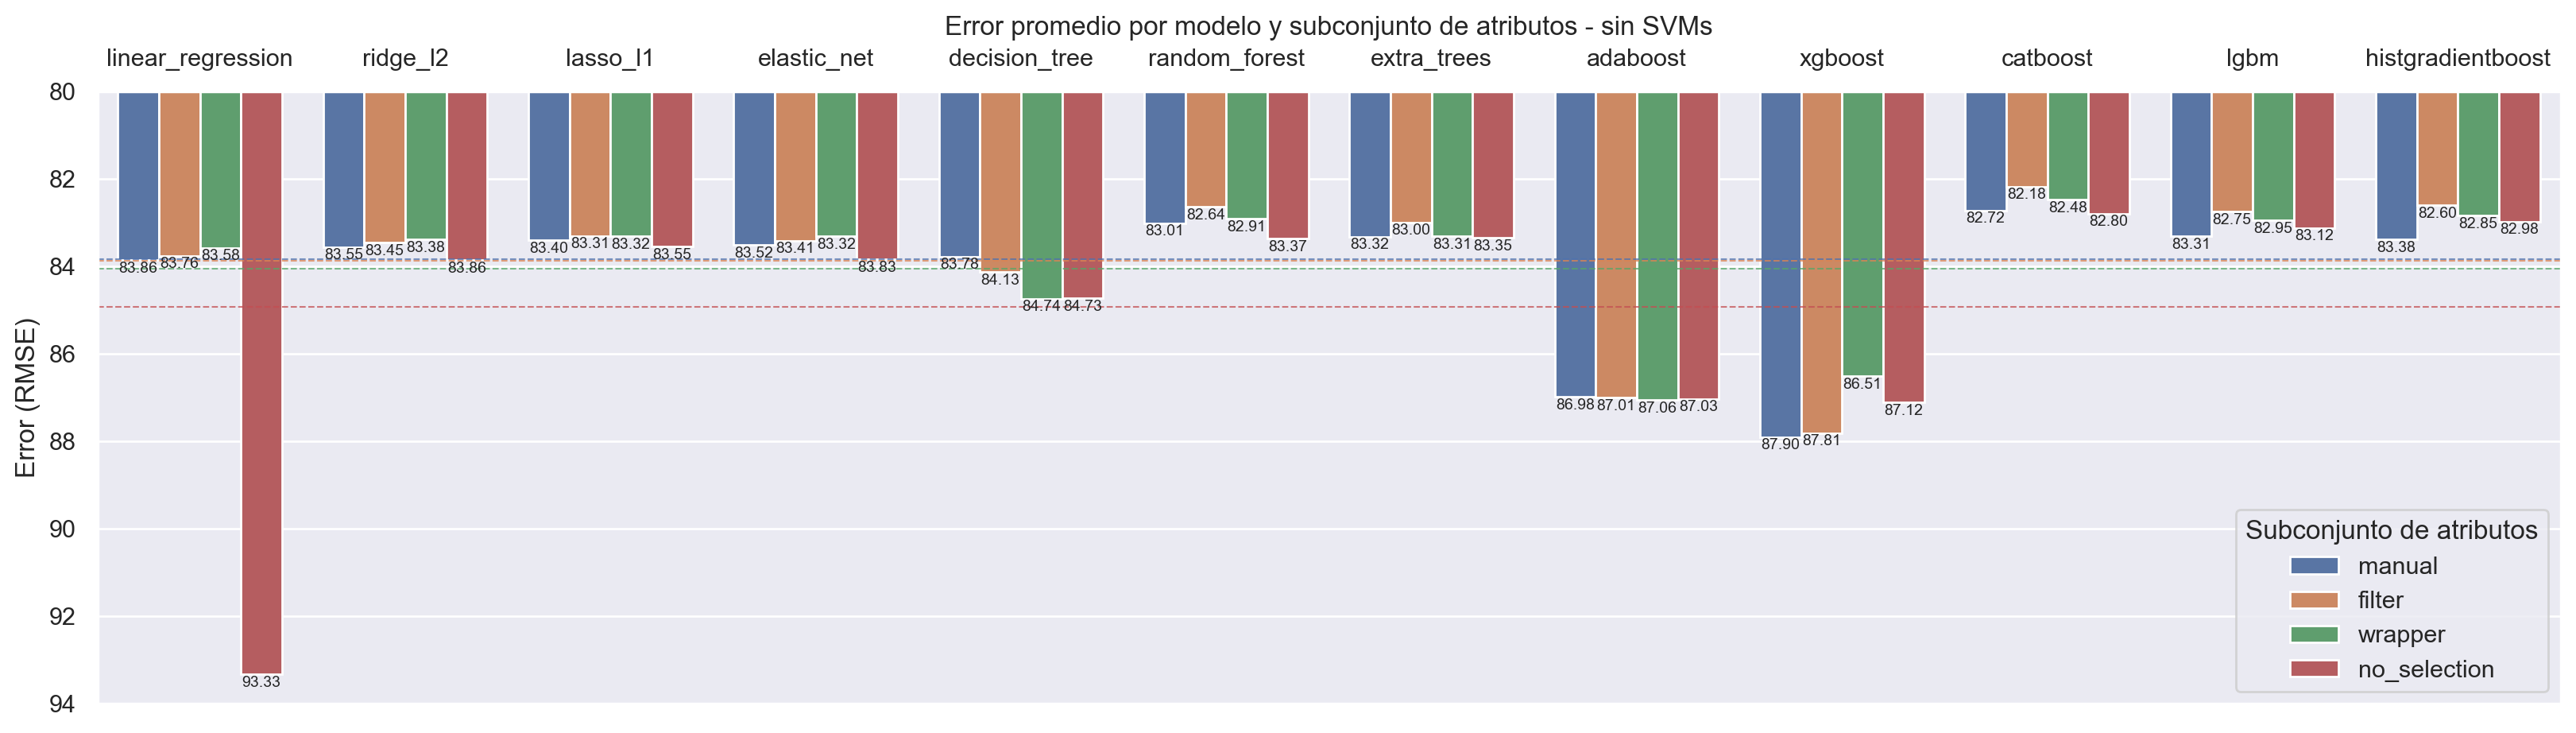

In [69]:
# AVERAGE TRAINING SCORE - BASED ON FEATURE SUBSET, DROPPING SVMs ########################################

# PLOTTING
# Create the figure
fig = plt.figure(figsize=(20, 5));

# Get the four subsets and its colors
feature_subset_colors = list(sns.color_palette())[:4]

# Create a bar plot - using colors based on the feature subset
# NOTE: Since errors are being shown, negative values for the error will be used
ax = sns.barplot(
    data=df_training_results_no_svm,
    x="model",
    y="avg_training_score",
    hue="feature_subset"
);

# Plot a bar with the average score for each subset of features
for value, color in zip(df_training_score_per_subset_no_svm["mean"], feature_subset_colors):
    plt.axhline(
        y=value,
        c=color,
        ls="--",
        lw=0.75,
        alpha=0.75,
    );

#########################################################################################################
# LABELS AND LEGENDS

# Add a label to each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=7, padding=-7, fmt="%.2f");

plt.title("Error promedio por modelo y subconjunto de atributos - sin SVMs")

# Since no average error is below 80, start the Y axis at 80
ax.set_ylim(94, 80)

# Set the labels and place the ticks on top of the figure
plt.xlabel("")
plt.ylabel("Error (RMSE)")
plt.tick_params(labeltop=True, labelbottom=False)

# Change the legend title
legend = ax.get_legend()
legend.set_title("Subconjunto de atributos")

#########################################################################################################

plt.show();

En la gráfica se puede observar que, por lo general, **el error de los modelos utilizando selección de atributos es inferior** - destacando mayoritariamente los **subconjuntos con selección automática (`filter`y `wrapper`)** frente a la **selección manual (`manual`)**. Si se ignoran los modelos con mayor error (**máquinas de vectores de soporte**, `AdaBoost` y `XGBoost`), se puede observar que:
- Los **modelos más simples** tienden a utilizar el conjunto de atributos con **menor número de variables categóricas** - `wrapper`.
- Los **ensembles más complejos** - especialmente si son capaces de trabajar directamente con atributos categóricos, como los modelos de `Gradient Boosting` - tienden a utilizar el conjunto con **más atributos categóricos y numéricos relevantes**, `filter`.
- Por lo general, **los modelos funcionan mejor con algunos atributos numéricos** - `filter` ofrece errore más pequeños frente a `manual`, a pesar de utilizar los mismos atributos categóricos.

Ahora bien, el comportamiento de los subconjuntos de atributos parece depender principalmente de la **familia de modelos sobre los que se utilizan**:

- **Modelos lineales (`linear_regression`, `ridge_l2`, `lasso_l1`, `elastic_net`)**: 
    - El subconjunto de atributos más destacado es **`wrapper`** - teniendo el menor error de forma consistente en todas las variaciones excepto `l1_lasso`, donde se usa `filter`. Tener un menor número de atributos categóricos parece mejorar el rendimiento de los modelos.
    - No utilizar selección de atributos **empeora el resultado** - si bien los modelos lineales con **regularización** se ven menos afectados por la gran cantidad de atributos.
- **Árboles de decisión (`decision_tree`)**:
    - El subconjunto de atributos **`manual`** presenta el menor error - posiblemente al ser el **más pequeño** (con **cinco** atributos), dando menor pie al sobreajuste del arbol de decisión durante el entrenamiento.
    - En contra de lo esperable, **los subconjuntos `wrapper` y `no_selection` tienen prácticamente el mismo error**, superior al de `filter` - a pesar de la diferencia en su tamaño (**10** frente a **150** atributos).
- ***Ensembles* de tipo *bagging* (`random_forest`, `extra_trees`) y *gradient boosting* (`catboost`, `lgbm`, `histgradientboost`)**:
    - Para la mayoría de conjuntos de *ensemble*, el conjunto con menor error es **`filter`** - el subconjunto de atributos con mayor número de atributos **categóricos**, incluyendo además información **numérica**.
    - En contra de lo esperable, utilizar **todos los atributos - `no_selection` - ofrece errores menores que no utilizar ninguna información numérica - `manual`** -, especialmente en los algoritmos de *gradient boosting*. Aun siendo, en general, modelos **complejos** capaces de manejar atributos categóricos, la inclusión de **atributos numéricos** mejora el rendimiento de los modelos.
- ***Ensembles* con errores elevados - *boosting* simple (`adaboost`) y *gradient boosting* (`xgboost`)**:
    - Los modelos presenta **errores más altos de lo esperado** - aproximadamente más de **tres puntos** por encima del error de otros modelos de *ensemble* - tanto **bagging** como **gradient boosting**.
    - `AdaBoost`: A pesar de tener el menor error utilizando el subconjunto `manual`, el error es **constante** independientemente del subconjunto de datos utilizado. Es posible que el problema se deba simplemente a que **el funcionamiento del modelo no se adecua al conjunto de datos adecuadamente**.
    - `XGBoost`: En contra del rendimiento de otros modelos de *Gradient Boosting*, el algoritmo presenta **algunos de los errores más elevados de todos los modelos** - especialmente en los modelos que **más información categórica utilizan**.




### 6.1.3. Tiempo de entrenamiento según los subconjuntos de atributos

Si bien el **error de los modelos entrenados** es la métrica final para la selección de hiperparámetros y subconjuntos de atributos - conocer **cuanto tiempo se necesita para entrenar un modelo dependiendo del subconjunto de atributos** resulta también de interés.

Esto se debe a que **el tiempo de entrenamiento tiene un coste real**, por lo que existe la posibilidad de que **sea más útil utilizar modelos con mayor error pero menor tiempo de entrenamiento** - especialmente para los casos en los que la disminución del error es demasiado pequeña en proporción al aumento del coste.

El primer paso, por tanto, es **estudiar la distribución del tiempo** para cada posible subconjunto de atributos:

In [70]:
# Obtain some error statistics per feature subset
df_training_time_per_subset = (
    df_training_results.groupby("feature_subset")["training_time"]
    .describe()
    .drop(columns="count")
    .sort_values(by="mean")
)
display(df_training_time_per_subset)

,mean,std,min,25%,50%,75%,max
feature_subset,,,,,,,
manual,0.807501,1.034779,0.013685,0.025422,0.133309,1.399458,2.664953
wrapper,1.398200,1.848265,0.016908,0.037182,0.287132,2.126415,6.297638
filter,1.426415,1.757623,0.021472,0.039334,0.389454,3.081097,5.565766
no_selection,6.452439,12.325982,0.170053,0.310227,2.008250,6.110392,49.285902


En este caso, **los rangos amplios de valores son esperables** - los modelos más complejos necesitan más tiempo para su entrenamiento. Aun así, se puede observar que:
- **`manual`**: Siendo el **subconjunto más pequeño** - con únicamente **5 atributos** -, los tiempos de entrenamiento son los más cortos con la menor variación.
- **`wrapper` y `filter`**: Ambos conjuntos tienen **tiempos de entrenamiento parecidos** - en promedio, dos veces más lentos que `manual`, lo que se corresponde con su tamaño (**10 atributos** frente a **5**).
- **`no_selection`**: Al ser el **subconjunto más grande** - con un total de **150 atributos** -, era de esperar que tuviese el **tiempo de entrenamiento más elevado en promedio**. Ahora bien, también presenta el **mayor rango de valores** - llegando a tardar **50 segundos por iteración** para los modelos más lentos, frente a los 6 segundos del siguiente subconjunto.

---

Para estudiar en más detalle la distribución de los tiempos de entrenamiento según el **modelo y subconjunto de atributos**, se representan gráficamente los valores a través de:
- Un **gráfico de barras**, representando el tiempo **final** de entrenamiento para cada subconjunto de atributos y modelos.
- **Lineas horizontales**, representando el tiempo de entrenamiento promedio para cada subconjunto de atributos.

El amplio rango de valores de algunos subconjuntos de atributos - especialmente `no_selection` - pueden hacer que el estudio posterior sea más complicado. Para facilitar el estudio, se crean **dos gráficas**:
- La primera gráfica muestra el **rango completo de tiempos**.
- La segunda gráfica muestra el **rango de tiempos acotado a 10 segundos** - para poder estudiar con más detalle los modelos con tiempo de entrenamiento más bajos.

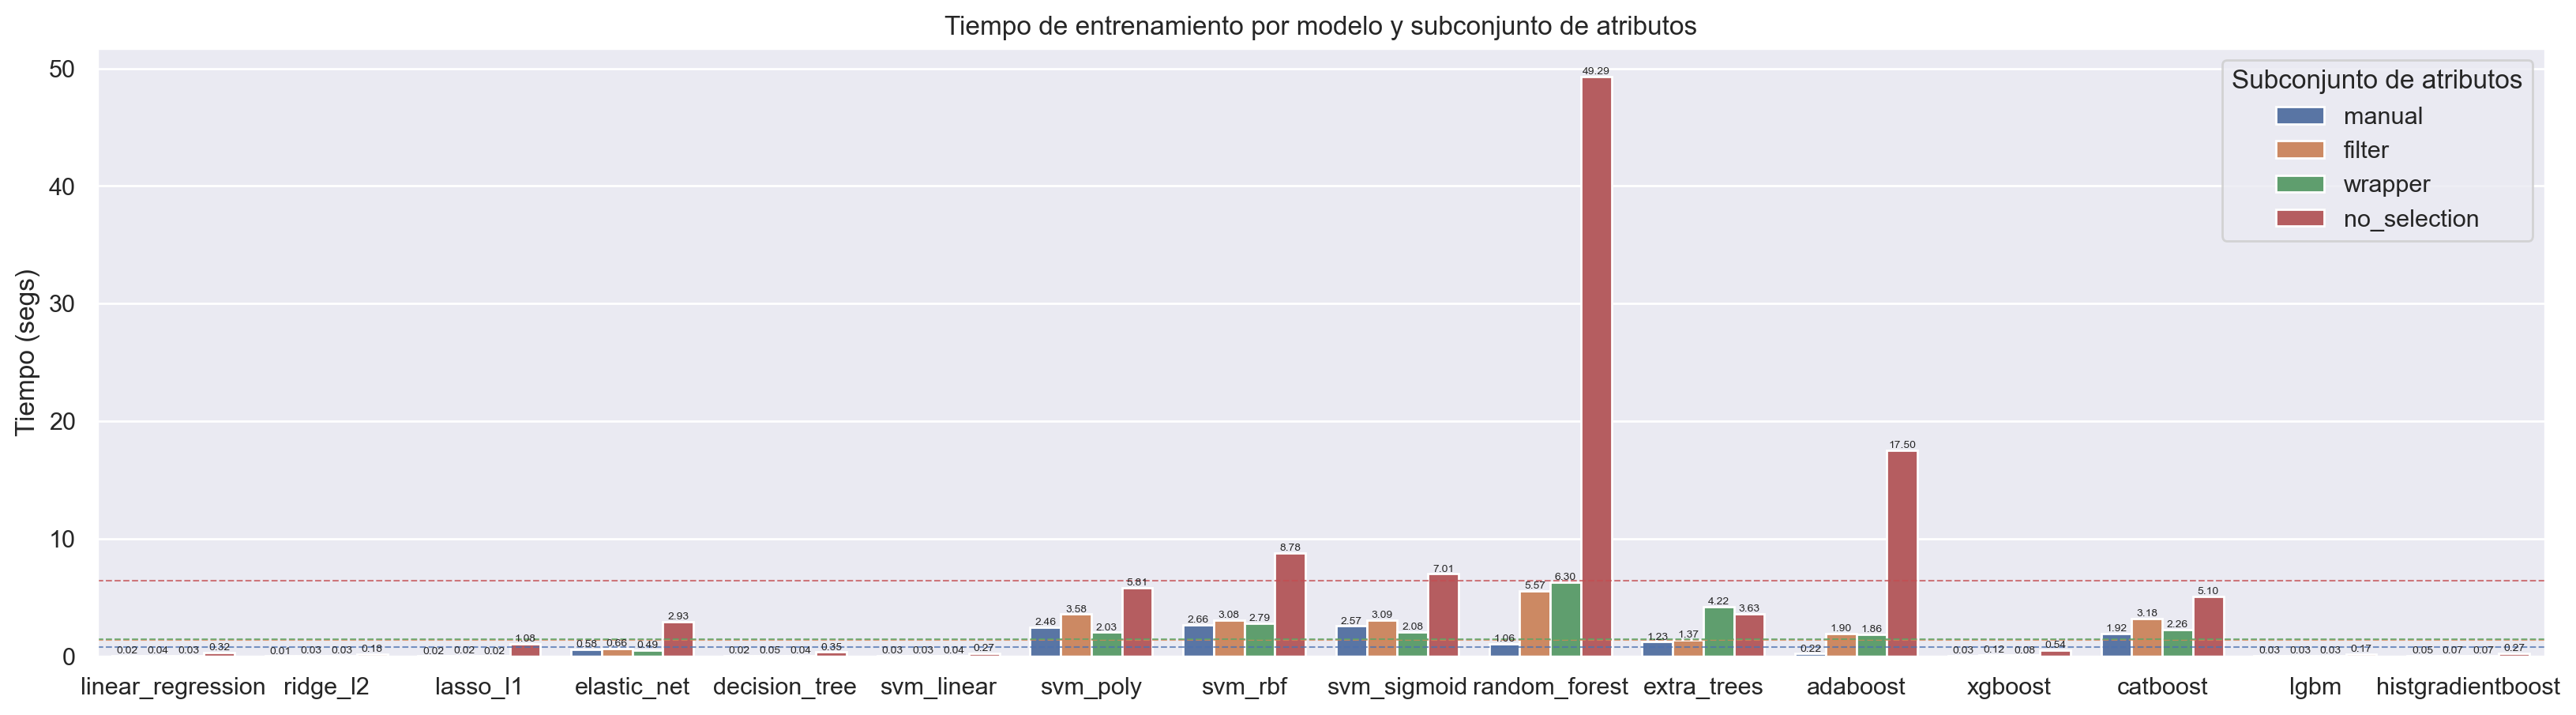

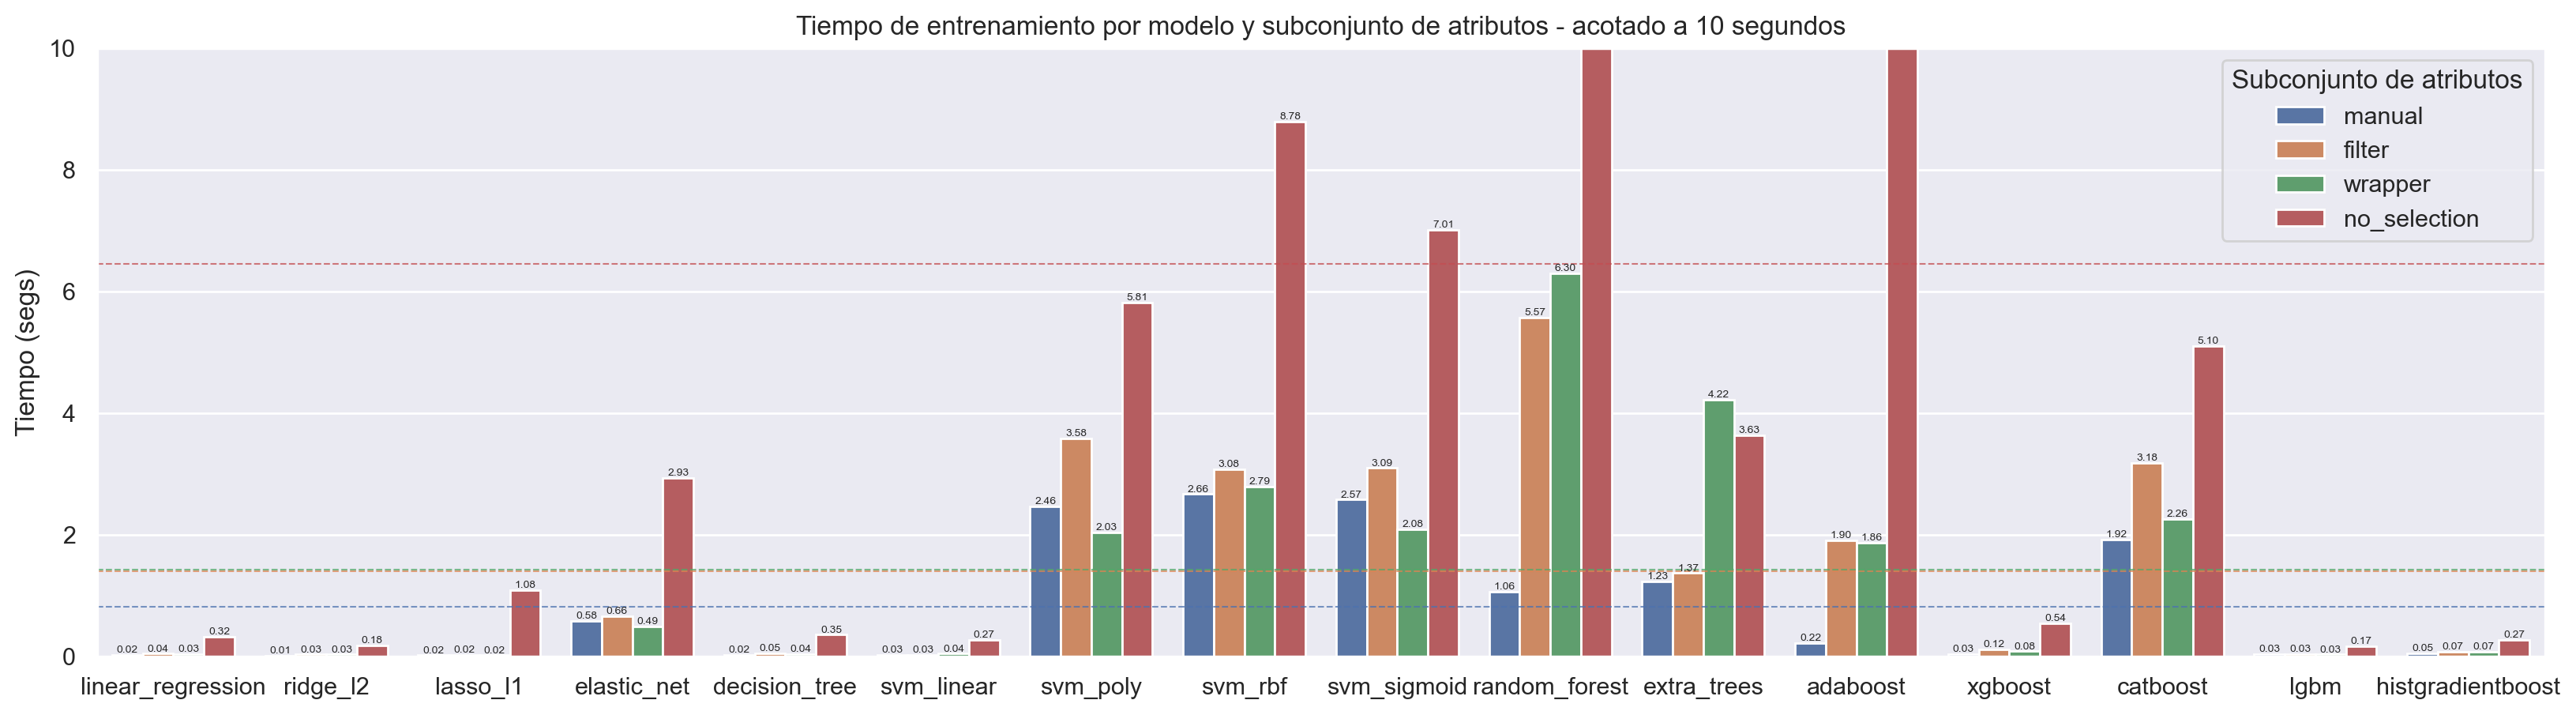

In [71]:
# AVERAGE TRAINING TIME - BASED ON FEATURE SUBSET ####################################################
# FULL AND BOUNDED GRAPHS

# Get the four subsets and its colors
feature_subset_colors = list(sns.color_palette())[:4]

# GRAPH 1 - FULL RANGE ###############################################################################
# Create the figure
fig = plt.figure(figsize=(20, 5));

# Create a bar plot - using colors based on the feature subset
ax = sns.barplot(
    data=df_training_results,
    x="model",
    y="training_time",
    hue="feature_subset"
);

# Plot a bar with the average training time for each subset of features
for value, color in zip(df_training_time_per_subset["mean"], feature_subset_colors):
    plt.axhline(
        y=value,
        c=color,
        ls="--",
        lw=0.75,
        alpha=0.75,
    );

# Add a label to each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=5, fmt="%.2f");
plt.title("Tiempo de entrenamiento por modelo y subconjunto de atributos")

# Set the labels and place the ticks on top of the figure
plt.xlabel("")
plt.ylabel("Tiempo (segs)")

# Change the legend title
legend = ax.get_legend()
legend.set_title("Subconjunto de atributos")

plt.show();

# GRAPH 2 - LIMITED RANGE ###############################################################################
# Create the figure
fig = plt.figure(figsize=(20, 5));

# Create a bar plot - using colors based on the feature subset
ax = sns.barplot(
    data=df_training_results,
    x="model",
    y="training_time",
    hue="feature_subset"
);

# Plot a bar with the average training time for each subset of features
for value, color in zip(df_training_time_per_subset["mean"], feature_subset_colors):
    plt.axhline(
        y=value,
        c=color,
        ls="--",
        lw=0.75,
        alpha=0.75,
    );

# Add a label to each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=5, fmt="%.2f");
plt.title("Tiempo de entrenamiento por modelo y subconjunto de atributos - acotado a 10 segundos")

# Bound the upper time limit to 10 seconds
ax.set_ylim(0, 10)

# Set the labels and place the ticks on top of the figure
plt.xlabel("")
plt.ylabel("Tiempo (segs)")

# Change the legend title
legend = ax.get_legend()
legend.set_title("Subconjunto de atributos")

plt.show();

De forma **global**, se pueden extraer conclusiones similares a las obtenidas directamente desde los rangos:
- El **número de atributos** influye directamente en el tiempo de entrenamiento:
    - Salvo excepciones, los modelos más rápidos de entrenar son los que utilizan el **subconjunto de atributos más pequeño** - `manual`, con 5 atributos.
    - A pesar de tener el mismo tamaño - 10 atributos -, `filter` y `wrapper` tienden a tener **tiempos de entrenamiento distintos**. Ahora bien, **varía cual es más lento dependiendo de la familia**.
    - Los modelos entrenados con el **conjunto de atributos completo** (`no_selection`) requieren, en general, **tiempos de entrenamiento sustancialmente mayores** a los modelos entrenados con selección de atributos - pudiendo necesitar hasta **diez veces más tiempo**.
- Salvo excepciones marcadas, **conforme aumenta la complejidad del modelo aumenta el tiempo de entrenamiento**.

Si se subdivide este análisis por **familias de modelos**:

- **Modelos simples: lineares (`linear_regression`, `ridge_l2`, `lasso_l1`, `elastic_net`) y árboles de decisiones (`decision_tree`)**:
    - Al ser los modelos más simples, **todos los subconjuntos de atributos obtenidos por selección** (`manual`, `filter` y `wrapper`) tienen tiempos de entrenamiento muy bajos y parecidos entre sí. **`no_selection`** es el único conjunto con tiempo de entrenamiento más elevado.
    - `elastic_net` requiere un tiempo de entrenamiento notablemente más elevado que el resto de modelos simples, en contra de lo que podría esperarse al ser un modelo linear.
- **Máquinas de vectores de soporte (`svm_linear`, `svm_poly`, `svm_rbf`, `svm_sigmoid`)**:
    - `svm_linear` con su kernel especializado presenta **tiempos de entrenamiento muy rápidos**, con comportamientos muy similares al resto de modelos simples.
    - En contraste, los **kernels complejos** (`svm_poly`, `svm_rbf` y `svm_sigmoid`) presentan **tiempos de entrenamiento más pronunciados** - si bien no son los modelos más lentos entrenados.
    - En los modelos de máquina de vector de soporte, `wrapper` tiende a ser el subconjunto más rápido. Esto puede deberse a que es el **subconjunto con menor número de atributos categóricos** - 4, frente a los 5 de `manual` y `filter` -, lo que se traduce en **menor cantidad de atributos tras la discretización con `one-hot`**.
- ***Ensembles* simples: bagging (`random_forest` y `extra_trees`) y boosting (`adaboost`)**:
    - `random_forest` parece escalar de forma muy pobre con el número de atributos. - presentando los **tiempos de entrenamiento más lentos de todos los modelos**. 
        - El modelo más lento (`random_forest` con `no_selection`) requiere un total de **50 segundos** para su entrenamiento, más de **dos veces más tiempo** que el siguiente modelo. El modelo 
        - La diferencia de tiempo entre los subconjuntos de atributos es, a su vez, extremadamente pronunciada - pasando de **6 segundos** para `filter` / `wrapper` a **50 segundos**.
    - `adaboost` presenta un comportamiento **similar** a `random_forest`, si bien algo menos pronunciado, siendo el **segundo modelo más lento** - con **18 segundos** para `no_selection` y **2 segundos** para `filter` / `wrapper`.
    - En contra de lo ocurrido con el resto de *ensembles*, `extra_trees` presenta **tiempos de entrenamiento similares a las máquinas de vectores de soporte**. Ahora bien, el modelo más lento se ha entrenado con **`wrapper`** - y no el conjunto completo de atributos, como se podría esperar.
- ***Ensembles* de *Gradient Boosting* (`xgboost`, `catboost`, `lgbm`, `histgradientboost`)**:
    - Frente a lo que se podría esperar por la complejidad de los modelos y al comportamiento del resto de *ensembles*, **los tiempos de entrenamiento de la mayoría de *ensembles* de *Gradient Boosting*** (`xgboost`, `lgbm` y `histgradientboost`) son **muy bajos**, similares a los tiempos de entrenamiento de los modelos simples. Esto se debe al **uso de la GPU durante el entrenamiento** - lo que hace que **no merezca la pena el uso de modelos menos complejos** en presencia de aceleradores gráficos.
    - `catboost` tiene **tiempos de entrenamiento más elevados** - si bien siguen siendo razonables para el conjunto de datos. Esta diferencia puede deberse meramente a **detalles de implementación**.

---

<a id="section6-2"></a>

## 6.2. Estadísticas de los modelos seleccionados

Tras el **ajuste de hiperparámetros**, el siguiente paso de la experimentación - la **validación de modelos** - es estudiar el **rendimiento real de cada modelo** sobre un conjunto de datos no estudiado previamente, para poder seleccionar **el modelo final** - es decir, el modelo con el **menor *RMSE*** de entre todos los estudiados.

Para cada modelo seleccionado, se han almacenado los **siguientes atributos**:
- **Hiperparámetros**: Tanto el propio conjunto de hiperparámetros (`hyperparameters`) como el **subconjunto de atributos** seleccionado (`feature_subset`).
- **Error**: Tanto el error promedio durante el entrenamiento (`avg_training_score`) como el **error de validación** (`validation_score`) utilizado para la selección final.
- **Tiempo de entrenamiento**: Tanto el tiempo de entrenamiento (`training_time`) como el **tiempo de predicción** (`validation_time`).

En total, se tienen estadísticos de **16 modelos estudiados**:

In [72]:
# Add the model family to each trained model instance
df_validation_results_family = (
    df_validation_results.assign(
        family = df_validation_results.index.map(lambda x: family_per_model[x])
    )
)

display(df_validation_results_family)

,feature_subset,hyperparameters,training_time,avg_training_score,validation_time,validation_score,family
model,,,,,,,
linear_regression,wrapper,{'preprocessing__cat__oh__min_frequency': None},0.030788,83.577521,0.000000,82.649445,linear_models
ridge_l2,wrapper,{'preprocessing__cat__oh__min_frequency': None...,0.028604,83.379609,0.012679,82.547238,linear_models
lasso_l1,filter,{'preprocessing__cat__oh__min_frequency': None...,0.021472,83.306290,0.000000,82.407230,linear_models
elastic_net,wrapper,{'preprocessing__cat__oh__min_frequency': None...,0.493028,83.316375,0.000000,82.439290,linear_models
decision_tree,manual,{'preprocessing__cat__oh__min_frequency': 0.00...,0.020879,83.778086,0.000000,82.936198,decision_trees
svm_linear,filter,{'preprocessing__cat__oh__min_frequency': 0.00...,0.027294,91.055673,0.017313,88.775163,svms
svm_poly,manual,{'preprocessing__cat__oh__min_frequency': 0.00...,2.461194,89.367206,0.506688,88.231839,svms
svm_rbf,filter,{'preprocessing__cat__oh__min_frequency': 0.00...,3.077049,88.404581,0.650950,87.488414,svms
svm_sigmoid,manual,{'preprocessing__cat__oh__min_frequency': 0.02...,2.573835,98.528646,0.588375,101.272074,svms


*(NOTA: Para facilitar el estudio posterior, se ha añadido información sobre la **familia de modelos** asociada a cada algoritmo al DataFrame)*

---

Ahora bien, igual que ocurrió durante el estudio del apartado anterior, no tiene sentido estudiar todos los posibles estadísticos:
- Ya se ha realizado un estudio previo sobre los **subconjuntos de atributos** y el **entrenamiento** de los modelos:
    - `feature_subset`.
    - `avg_training_score`.
    - `training_time`.
- El **tiempo de predicción** para obtener resultados es **similar y muy bajo** para todos los modelos - por lo que no es relevante su estudio.

Por tanto, el estudio realizado en este apartado se va a centrar en estudiar **los modelos seleccionados** y sus características:
- Los **hiperparámetros** seleccionados - las características de cada familia de modelos seleccionadas finalmente.
- El **error de validación** - el error de los modelos entrenados frente a un conjunto de datos no estudiado previamente.

### 6.2.1. Hiperparámetros elegidos por familia de modelos

Resulta de interés estudiar, tras el proceso de entrenamiento, los **conjuntos de hiperparámetros** elegidos para cada modelo - con el fin de comprobar si se puede extraer algún **conocimiento adicional sobre el comportamiento de los modelos** a partir de esta selección.

Ahora bien, realizar un estudio exhaustivo de los dieciseis modelos entrenados sería excesivo - por lo que se opta por **desglosar el estudio por familias de modelos** en su lugar, comprobando el comportamiento general de cada familia. Además, se opta por **estudiar únicamente los hiperparámetros más significativos**.

Para esto, se almacena en un diccionario `hyperparameter_dfs` un **DataFrame con hiperparámetros desglosados** de cada familia de modelos:

In [73]:
# Store a dataframe of unrolled hyperparameters for each model family
hyperparameter_dfs = {}

for family in model_families:
    hyperparameter_dfs[family] = (

        # STEP BY STEP
        pd.DataFrame.from_records(                                                                                      # 1 - Build a DataFrame from the dictionaries contained within 
                                                                                                                        #     df_validation_results
            df_validation_results_family[df_validation_results_family["family"]==family]["hyperparameters"]             # 1.A. - Filter the DataFrame by family
            .apply(lambda x: json.loads(                                                                                # 1.B. - Dictionaries are stored as strings - convert them back into a dictionary
                                                                                                                        #        via JSON
                s=x.replace("\'", "\"").replace("None", "0")                                                            #        (NOTE - some replacement of special characters must be done)
            ) if not x.startswith("OrderedDict") else eval(x)),                                                         #        (NOTE 2 - Some of the dictionaries may be stored as OrderedDicts,
                                                                                                                        #         try to evaluate them as Python expressions instead)
            index=df_validation_results_family[df_validation_results_family["family"]==family].index
        ).assign(                                                                                                       # 2 - Add back the errors and feature subsets for context
            error=lambda df: df.index.map(lambda x: df_validation_results.loc[x, "validation_score"]),
            feature_subset= lambda df: df.index.map(lambda x: df_validation_results.loc[x, "feature_subset"])
        )             
    )

#### Modelos lineales - `linear_regression`, `ridge_l2`, `lasso_l1` y `elastic_net`

In [74]:
hyperparameter_dfs["linear_models"]

,preprocessing__cat__oh__min_frequency,regression__alpha,regression__l1_ratio,error,feature_subset
model,,,,,
linear_regression,0,NaN,NaN,82.649445,wrapper
ridge_l2,0,1.000,NaN,82.547238,wrapper
lasso_l1,0,0.100,NaN,82.407230,filter
elastic_net,0,0.001,0.5,82.439290,wrapper


- **No se realiza agrupación de valores infrecuentes categóricos (`oh__min_frequency`):** Para el rendimiento de los modelos, se opta por **no realizar ningún tipo de agrupamiento**, aun con la posibilidad de sobreajuste que podría inducir en los modelos.
- El **peso de regularización** depende del tipo de modelo:
    - `Ridge` ($\alpha=1$): Ridge funciona mejor con modelos con correlaciones y atributos significativos, teniendo el **mayor factor de regularización**.
    - `Lasso` ($\alpha=0.1$): Lasso funciona mejor con modelos de muchos atributos irrelevantes - por lo que su **menor regularización** se puede explicar por la selección de atributos.
    - `ElasticNet` ($\alpha=0.001$) tiene un valor sorprendentemente bajo de regularización - comportándose de **forma similar a una regresión lineal estándar**.
- `ElasticNet` funciona como **intermedio entre `Ridge` y `Lasso`** - con un valor de `l1_ratio=0.5`, ambos factores de regularización tienen el mismo peso final.

#### Arboles de decisión - `decision_tree`

In [75]:
hyperparameter_dfs["decision_trees"]

,preprocessing__cat__oh__min_frequency,regression__criterion,regression__max_depth,regression__min_samples_leaf,regression__min_samples_split,error,feature_subset
model,,,,,,,
decision_tree,0.002966,friedman_mse,9,40,33,82.936198,manual


- **No se realiza agrupación de valores infrecuentes categóricos (`oh__min_frequency`):** Para el rendimiento de los modelos, se opta por **no realizar ningún tipo de agrupamiento** - a pesar del **especial riesgo de sobreajuste** de los árboles de decisión profundos.
- Se opta por construir **árboles profundos** ($max\_depth=9$), pero con **restricciones a la hora de ramificar ($min\_samples\_leaf=40$, $min\_samples\_split=33$)**.
    - Los árboles que se construyen son profundos - pero **únicamente si hay suficientes atributos para justificar las ramificaciones**, limitando de cierta manera el sobreajuste.
    - El **error en validación** es más alto que el de otros modelos como la regresión lineal, lo que indica que pese a esto **se ha sobreajustado el arbol**.

#### Máquinas de vectores de soporte - `svm_linear`, `svm_poly`, `svm_rbf`, `svm_sigmoid`

In [76]:
hyperparameter_dfs["svms"]

,preprocessing__cat__oh__min_frequency,regression__C,regression__epsilon,regression__tol,regression__degree,error,feature_subset
model,,,,,,,
svm_linear,0.005068,71.041154,0.266333,0.041822,NaN,88.775163,filter
svm_poly,0.001871,32.751436,0.030225,0.079823,4.0,88.231839,manual
svm_rbf,0.005068,71.041154,0.266333,0.041822,NaN,87.488414,filter
svm_sigmoid,0.029693,1.498225,0.358255,0.000123,NaN,101.272074,manual


- **No se realiza agrupación de valores infrecuentes categóricos (`oh__min_frequency`):** Para el rendimiento de los modelos, se opta por **no realizar ningún tipo de agrupamiento**.
    - Ahora bien, para `svm_sigmoid` se observa cierto grado de agrupamiento - agrupando los **atributos con menos del 3% de frecuencia absoluta**.
- Por lo general, **la regularización `L2` (error cuadrático) de los modelos es inferior a la estándar** - dando mayor peso a los atributos:
    - Tanto en modelos **lineales (`svm_linear`)** como **gaussianos (`svm_rbf`)**, la regularización es aproximadamente **70 veces inferior** a la regularización estándar.
    - En modelos **polinomiales (`svm_poly`)**, la regularización es más alta - **33 veces inferior** a la estándar.
    - El único modelo con **regularización estándar** es el **modelo sigmoidal (`svm_sigmoid`)**, con un valor **1.5 veces inferior**.
- Para la mayoría de modelos, **la tolerancia del vector de soporte es más alta del valor por defecto** - con valores en el rango de $[0.25 - 0.35]$, frente al valor por defecto de **$0.1$**.
    - Para las máquinas **polinómicas (`svm_poly`)**, por contraste se utiliza **una tolerancia inferior, de $0.03$** - pudiendo deberse a que **la función polinómica sobreajusta más a los datos**.

#### *Ensembles* de *bagging* - `random_forest`, `extra_trees`

In [77]:
hyperparameter_dfs["bagging"]

,preprocessing__cat__oh__min_frequency,regression__max_depth,regression__max_features,regression__min_samples_split,regression__n_estimators,error,feature_subset
model,,,,,,,
random_forest,0.0001,17,0.647413,50,200,81.996809,filter
extra_trees,0.0001,16,0.300000,50,106,82.190387,filter


- **No se realiza agrupación de valores infrecuentes categóricos (`oh__min_frequency`):** Para el rendimiento de los modelos, se opta por **realizar el menor agrupamiento posible** - inferior al $0.01\%$.
- Los arboles utilizados por ambos modelos son **profundos, pero acotados** - aunque sea posible ramificar más, ambos modelos se acotan a profundidades de **aproximadamente 15 niveles**.
- Para aumentar la generalización y evitar el sobreajuste inherente a los árboles, **ambos modelos limitan el subconjunto de atributos por arbol**:
    - `Random Forest` utiliza el **60%** de los atributos en cada arbol entrenado.
    - `Extremely Random Trees (Extra Trees)` utiliza el **30%** de los atributos en cada arbol entrenado.
- **`Random Forest` utiliza un número de árboles sustancialmente superior a `Extra Trees`** - utilizando aproximadamente el doble (**206** árboles frente a **100** árboles)

#### *Ensembles* de *boosting* - `adaboost`

In [78]:
hyperparameter_dfs["boosting"]

,preprocessing__cat__oh__min_frequency,regression__learning_rate,regression__n_estimators,error,feature_subset
model,,,,,
adaboost,0.0001,0.0001,50,86.467954,manual


- **No se realiza agrupación de valores infrecuentes categóricos (`oh__min_frequency`):** Para el rendimiento de los modelos, se opta por **realizar el menor agrupamiento posible** - inferior al $0.01\%$.
- El modelo ha optado por **aprender lento (`learning_rate=0.0001`)** y **aprender pocos modelos (`n_estimators=50`)** - lo que **puede explicar el bajo rendimiento del modelo**.
    - Es posible que, de realizar la búsqueda de hiperparámetros con otras semillas, se hubieran encontrado **hiperparámetros que optimizasen mejor el rendimiento**.

#### *Ensembles* de *gradient boosting* - `xgboost`, `catboost`, `lgbm`, `histgradientboost`

Pese a haberse configurado hiperparámetros similares para los cuatro modelos, los nombres de cada hiperparámetro varían entre ellos. Por tanto, **se muestran por separado los cuatro modelos**:

In [79]:
for model in hyperparameter_dfs["gradient_boosting"].index:
    display(hyperparameter_dfs["gradient_boosting"].loc[model].to_frame().dropna().transpose())

,regression__colsample_bytree,regression__gamma,regression__learning_rate,regression__max_depth,regression__n_estimators,regression__subsample,error,feature_subset
xgboost,0.464536,9132.971873,0.029685,4,153.0,0.3,87.091459,wrapper


,regression__learning_rate,regression__max_depth,regression__iterations,regression__l2_leaf_reg,regression__random_strength,error,feature_subset
catboost,0.04893,8,200.0,5.637923,2.0,81.609031,filter


,regression__learning_rate,regression__max_depth,regression__min_data_in_leaf,regression__num_iterations,regression__num_leaves,error,feature_subset
lgbm,0.196746,3,79.0,74.0,10.0,81.778215,filter


,regression__learning_rate,regression__max_depth,regression__max_features,regression__max_iter,regression__max_leaf_nodes,regression__min_samples_leaf,error,feature_subset
histgradientboost,0.134308,8,0.491392,50.0,9.0,20.0,81.945765,filter


En este caso, **los propios modelos gestionan los atributos categóricos y sus agrupamientos**. Respecto al resto de hiperparámetros, se suelen observar **grupos** - modelos con comportamientos similares, si bien difieren dependiendo de los atributos:

- **Profundidad de los árboles**: No parece haber una correlación directa entre **error y profundidad**.
    - `xgboost` y `lgbm`: Arboles **pequeños** - con profundidades entre 3 y 4.
    - `catboost` y `histgradientboost`: Arboles **más profundos** - con profundidades de 8.
        - A pesar de basarse la implementación de `histgradientboost` en `lgbm`, **se observan diferencias en los hiperparámetros elegidos**.
- **Ratio de aprendizaje**: Por lo general, **los ratios de aprendizaje son más rápidos que los valores por defecto de los modelos** - apuntando a **números más bajos de modelos** con **mayor peso sobre el resultado final**.
    - El único modelo con un ratio más bajo que su valor por defecto es `xgboost` - siendo, a su vez, el modelo con **peores resultados***.
- **Número de árboles entrenados**:
    - `xgboost` y `catboost` entrenan un mayor número de árboles (alrededor de **200**), teniendo a su vez **ratios de aprendizaje más bajos**.
    - En contra, `lgbm` y `histgradientboost` - con ratios de aprendizaje más altos - optan por  **un número reducido de árboles** (alrededor de **50**).

#### Conclusiones generales

Aun con los hiperparámetros variados aprendidos para cada familia de modelos, se pueden extraer algunas **conclusiones generales** del comportamiento de todos los modelos:
- **El agrupamiento de atributos categóricos no mejora el rendimiento de los modelos**: Para los **12** modelos en los que se ha ajustado el agrupamiento como hiperparámetro, **todos los modelos han optado por no agrupar** (o reducir al mínimo el agrupamiento)
    - Pese a incluirse dicho hiperparámetro ante el posible **sobreajuste** a las instancias infrecuentes, los modelos parecen funcionar mejor al incluir dichos modelos - o, en su defecto, no deterioran el rendimiento.
- **No existe un consenso en el comportamiento de los árboles entrenados**:
    - La **profundidad** de los árboles, el **número de árboles entrenado** o el **subconjunto de atributos utilizado por árbol** oscilan dependiendo del *ensemble* entrenado - sin correlación aparente con el error de los modelos. Por tanto, **los modelos más complejos no parecen tener siempre mejor rendimiento**.
- **La selección de subconjunto de atributos reducidos tiene una influencia significativa sobre el rendimiento de los modelos** - algo estudiado en el apartado anterior, pero reflejado sobre todo en **factores de regularización**.

---

### 6.2.2. Error de los modelos entrenados

El principal objetivo de la validación es la **evaluación del rendimiento real de los modelos** - estudiando su rendimiento (a través de un **error *RMSE***) sobre un **conjunto de datos no estudiado previamente** - con el fin de seleccionar el **mejor modelo disponible** para ser utilizado posteriormente, posiblemente en producción.

Aun así, resulta de interés estudiar el **comportamiento real de todos los modelos** para estudiar el comportamiento de los modelos propuestos y evaluar su rendimiento entre sí. Para esto, se opta por utilizar un **gráfico de barras**, donde:
- El **error** de cada modelo se representa a través de una barra - con **errores mayores representando peores modelos**.
- La **familia de algoritmos** a la que pertenece cada modelo se representa a través del **color de la barra**.

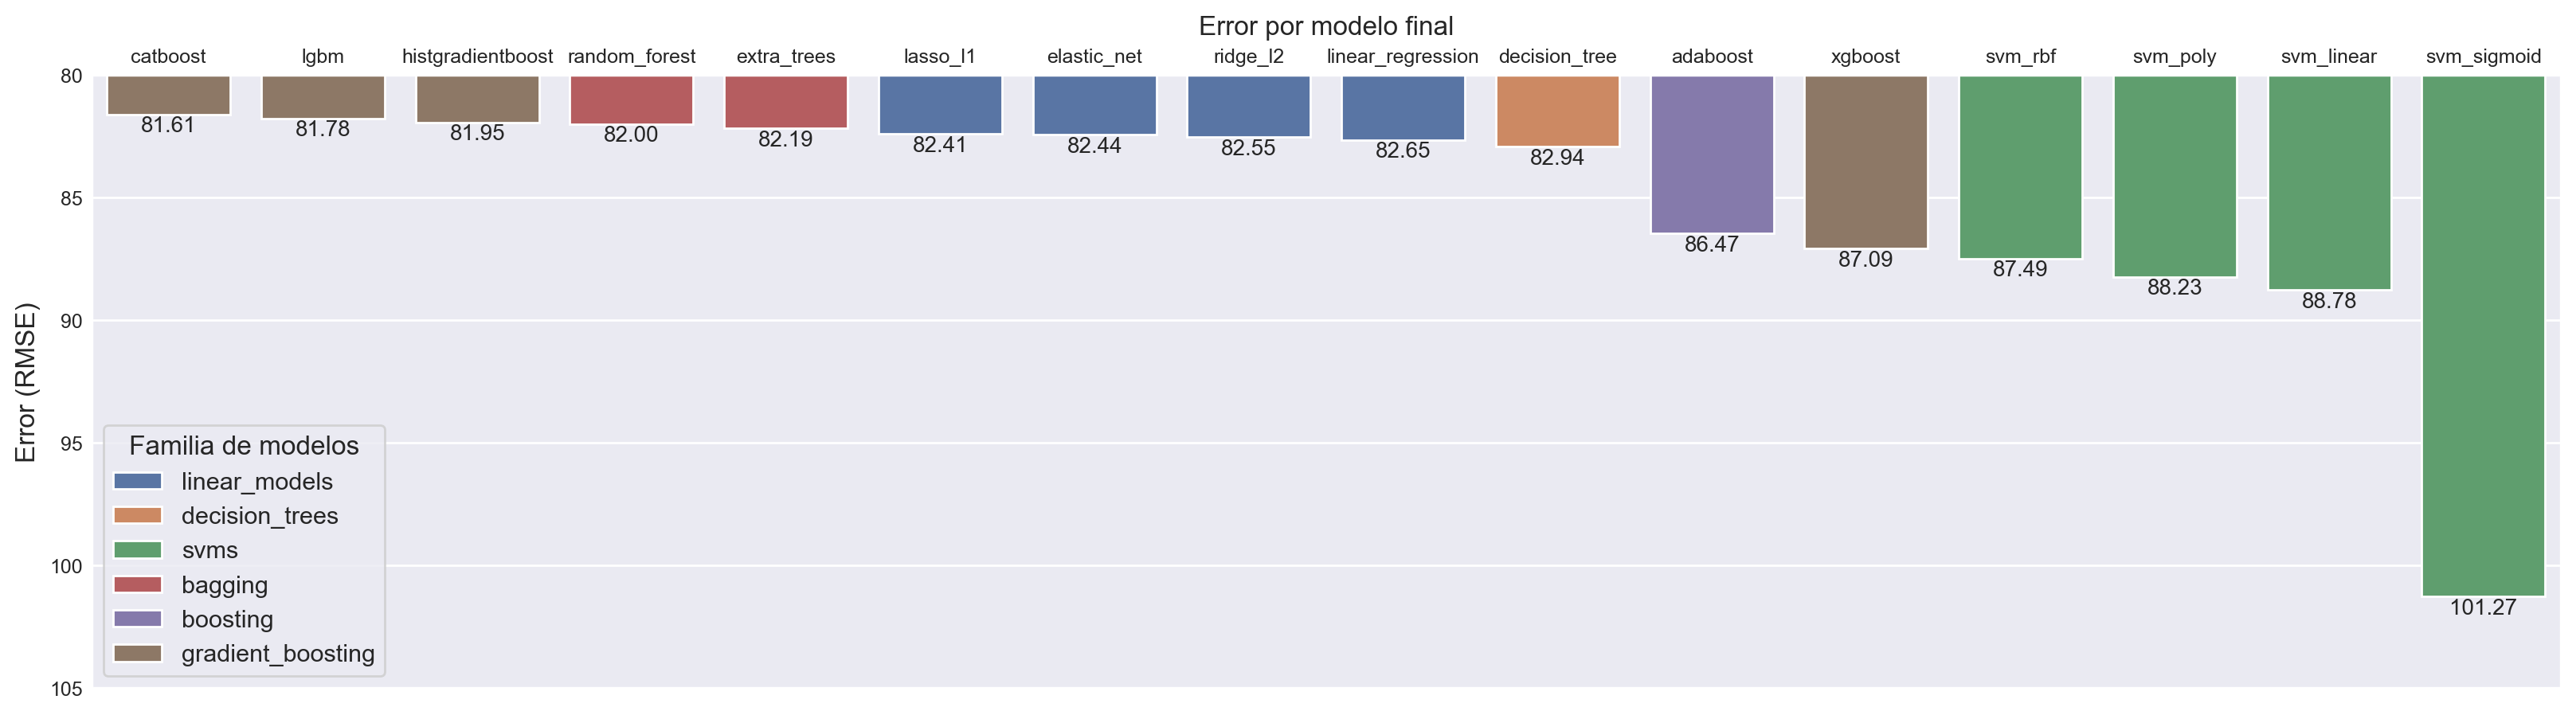

In [92]:
# VALIDATION SCORE PER MODEL

# PLOTTING
# Create the figure
fig = plt.figure(figsize=(20, 5));

# Extract a color for each family of models
feature_subset_colors = list(sns.color_palette())[:6]

# Create a bar plot - using colors based on the feature subset
# NOTE: Since errors are being shown, negative values for the error will be used
ax = sns.barplot(
    data=df_validation_results_family,
    x="model",
    y="validation_score",
    hue="family",
    order=df_validation_results_family.sort_values(by="validation_score").index
);


#########################################################################################################
# LABELS AND LEGENDS

# Add a label to each bar
for container in ax.containers:
    ax.bar_label(container, fontsize=10, padding=-10, fmt="%.2f");

plt.title("Error por modelo final")

# Since no average error is below 80, start the Y axis at 80
ax.set_ylim(105, 80)

# Set the labels and place the ticks on top of the figure
ax.tick_params(labelsize=9, pad=-2)
plt.xlabel("")
plt.ylabel("Error (RMSE)")
plt.tick_params(labeltop=True, labelbottom=False)

# Change the legend title
legend = ax.get_legend()
legend.set_title("Familia de modelos")

#########################################################################################################

plt.show();

A partir de la gráfica, se pueden observar las siguientes conclusiones:

- **El error general de todos los modelos es muy elevado para el rango de la variable objetivo**:
    - Evaluando la magnitud del error en contexto con el rango de valores, **un error de 82 es muy elevado** teniendo en cuenta que el rango de la variable objetivo es $[0, 365]$ aproximadamente - es decir, **los modelos tienden a fallar en casi un tercio del rango total de posibles valores**.
    - Al ser el error compartido por todos los modelos, la conclusión más probable es que **los atributos ofrecidos no contienen suficiente información significativa** para predecir el tiempo de diagnóstico de la metástasis.
- **Los *ensembles* ofrecen mejor rendimiento que los modelos simples**:
    - Los modelos con menor error pertenecen a las familias de *ensembles* de *Gradient Boosting* o *Bagging* - como se podía esperar, **los modelos con mayor capacidad computacional** son capaces de ofrecer un mejor rendimiento que otros modelos más simples.
    - Ahora bien, la **diferencia en error** entre *ensembles* y **modelos lineales** - la familia más simple de modelos - es más baja de lo que se podría esperar.
- **Varios de los modelos tienen rendimientos anómalos**:
    - Algunos *ensembles* - concretamente `xgboost` y `adaboost` tienen errores notablemente superiores a los del resto de *ensembles*, llegando a ser superiores incluso a los errores de muchos modelos simples. Un posible motivo puede ser un **mal ajuste de hiperparámetros** o **incompatibilidad con las características del conjunto de datos**.
    - El rendimiento de las **máquinas de vectores de soporte** es muy inferior al resto de modelos - a pesar de su elevado tiempo de entrenamiento.



---

<a id="section6-3"></a>

## 6.3. Estadísticas del modelo final


TODO EL PRIMER PUESTO UTILIZA CATBOOST DE FORMA IDÉNTICA - SOLO AÑADE CONSTRUCCION DE ATRIBUTOS

### 6.3.1 Comportamiento del modelo final seleccionado

### 6.3.2. Comportamiento del ganador de la competición

---

<a id="section7"></a>

# 7. Conclusiones

---

<a id="section8"></a>

# 8. *Streamlit* - Aplicación web